**Note:** There may be some discrepancies between the model outputs and text summaries as new data will be added periodically to the models using the streamlit app feedback

**The Impact of Strength Metrics on Climbing Performance**

In recent years companies such as Lattice and Power Climbing Company have begun using data analytics to inform climbers of where their potential weaknesses are in order to better personalise training plans (and hopefully improve long term performance).

Many of these datasets are not publicly available, but the team at Power Company Climbing have been kind enough to share theirs.

In this notebook I am using a dataset from Power Company Climbing which contains around 600 self reported members, providing a variety of climbing benchmarks. The goal of the workbook is to test different machine learning models to determine which metrics play the largest role in climbing performance, and whether we can use this data to then predict max bouldering and sport climbing grades.

The workbook splits out bouldering and sport climbing and performs the analysis on these two variations of climbing separately. This is because bouldering and sport climbing are very different disciplines, even though they are both a form of climbing.

![Burden of dreams](https://cdn.climbing.com/wp-content/uploads/2023/04/DSC01953-scaled.jpg?crop=535:301&width=1070&enable=upscale)

**Available metrics**

| Variable        | Description                                               
|------------------|-----------------------------------------------------------
| `age`            | Age of the climber                                       
| `sex`            | Sex of the climber                                       
| `max_boulder`    | Max grade of boulder on the V scale climbed in the last year 
| `max_sport`      | Max sport climbing grade climbed in the last year        
| `exp`            | Years bouldering                                         
| `trainexp`       | Years specifically training for bouldering               
| `country`        | Country of the climber                                   
| `state`          | State of the climber                                     
| `rock`           | Rock type climbed on                                     
| `season`         | Months per year spent climbing outside                   
| `days`           | Days per month spent climbing outside                     
| `height`         | Height of the climber                                    
| `weight`         | Weight of the climber                                    
| `span`           | Wing span of the climber                                 
| `pullup`         | Number of pull-ups the climber can do                   
| `pushup`         | Number of push-ups the climber can do                   
| `continuous`     | Continuous hang from a 20mm edge                        
| `maxhang`        | Max weight added to hang for 10 seconds from a 20mm edge 
| `weightedpull`   | Max weight added for a single pull-up                   
| `repeaters1`     | 7:3 hang:recovery on a 20mm edge                        
| `longcamp`       | Long campus, unclear what rungs                          
| `shortcamp`      | Short campus, unclear what rungs                         

**Final Results**

The models have produced different results for climbing vs bouldering, which was expected, indicating that it's more important to be stronger in specific areas if you want to sport climb or boulder.

For bouldering, the most important metrics were:

1. strength_to_weight_maxhang: the maximum weight you can add to your hang on a 20mm edge for 10 seconds
2. exp: how many years you have been climbing for
3. continuous: how long you can hang from a 20mm edge
4. strength_to_weight_pullup: the number of pullups you can do at bodyweight
5. days spent climbing: how many days you spend climbing each month
6. strength_to_weight_weightpull: the number of pullups you can do, with etra weight added on

This seems like a reasonable outcome given the raw strength and power needed for bouldering in the upper grades, with total years climbing experience also being important. It's generally common knowledge the longer you climb your technique will likely improve, which can contritube to climbing harder grades. 

For sport climbing, the results are quite different: 

1. days spent climbing: how many days you spend climbing each month
2. exp: how many years you have been climbing for
3. strength_to_weight_pullup: the number of pullups you can do at bodyweight
4. continuous: how long you can hang from a 20mm edge
5. strength_to_weight_weightpull: The number of pullups you can do, with your max weight added on
6. strength_to_weight_maxhang: the maximum weight you can add to your hang on a 20mm edge for 10 seconds

Again these results seems like a reasonable outcome given that sport climbing requires a lot of endurance when climbing hard grades, but it's interesting that most of the strength metrics are 3rd and 5th/6th position. This is most likely because climbing harder sport routes doesn't really need as much raw power as bouldering.

So, in summary:

If you want to boulder hard, make good use of the fingerboard and max hang training, including lots of weighted and non-weighted pullups (think explosive pulls with a band etc)
If you want to sport climb hard, improve your endurance on the 20mm edge, and do lots of pullups and non-weighted pullups.

And most importantly for both sport and bouldering - make sure you climb consistently and spend as much time climbing (improving your technique) as you can, without getting injured.

![bibliographie](https://www.patagonia.com/blog/wp-content/uploads/2020/11/etzel_k_1399_cc_web-1280x720-1.jpg)

In [ ]:
# import all requires libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
import warnings
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import shap
import mlflow
import pickle
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

warnings.filterwarnings('ignore')

In [35]:
# read the data file using pandas, specifying the encoding
original_data = pd.read_csv(r'original_data_files/PowerCompanyAssessmentData.csv',encoding="cp1252")

# display the first few rows of the dataframe to check everything is in order
print(original_data.columns)

# drop the "country", "state", and "rock" columns from the dataframe, as they will not be used in the analysis
data = original_data.drop(columns=["country", "state", "rock"])
print(data.columns)  # print the dataframe again to confirm the columns have been dropped

Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'country',
       'state', 'rock', 'season', 'days', 'height', 'weight', 'span', 'pullup',
       'pushup', 'continuous', 'maxhang', 'weightedpull', 'repeaters1',
       'longcamp', 'shortcamp', 'ohpr', 'ohll', 'dl', 'bmi_score'],
      dtype='object')
Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'season',
       'days', 'height', 'weight', 'span', 'pullup', 'pushup', 'continuous',
       'maxhang', 'weightedpull', 'repeaters1', 'longcamp', 'shortcamp',
       'ohpr', 'ohll', 'dl', 'bmi_score'],
      dtype='object')


In [36]:
# check the total number of rows and columns in the DataFrame
total_rows, total_columns = data.shape

# print the values of each
print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 679
Total number of columns: 23


In [37]:
# transform variables from the imperial to the metric system
data['height'] = data['height'] * 2.54  # convert inches to centimeters
data['weight'] = data['weight'] * 0.45359237  # convert pounds to kilograms
data['ohpr'] = data['ohpr'] * 0.45359237  # convert pounds to kilograms
data['ohll'] = data['ohll'] * 0.45359237  # convert pounds to kilograms
data['dl'] = data['dl'] * 0.45359237  # convert pounds to kilograms
data['span'] = data['span'] * 2.54  # convert inches to centimeters
data['weightedpull'] = data['weightedpull'] * 0.45359237  # convert pounds to kilograms
data['maxhang'] = data['maxhang'] * 0.45359237  # convert pounds to kilograms

# create new variables representing strength-to-weight ratios for different physical activities
data['strength_to_weight_pullup'] = data['pullup'] / data['weight']
data['strength_to_weight_weightpull'] = (data['weightedpull'] + data['weight']) / data['weight']
data['strength_to_weight_maxhang'] = (data['maxhang'] + data['weight']) / data['weight']

# coerce any errors during conversion of 'continuous' column to a numeric type to NaN
data['continuous'] = pd.to_numeric(data['continuous'], errors='coerce')

In [38]:
print(data["sex"].value_counts())

sex
Male                          490
Female                        182
0                               3
Other/Prefer to Not Answer      3
Other                           1
Name: count, dtype: int64


In [39]:
# create dictionaries to map experience, season, and days climbing to numeric values so we can use these if needed in our models
experience_dict = { "< 1 year":1,"<1 year":1,"1-2 years":2,"3-4 years":3,"5-6 years":4,"7-8 years":5,
                   "9-10 years":6, ">10 years":7, "> 10 years":8}

season_dict = {"1-3 months":1,"4-6 months":2,"7-9 months":3,"Year round":4}

days_dict = {'3-4 days per month':3, '5-6 days per month':4, '1-5 days per month':5,
       '7-8 days per month':6, '>10 days per month':7, '>15 days per month':8,
             '9-10 days per month':9, 'I currently do no climb outdoors':1, '15-20':10,}

sex_dict = {'Male':1, 'Female':2, 'Other/Prefer to Not Answer':3,'Other':3,'0':3, 'NaN':3}

In [40]:
# apply the dictionaries to the respective columns
data["exp"] = data["exp"].map(experience_dict)
data["sex"] = data["sex"].map(sex_dict)
data["trainexp"] = data["trainexp"].map(experience_dict)
data["season"] = data["season"].map(season_dict)
data['days'] = data['days'].replace(days_dict)
data['days'] = pd.to_numeric(data['days'])

# Convert 'days' from per year to per month for entries from index 37 onwards as historically users inputed their climbing days like this
data["days"][37:] = data["days"][37:]/12

In [41]:
# show distribution of values for all columns which had dictionaries applied
print(data["sex"].value_counts())


sex
1    490
2    182
3      7
Name: count, dtype: int64


In [42]:
# define a map to convert French grades to numerical values
conversion_map_french = {
    '4c': 1, '5a': 2, '5b': 3, '5c': 4, '6a': 5,
    '6a+': 6, '6b': 7, '6b+': 8, '6c': 9, '6c+': 10, '7a': 11,
    '7a+': 12, '7b': 13, '7b+': 14, '7c': 15, '7c+': 16, '8a': 17,
    '8a+': 18, '8b': 19, '8b+': 20, '8c': 21, '8c+': 22, '9a': 23, '9a+': 24, '0': 0
}
    
# also define an approach to convert numerical grade back to french sport grade so that users can easily understand their results
# reverse the conversion_map dictionary to map from numerical grade back to French grade sport
inverse_conversion_map_f = {v: k for k, v in conversion_map_french.items()}

In [43]:
grade_order_sport = [
    '0', '4c', '5c', '6a', '6a+', '6b', '6b+', '6c', '6c+', 
    '7a', '7a+', '7b', '7b+', '7c', '7c+', '8a', '8a+', '8b', '8b+',
    '8c', '8c+','9a', '9a+', '9b', '9b+', '9c' 
]

grade_order_bouldering = [
     '0','<V3', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
     'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 
]

In [44]:
import re

def convert_to_french_grade(grade):
      
    conversion_map_yds = {
        "<5.10": "4c",
        "5.10": "5a", "5.10a": "5b", "5.10b": "5c",
        "5.10c": "5c", "5.10d": "6a", "5.11a": "6a",
        "5.11b": "6a+", "5.11c": "6b", "5.11d": "6b+",
        "5.12a": "6c", "5.12b": "6c+", "5.12c": "7a",
        "5.12d": "7a+", "5.13a": "7b", "5.13b": "7b+",
        "5.13c": "7c", "5.13d": "7c+", "5.14a": "8a",
        "5.14b": "8a+", "5.14c": "8b", "5.14d": "8b+",
        "5.15a": "8c", "5.15b": "8c+", "5.15c": "9a",
        "5.15d": "9a+", "I have not pursued sport climbing goals outside in the past year": "0"
    }
    
    # Directly return if the grade is in the map (handles "<5.10" and the special string)
    if grade in conversion_map_yds:
        return conversion_map_yds[grade]
    
    if pd.isnull(grade):  # check if the grade is null
        return np.nan  # return NaN if grade is null

    # Extract number and letter separately
    match = re.match(r"(5\.\d+)([a-d]?)(?:/[a-d]?)?", grade)
    
    if match:
        number_part = match.group(1)  # The "5.12" part
        letter_part = match.group(2)  # The "c" part (if any)
        
        # If there's a "/", take the last letter
        if "/" in grade:
            letter_part = grade.split("/")[-1][-1]  # Take the last letter after "/"

        final_grade = number_part + letter_part  # Reconstruct full grade

        if final_grade in conversion_map_yds:
            return conversion_map_yds[final_grade]  # Convert the grade to French grade
        else:
            raise ValueError(f'Unexpected grade value: {final_grade}') 

    # If nothing matched, it's an invalid grade
    raise ValueError(f'Invalid grade format: {grade}')



# now define a function to convert numeric grade to french grade
def convert_numeric_to_f_grade(numeric_grade):
    numeric_grade = round(numeric_grade)

    if numeric_grade in inverse_conversion_map_f:
        return inverse_conversion_map_f[numeric_grade]
    else:
        return "Unknown grade" 

In [45]:
# define a function to convert V Grade bouldering to numeric
conversion_map_boulder = {
    "<V3": 1,
    "V3": 2, "V4": 3, "V5": 4,
    "V6": 5, "V7": 6, "V8": 7,
    "V9": 8, "V10": 9, "V11": 10,
    "V12": 11, "V13": 12, "V14": 13,
    "V15": 14, "V16": 15, "I have not pursued bouldering goals outside in the past year": 0
}

# reverse the conversion_map dictionary to map from numerical grade back to V grade
inverse_conversion_map_v = {v: k for k, v in conversion_map_boulder.items()}

In [46]:
def convert_v_grade_to_numeric(grade):

    if grade in conversion_map_boulder:  # check if the grade is in the conversion map
        return conversion_map_boulder[grade]  # convert the grade to numeric
    else:
        return np.nan  # return NaN for unknown or unclassifiable grades

In [47]:
# function to convert numeric grade to V grade
def convert_numeric_to_v_grade(numeric_grade):
    numeric_grade = round(numeric_grade)

    if numeric_grade in inverse_conversion_map_v:
        return inverse_conversion_map_v[numeric_grade]
    else:
        return "Unknown grade" 

In the two sections above I have converted the YDS and V grades to numeric values, again to help with analysis later on. I have also gone one step further with the sport climbing grades and converted from the YDS to French grade. Below I've created a reverse mapping in order to convert the numeric output of the models back in to V grades and French sport grades.

In [48]:
# apply the conversion function to create a new column of French grades
try:
    data['max_sport_french'] = data['max_sport'].apply(convert_to_french_grade)
except ValueError as e:
    print(e) 

# map the French grades to numerical values
data['max_sport_numeric'] = data['max_sport_french'].map(conversion_map_french)

In [49]:

# apply the conversion function to the 'max_boulder' column to create a new column of numeric V grades
data['max_boulder_numeric'] = data['max_boulder'].apply(convert_v_grade_to_numeric)

In [50]:
# display the first few rows of the dataframe to check the new columns
print(data.head())

   age  sex max_boulder max_sport  exp  trainexp  season  days  height  \
0   43    2         <V3   5.10c/d  7.0       1.0     3.0   3.0  165.10   
1   16    2          V6   5.12c/d  5.0       5.0     2.0   4.0  162.56   
2   19    1          V9   5.13c/d  7.0       5.0     2.0   5.0  177.80   
3   34    1          V8   5.12a/b  7.0       4.0     2.0   6.0  172.72   
4   30    2          V8   5.12a/b  5.0       3.0     2.0   4.0  172.72   

      weight  ...       ohpr       ohll         dl  bmi_score  \
0  68.492448  ...        NaN        NaN        NaN       25.1   
1  56.699046  ...   6.803886   6.803886  49.895161       21.5   
2  70.306817  ...        NaN        NaN        NaN       22.2   
3  74.842741  ...        NaN        NaN        NaN       25.1   
4  64.410117  ...  11.339809  11.339809  65.770894       21.6   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   0.029200                       1.066225   
1                   0.264555          

In [51]:
# display all the column names and their data type
print(data.columns)

Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'season',
       'days', 'height', 'weight', 'span', 'pullup', 'pushup', 'continuous',
       'maxhang', 'weightedpull', 'repeaters1', 'longcamp', 'shortcamp',
       'ohpr', 'ohll', 'dl', 'bmi_score', 'strength_to_weight_pullup',
       'strength_to_weight_weightpull', 'strength_to_weight_maxhang',
       'max_sport_french', 'max_sport_numeric', 'max_boulder_numeric'],
      dtype='object')


max_sport_french
0      170
6c+    150
7a+     91
7b+     82
6b+     47
6a+     42
7c+     38
6a      21
8a+     14
5c      14
4c       3
8b+      1
Name: count, dtype: int64


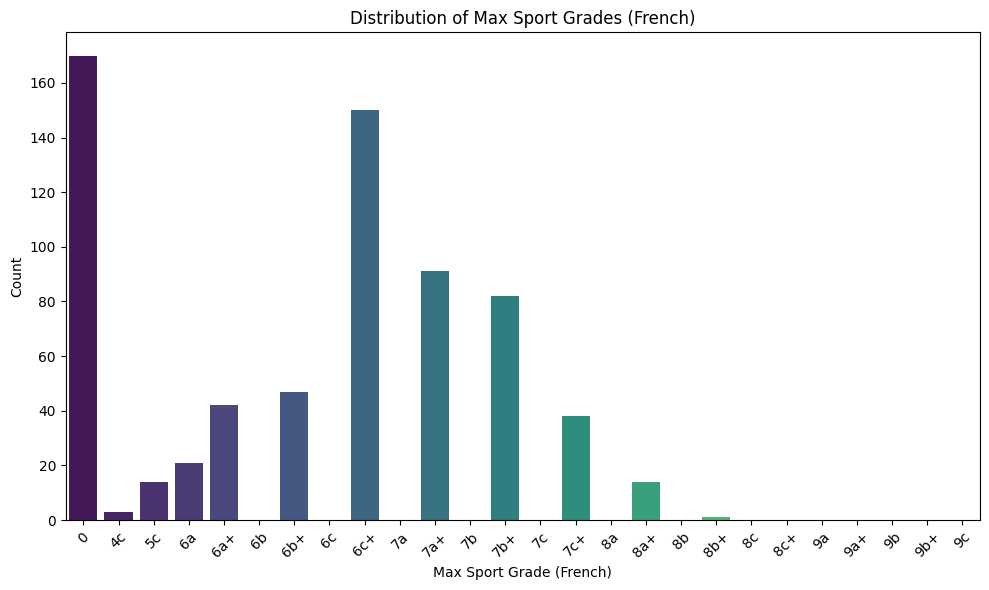

In [52]:
# get an idea of the spread of sport climbing grades
count_max_sport = data['max_sport_french'].value_counts()
print(count_max_sport)

count_max_sport_df = count_max_sport.reset_index()
# Define the desired order based on the conversion map

# Convert 'max_sport_french' to a categorical type with the specified order
count_max_sport_df['max_sport_french'] = pd.Categorical(
    count_max_sport_df['max_sport_french'], 
    categories=grade_order_sport, 
    ordered=True
)

# Sort the DataFrame by the ordered categories
count_max_sport_df = count_max_sport_df.sort_values('max_sport_french')

plt.figure(figsize=(10, 6))
sns.barplot(x='max_sport_french', y='count', data=count_max_sport_df, palette='viridis')

plt.title('Distribution of Max Sport Grades (French)')
plt.xlabel('Max Sport Grade (French)')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

There's 170 users in the dataset who have not submitted a sport climbing grade. This isn't ideal, but we can work with it.

max_boulder
I have not pursued bouldering goals outside in the past year    149
V8                                                               88
V7                                                               85
V5                                                               78
V6                                                               62
V10                                                              59
V9                                                               48
V4                                                               39
<V3                                                              31
V11                                                              16
V12                                                              10
V13                                                               6
V15                                                               2
V14                                                               2
Name: count, dtype: int64


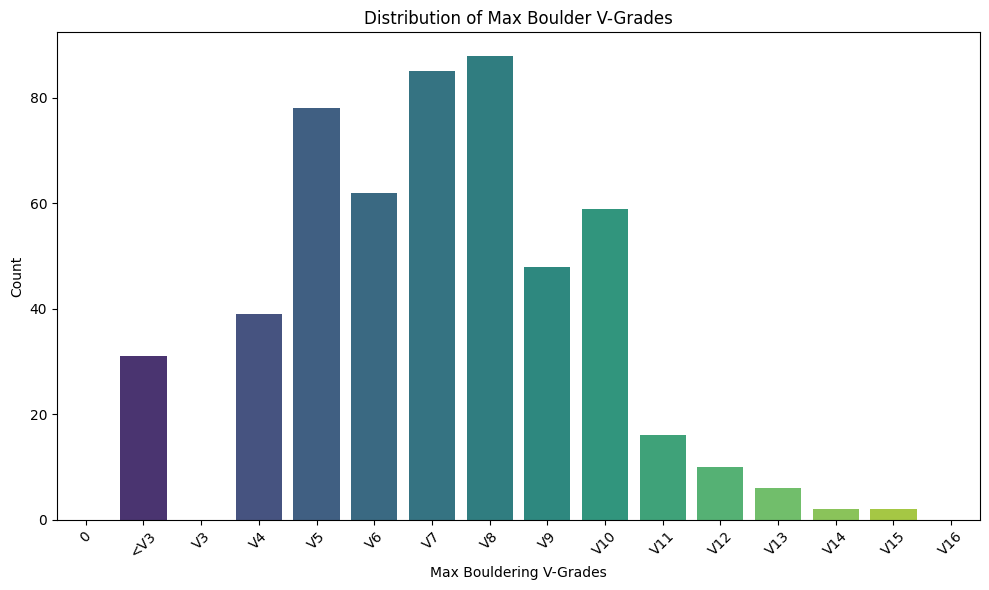

In [53]:
# get an idea of the spread of sport climbing grades
count_max_bouldering = data['max_boulder'].value_counts()
print(count_max_bouldering)

count_max_bouldering_df = count_max_bouldering.reset_index()


# Convert 'max_boulder' to a categorical type with the specified order
count_max_bouldering_df['max_boulder'] = pd.Categorical(
    count_max_bouldering_df['max_boulder'], 
    categories=grade_order_bouldering, 
    ordered=True
)

# Sort the DataFrame by the ordered categories
count_max_bouldering_df = count_max_bouldering_df.sort_values('max_boulder')

plt.figure(figsize=(10, 6))
sns.barplot(x='max_boulder', y='count', data=count_max_bouldering_df, palette='viridis')

plt.title('Distribution of Max Boulder V-Grades')
plt.xlabel('Max Bouldering V-Grades')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

Similar to the sport climbing numbers, there are 149 users who have not submitted a bouldering grade. Since this totals 319 rows, we might need to do some imputing but first let's investigate if there is a relationship between the variables.

Total rows:
679

Percentage of zeroes:
pushup                        0.147275
span                          0.294551
continuous                    0.441826
ohpr                          0.589102
ohll                          0.589102
days                          0.736377
shortcamp                     1.030928
pullup                        1.178203
longcamp                      1.178203
strength_to_weight_pullup     1.178203
repeaters1                    1.472754
dl                            1.620029
weightedpull                  1.767305
maxhang                       3.240059
max_boulder_numeric          21.944035
max_sport_numeric            25.036819
dtype: float64

Counts of NaNs:
weight                             1
trainexp                           2
max_boulder                        4
height                             4
max_boulder_numeric                4
exp                                4
max_sport                          6
max_sport_french                   6
max_sport

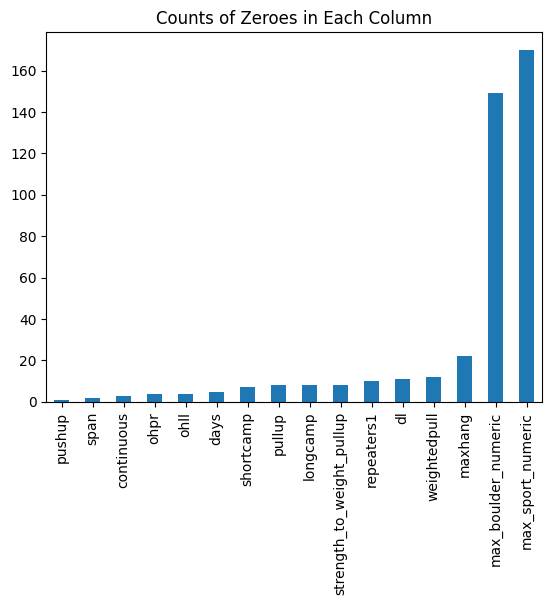

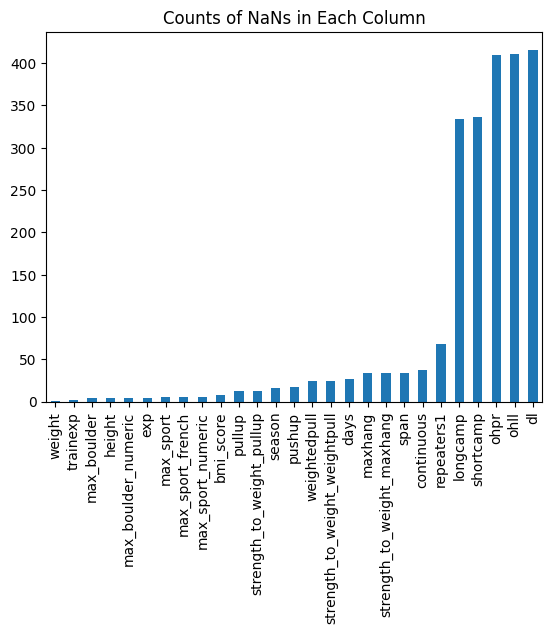

In [54]:
# count zero values and filter columns with more than 0 zeroes
zero_counts = (data == 0).sum()
zero_counts = zero_counts[zero_counts > 0]
zero_counts.sort_values(inplace=True)

# calculate percentage of total values that are zero for each column
total_rows = len(data)
zero_percentage = (zero_counts / total_rows) * 100

nan_counts = data.isnull().sum()
nan_counts = nan_counts[nan_counts > 0]
nan_counts.sort_values(inplace=True)

# print and plot
print("Total rows:")
print(total_rows)
print("\nPercentage of zeroes:")
print(zero_percentage)
print("\nCounts of NaNs:")
print(nan_counts)

# create bar plot for zero counts
zero_counts.plot.bar()
plt.title('Counts of Zeroes in Each Column')
plt.show()

# create bar plot for nan counts
nan_counts.plot.bar()
plt.title('Counts of NaNs in Each Column')
plt.show()


We can assume that where the numbers are 0, the users has simply not completed that exercise or does not have an idea of what they could lift.

Now we can start cleaning up the dataset a little bit, removing any redundant columns.

In [55]:
data_clean = data.copy()

# now that we have our new numeric columns we can remove all non-numeric columns related to grade
data_clean.drop(['max_boulder', 'max_sport','max_sport_french'], axis=1, inplace=True)
data_clean.head()

age  sex  exp  trainexp  season  days  height     weight    span  pullup  \
0   43    2  7.0       1.0     3.0   3.0  165.10  68.492448  165.10     2.0   
1   16    2  5.0       5.0     2.0   4.0  162.56  56.699046  162.56    15.0   
2   19    1  7.0       5.0     2.0   5.0  177.80  70.306817  187.96    18.0   
3   34    1  7.0       4.0     2.0   6.0  172.72  74.842741  182.88    15.0   
4   30    2  5.0       3.0     2.0   4.0  172.72  64.410117  177.80     5.0   

   ...  shortcamp       ohpr       ohll         dl  bmi_score  \
0  ...       62.0        NaN        NaN        NaN       25.1   
1  ...        NaN   6.803886   6.803886  49.895161       21.5   
2  ...      301.0        NaN        NaN        NaN       22.2   
3  ...        NaN        NaN        NaN        NaN       25.1   
4  ...      210.0  11.339809  11.339809  65.770894       21.6   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   0.029200                       1.066225   
1                   0.264555                       1.160000   
2                   0.256021                       1.548387   
3                   0.200420                       1.424242   
4                   0.077628                       1.176056   

   strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
0                    1.245033                5.0                  1.0  
1                    1.080000               12.0                  5.0  
2                    1.225806               16.0                  8.0  
3                    1.303030               10.0                  7.0  
4                    1.246479               10.0                  7.0  

[5 rows x 26 columns]

In [56]:
# Use KNNImputer to impute missing values, specifically the 0s
knn_imputer = KNNImputer(n_neighbors=5) 
# store column names before imputation
column_names = data_clean.columns
# perform imputation
data_imputed = knn_imputer.fit_transform(data_clean)
# convert the result back to a DataFrame
data_imputed_df = pd.DataFrame(data_imputed, columns=column_names)

K-Nearest Neighbors (KNN) is a versatile algorithm that can be used for both classification and regression tasks, including imputation of missing values. When KNN is used for imputation, the basic idea is to fill in a missing value for a given data point with the value of the nearest neighbor(s). KNN imputation can be particularly effective when the data has an underlying structure that can be captured with the distance metric, meaning that points that are close in the feature space have similar target values. 

I have made an assumption here that strength metrics which are close together predict similar max sport and bouldering grades.

In [57]:
data_imputed_df.head()

age  sex  exp  trainexp  season  days  height     weight    span  pullup  \
0  43.0  2.0  7.0       1.0     3.0   3.0  165.10  68.492448  165.10     2.0   
1  16.0  2.0  5.0       5.0     2.0   4.0  162.56  56.699046  162.56    15.0   
2  19.0  1.0  7.0       5.0     2.0   5.0  177.80  70.306817  187.96    18.0   
3  34.0  1.0  7.0       4.0     2.0   6.0  172.72  74.842741  182.88    15.0   
4  30.0  2.0  5.0       3.0     2.0   4.0  172.72  64.410117  177.80     5.0   

   ...  shortcamp       ohpr       ohll          dl  bmi_score  \
0  ...     62.000  11.339809  10.886217   67.675982       25.1   
1  ...     95.276   6.803886   6.803886   49.895161       21.5   
2  ...    301.000  22.498182  22.498182  127.368737       22.2   
3  ...    117.200  21.863152  21.863152  111.402286       25.1   
4  ...    210.000  11.339809  11.339809   65.770894       21.6   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   0.029200                       1.066225   
1                   0.264555                       1.160000   
2                   0.256021                       1.548387   
3                   0.200420                       1.424242   
4                   0.077628                       1.176056   

   strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
0                    1.245033                5.0                  1.0  
1                    1.080000               12.0                  5.0  
2                    1.225806               16.0                  8.0  
3                    1.303030               10.0                  7.0  
4                    1.246479               10.0                  7.0  

[5 rows x 26 columns]

Now we've imputed the values, it's worth doing another sanity check on the data.

In [58]:
data_imputed_df.describe()

age         sex         exp    trainexp      season        days  \
count  679.000000  679.000000  679.000000  679.000000  679.000000  679.000000   
mean    33.513991    1.288660    5.223859    2.928130    2.650957    4.112838   
std      7.856345    0.475696    1.758407    1.644376    0.968194    4.016163   
min     16.000000    1.000000    1.000000    1.000000    1.000000    0.000000   
25%     28.000000    1.000000    4.000000    2.000000    2.000000    2.083333   
50%     32.000000    1.000000    5.000000    3.000000    3.000000    3.333333   
75%     38.000000    2.000000    7.000000    4.000000    3.000000    5.000000   
max     73.000000    3.000000    8.000000    8.000000    4.000000   75.000000   

           height      weight        span      pullup  ...   shortcamp  \
count  679.000000  679.000000  679.000000  679.000000  ...  679.000000   
mean   174.590951   69.142728  178.501511   14.626510  ...  148.011384   
std     13.523484   10.267701   38.336380    6.647634  ...   85.108489   
min    144.780000   32.658651    0.000000    0.000000  ...    0.000000   
25%    167.640000   62.595747  170.180000   11.000000  ...   92.200000   
50%    175.260000   69.853225  177.800000   14.000000  ...  133.276000   
75%    180.340000   75.749926  185.420000   18.000000  ...  182.800000   
max    406.400000  130.634603  482.600000   68.000000  ...  730.000000   

             ohpr        ohll          dl   bmi_score  \
count  679.000000  679.000000  679.000000  679.000000   
mean    20.438244   20.006323  108.424876   22.656672   
std      5.415299    5.459977   33.613606    2.492304   
min      0.000000    0.000000    0.000000    4.500000   
25%     16.510762   16.147888   88.450512   21.300000   
50%     21.046686   20.411657  110.222946   22.600000   
75%     24.040396   23.677522  129.273825   23.920000   
max     40.823313   38.555351  272.155422   41.300000   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
count                 679.000000                     679.000000   
mean                    0.214431                       1.462283   
std                     0.099361                       0.201849   
min                     0.000000                       1.000000   
25%                     0.156345                       1.333333   
50%                     0.203504                       1.457143   
75%                     0.260173                       1.592593   
max                     1.063222                       2.666667   

       strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
count                  679.000000         679.000000           679.000000  
mean                     1.374370           8.045066             4.757585  
std                      0.208407           5.513098             3.345137  
min                      1.000000           0.000000             0.000000  
25%                      1.232732           0.500000             1.000000  
50%                      1.371795          10.000000             5.000000  
75%                      1.504700          12.000000             7.000000  
max                      2.564516          20.000000            14.000000  

[8 rows x 26 columns]

There are some suspicious looking values in there for height, span, short camp. To ensure we don't have  any strange outliers in our data, or the highly likely possiblity someone typed something in wrong, we'll remove any outliers using z-scores.

This below section is used for detecting and removing outliers in the dataset. It allows me to see what the median, min, and max values are to help decide which columns have significant outliers. In this case I am using z-score which is also known as a standard score. This is a numerical measurement that describes a value's relationship to the mean of a group of values. It is measured in terms of standard deviations from the mean. If a z-score is 0, it indicates that the data point's score is identical to the mean score.

In [62]:
# Calculate absolute Z-scores for all numeric columns
abs_z_scores = np.abs(stats.zscore(data_imputed_df.select_dtypes(include=[np.number])))

# Identify outliers (beyond 3 standard deviations)
outlier_mask = abs_z_scores > 3

# Create a DataFrame to capture outliers
outliers = pd.DataFrame()

# Loop through each numeric column to find outliers
for col in data_imputed_df.select_dtypes(include=[np.number]).columns:
    # Get the outlier values for the column
    outlier_values = data_imputed_df.loc[outlier_mask[col], col]
    
    # If there are outliers, add them to the outliers DataFrame
    if not outlier_values.empty:
        outliers[col] = outlier_values

# Print the outliers DataFrame
print("Outliers detected in the following columns:")
print(outliers)

Outliers detected in the following columns:
      age  sex  trainexp  days  height  weight  span  pullup  pushup  \
37   59.0  NaN       NaN   NaN     NaN     NaN   NaN     NaN     NaN   
356  73.0  NaN       NaN   NaN     NaN     NaN   NaN     NaN     NaN   
362  58.0  NaN       NaN   NaN     NaN     NaN   NaN     NaN     NaN   
409  60.0  NaN       NaN   NaN     NaN     NaN   NaN     NaN     NaN   
516  59.0  NaN       NaN   NaN     NaN     NaN   NaN     NaN     NaN   
628  61.0  NaN       NaN   NaN     NaN     NaN   NaN     NaN     NaN   

     continuous  ...  repeaters1  longcamp  shortcamp  ohpr  ohll   dl  \
37          NaN  ...         NaN       NaN        NaN   NaN   NaN  0.0   
356         NaN  ...         NaN       NaN        NaN   NaN   NaN  NaN   
362         NaN  ...         NaN       NaN        NaN   NaN   NaN  NaN   
409         NaN  ...         NaN       NaN        NaN   NaN   NaN  NaN   
516         NaN  ...         NaN       NaN        NaN   NaN   NaN  NaN   
628    

In [ ]:
# Calculate absolute Z-scores for all numeric columns
abs_z_scores = np.abs(stats.zscore(data_imputed_df.select_dtypes(include=[np.number])))

# Identify non-outliers (within 3 standard deviations)
non_outlier_mask = (abs_z_scores < 3).all(axis=1)

# Remove outliers
data_imputed_df = data_imputed_df[non_outlier_mask]

# Descriptive statistics after outlier removal to confirm outliers have been removed
data_imputed_df.describe()

              age         sex         exp    trainexp      season        days  \
count  589.000000  589.000000  589.000000  589.000000  589.000000  589.000000   
mean    33.023769    1.280136    5.136503    2.797963    2.624788    3.901104   
std      7.294074    0.449447    1.752270    1.511271    0.972337    2.670147   
min     16.000000    1.000000    1.000000    1.000000    1.000000    0.000000   
25%     28.000000    1.000000    4.000000    2.000000    2.000000    2.083333   
50%     32.000000    1.000000    5.000000    3.000000    2.200000    3.333333   
75%     37.000000    2.000000    7.000000    4.000000    3.000000    5.000000   
max     55.000000    2.000000    8.000000    7.000000    4.000000   14.583333   

           height      weight        span      pullup  ...   shortcamp  \
count  589.000000  589.000000  589.000000  589.000000  ...  589.000000   
mean   174.037048   68.814914  177.130070   14.158913  ...  140.303107   
std      9.306349    9.856076   11.338568    5.6

In [64]:
# validation check on number of rows again. We expect to see less rows after dropping outliers
total_rows, total_columns = .shape

total_rows = len(data_imputed_df)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 589
Total number of columns: 26


In [67]:
# count zero values and filter columns with more than 0 zeroes
zero_counts = (data_imputed_df == 0).sum()
zero_counts = zero_counts[zero_counts > 0]
zero_counts.sort_values(inplace=True)

# calculate percentage of total values that are zero for each column
total_rows = len(data_imputed_df)
zero_percentage = (zero_counts / total_rows) * 100

nan_counts = data_imputed_df.isnull().sum()
nan_counts = nan_counts[nan_counts > 0]
nan_counts.sort_values(inplace=True)

# print and plot
print("Total rows:")
print(total_rows)
print("\nPercentage of zeroes:")
print(zero_percentage)
print("\nCounts of NaNs:")
print(nan_counts)

Total rows:
589

Percentage of zeroes:
pushup                        0.169779
continuous                    0.339559
days                          0.509338
longcamp                      0.679117
shortcamp                     0.679117
pullup                        0.848896
strength_to_weight_pullup     0.848896
weightedpull                  1.358234
repeaters1                    1.528014
maxhang                       2.716469
max_boulder_numeric          21.222411
max_sport_numeric            25.297114
dtype: float64

Counts of NaNs:
Series([], dtype: int64)


Next, we can look at the distribution of each variable to check if they follow a normal distribution. 

From these plots, we can assess the distribution of each variable. If a variable's distribution significantly deviates from a normal distribution (e.g., if it is heavily skewed), it may need to be transformed (e.g., by taking the logarithm) before being used in a machine learning model.

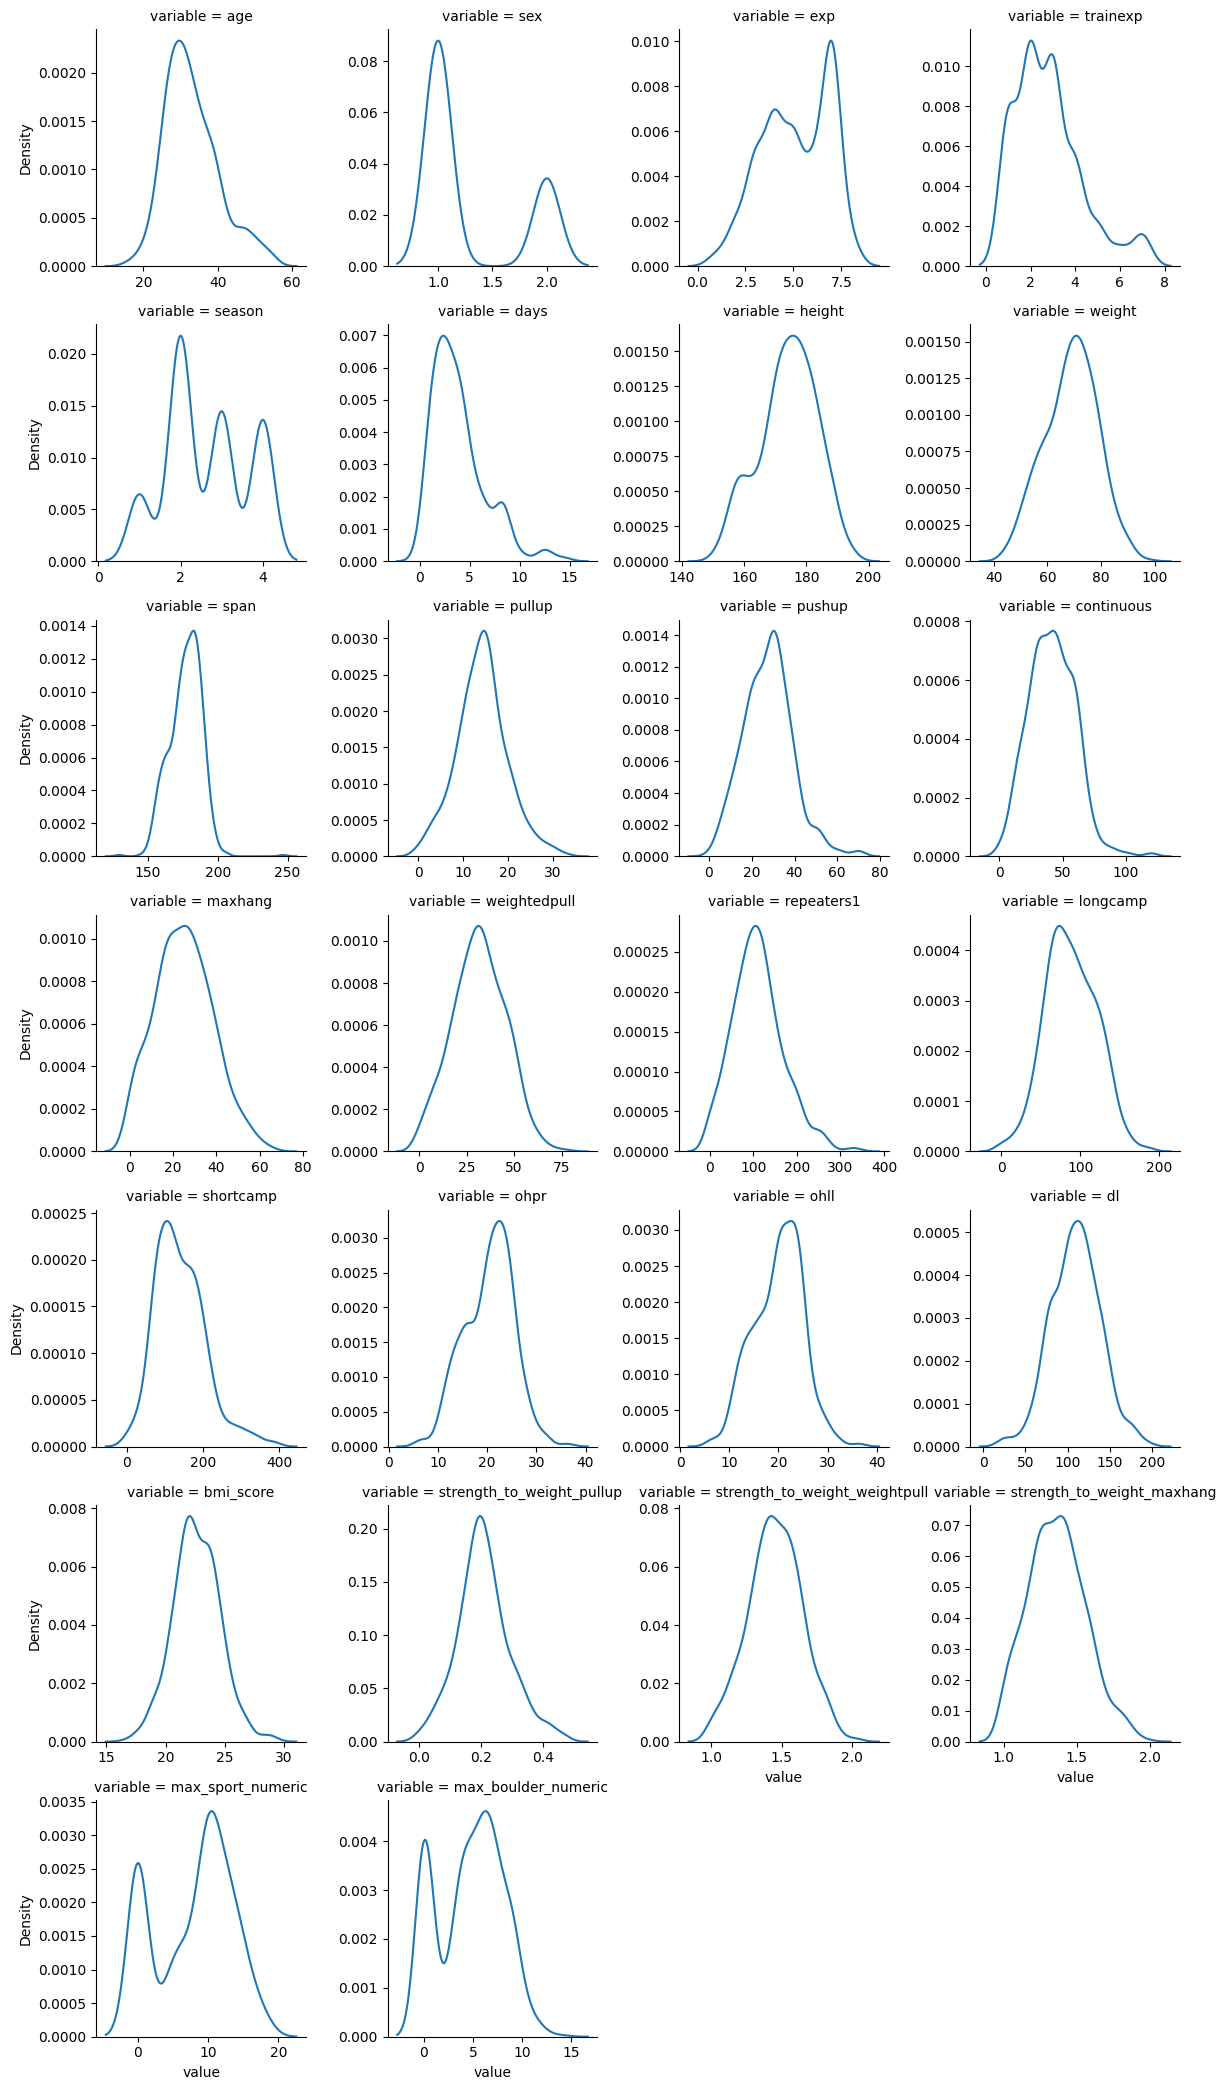

In [75]:
# melt the data to a long format where each row is a unique variable-value pair.
f = pd.melt(data_imputed_df, value_vars=data_imputed_df.columns)
# Create a FacetGrid and map KDE plots for each variable.
g = sns.displot(data=f, x="value", kind="kde", col="variable", col_wrap=4, height=3, facet_kws={'sharex': False, 'sharey': False})
plt.tight_layout()
plt.show()

By visualizing the distribution of each variable, we can gain insights about the structure of the data and identify any potential anomalies (e.g., a variable that has a single, dominant value), outliers, or trends that might warrant further investigation.

**Results**
All the variables look normally distributed so no further transformation is needed. 

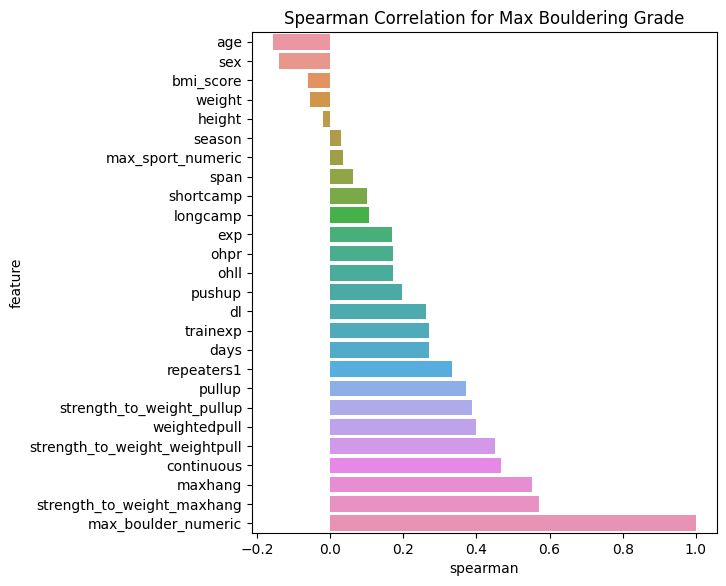

In [77]:
# spearman analysis for bouldering
def spearman(frame, features, sport_type):
    # create an empty DataFrame
    spr = pd.DataFrame()

    # add a 'feature' column that contains all feature names
    spr['feature'] = features

    # add a 'spearman' column that contains the Spearman correlation of each feature against max bouldering and sport grades
    spr['spearman'] = [frame[f].corr(frame[sport_type], 'spearman') for f in features]

    spr = spr.sort_values('spearman')

    # create a bar plot of the Spearman correlations
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.title('Spearman Correlation for Max Grade')

features = data_imputed_df.columns.tolist()

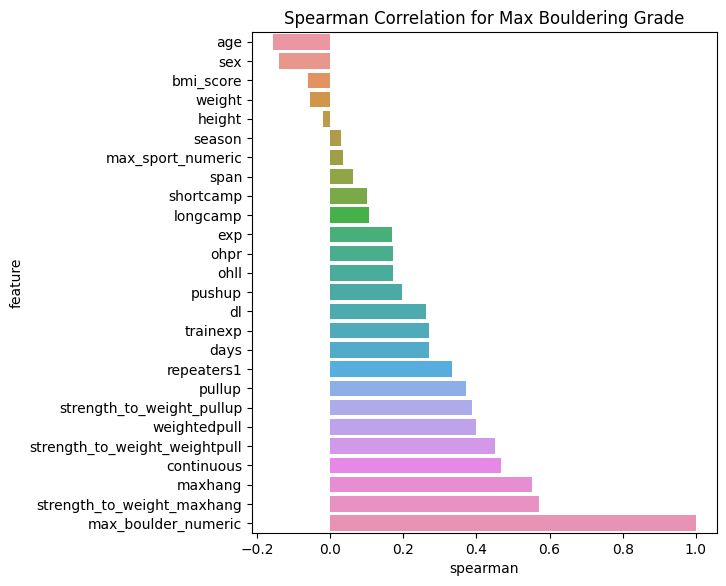

In [78]:
spearman(data_imputed_df, features,'max_boulder_numeric')

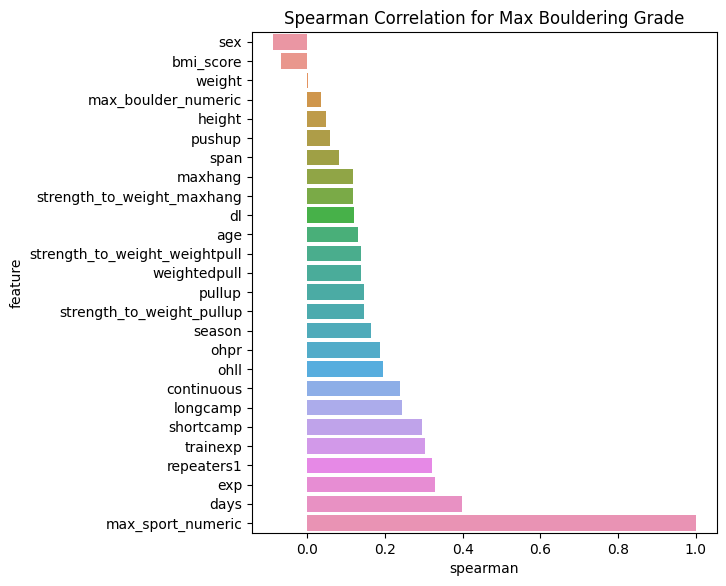

In [79]:
spearman(data_imputed_df, features,'max_sport_numeric')

Here, two Spearman correlation analyses are being performed: one for bouldering and one for sport climbing. The Spearman correlation coefficient measures the strength and direction of monotonic relationship between two variables, without making any assumptions about the distributions of the variables.

Spearman's rank correlation coefficient is a non-parametric test that is used to measure the degree of association between two variables. It is a measure of a monotonic relationship (either increasing or decreasing, but not necessarily at a constant rate) between paired data. Non-parametric tests, in statistics, refer to a set of tests that do not assume a specific distribution for the data. Unlike parametric tests, which assume that the data follow a known distribution (typically a normal distribution), non-parametric tests make fewer assumptions about the data's structure.We know that most of our data is normally distributed, but non-parametric tests are also recommended for smaller sample sizes, so we can go ahead and use Spearman's here.

In this context, it is used to evaluate the relationship between each feature (age, sex, experience, etc.) and the maximum bouldering/sport climbing grades.

In the barcharts, features that have a strong positive Spearman correlation with the target variable are good predictors for climbing grades.

**Results**

- Sex, BMI, Weight (and age for bouldering) are all of a low/negative correlation for both sport climbing and bouldering. This is quite interesting as weight is often a big focus for many climbers.
- Bouldering max grade tends to favour raw power so we can see strength to weight max hangs/weighted pullups in the top 5, with continuous hanging from a 20mm edge taking 3rd place. 
- For sport climbing, interestingly enough, there are zero strength based metrics in the top 3 variables. The number of days you sport climb outside plays a big factor, as does your climbing experience. In 3rd place we have repeaters, which means hanging on a 20mm edge for 7 seconds and then resting for 3 seconds, and repeating as many times as possible. This is somewhat expected, but a little surprising that max hangs and pullups are so far down the list for sport climbing.

**Correlations** 

The correlation matrix is calculated using the .corr() method, which calculates the pairwise correlation of columns. Correlation indicates how strongly two variables are related to each other.

The .corr() method computes the correlation coefficient, a statistical measure that calculates the strength of the relationship between the relative movements of two variables. The range of values for the correlation coefficient is -1.0 to 1.0. A correlation of -1.0 shows a perfect negative correlation, while a correlation of 1.0 shows a perfect positive correlation. A correlation of 0.0 shows no linear relationship between the movement of the two variables.

In the heatmaps, a darker color in either direction (dark blue or dark red) indicates a stronger correlation. A positive correlation (red) means that as one variable increases, the other tends to increase as well. A negative correlation (blue) means that as one variable increases, the other tends to decrease. The stronger the color, the stronger the correlation.

**Results**

We are seeing similar results to our Spearman analysis which is good sign and tells us we can have some confidence in the variables we choose for our ML models. It's also interesting to note the difference we see already between bouldering and sport climbing where endurance based metrics like continuous and repeaters have a more important role to play with max sport climbing, which makes sense.

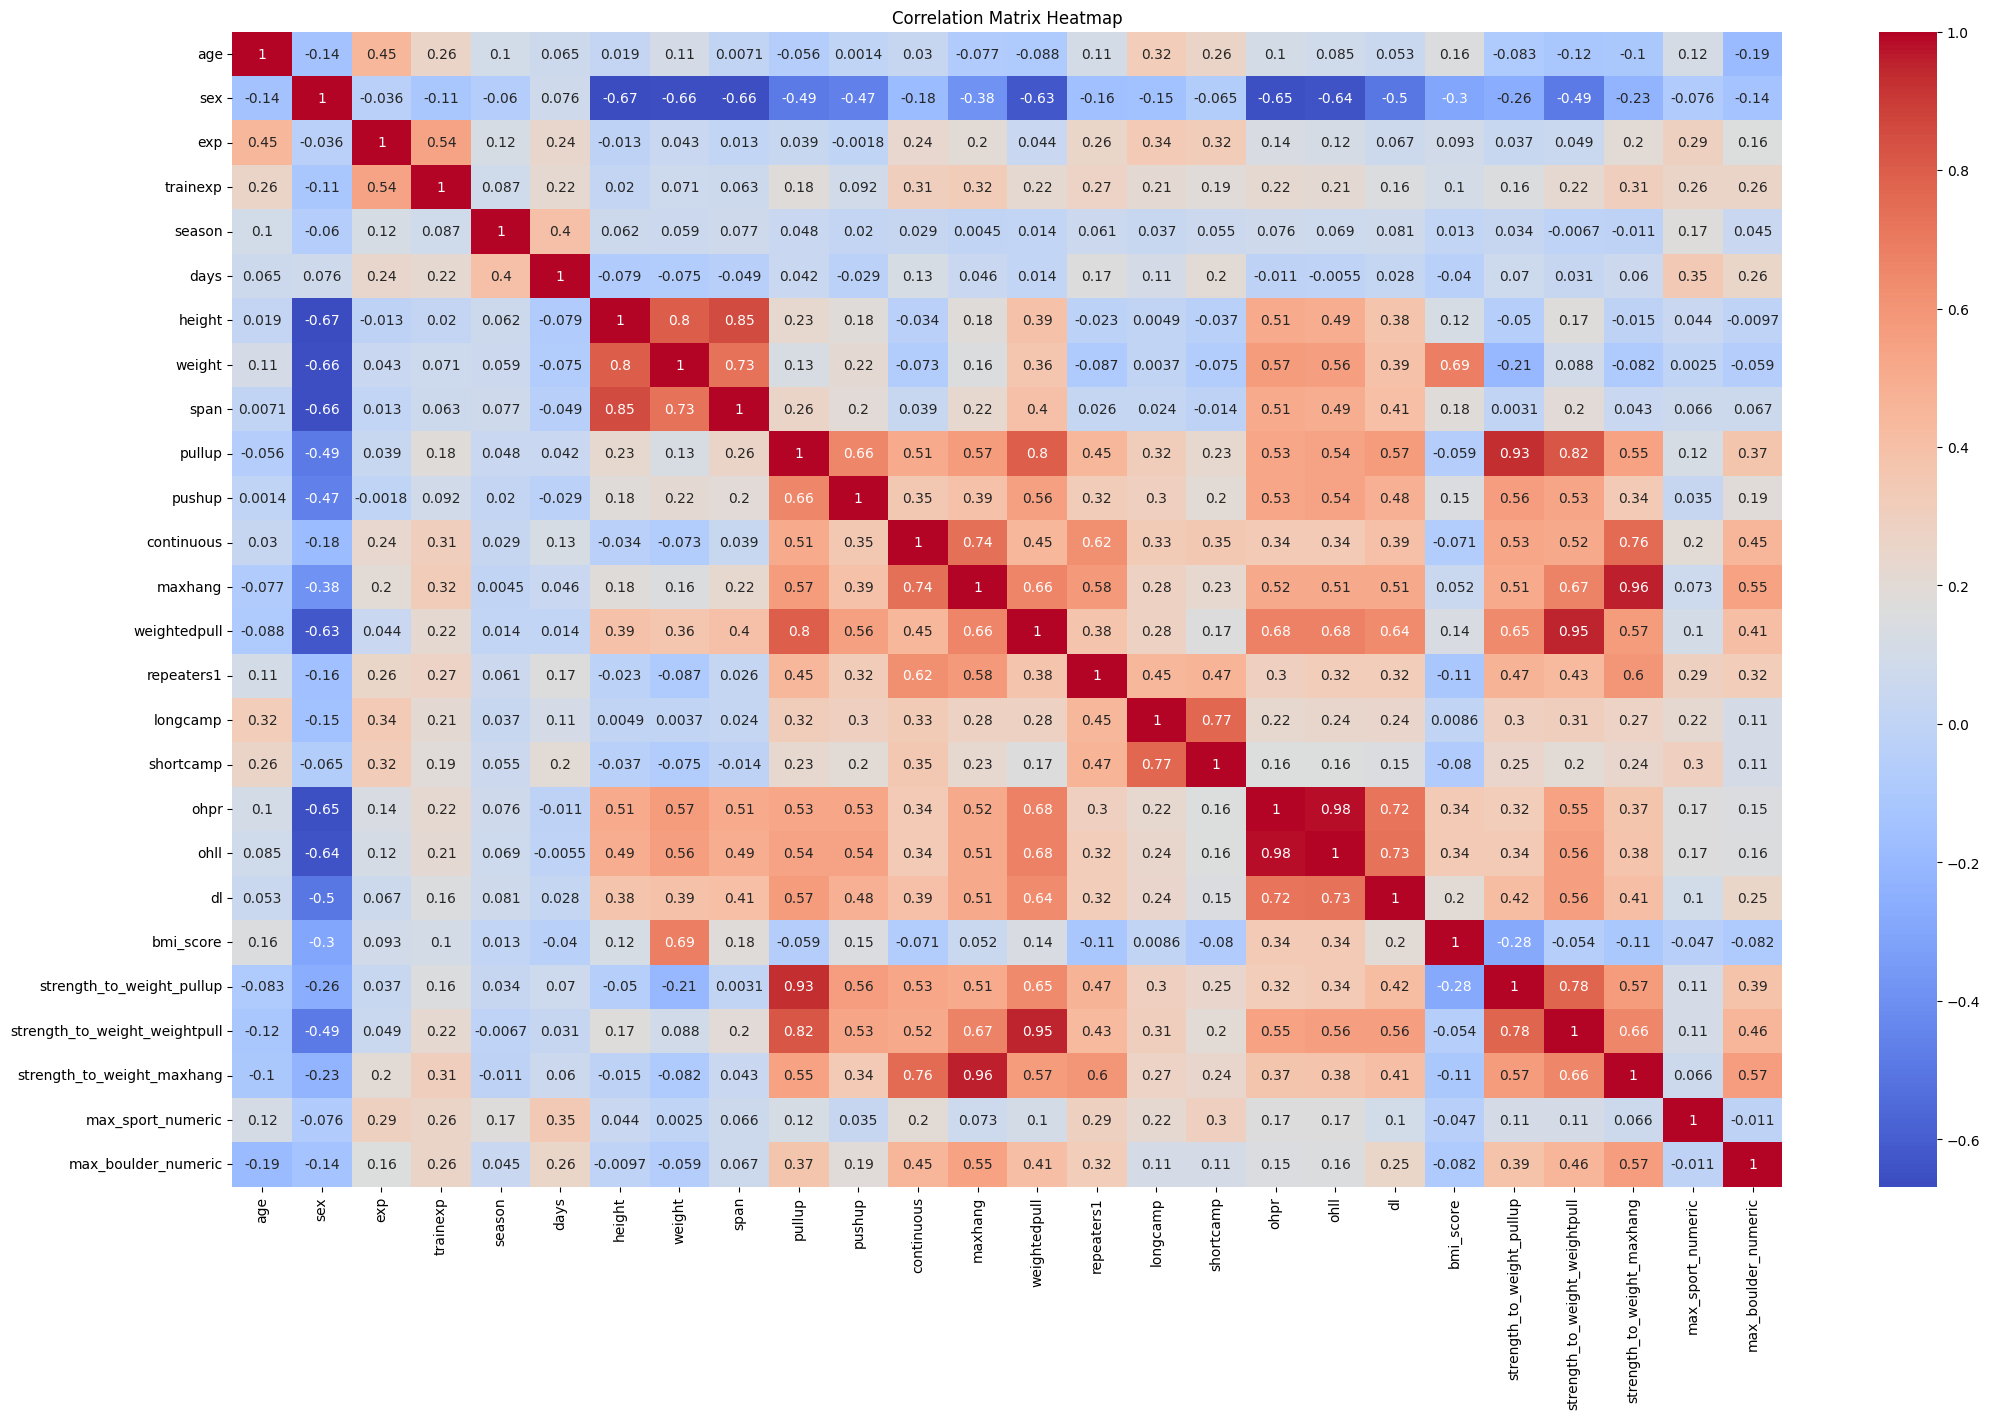

In [82]:
# calculate the correlation matrix for the specified columns in the bouldering data
corr = data_imputed_df.corr()
plt.figure(figsize=(25, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
# Calculate VIF for each explanatory variable
X = data_imputed_df
X['Intercept'] = 1  

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif.to_string(index=False))

                     Variable          VIF
                          age     1.713623
                          sex     3.753009
                          exp     1.936799
                     trainexp     1.627865
                       season     1.246035
                         days     1.558794
                       height   122.018020
                       weight   203.694131
                         span     4.223281
                       pullup   135.440785
                       pushup     2.191460
                   continuous     2.953444
                      maxhang    92.569793
                 weightedpull   230.435541
                   repeaters1     2.207631
                     longcamp     3.005543
                    shortcamp     2.855654
                         ohpr    29.055498
                         ohll    28.746772
                           dl     2.546704
                    bmi_score    76.435372
    strength_to_weight_pullup   140.948833
strength_to

In [85]:
# Drop some of the highly correlated variables
data_imputed_clean = data_imputed_df.drop(columns=['height', 'weight', 'pullup', 'maxhang', 'weightedpull'])

X = data_imputed_clean
X['Intercept'] = 1 

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif.to_string(index=False))

                     Variable         VIF
                          age    1.698210
                          sex    3.103876
                          exp    1.914505
                     trainexp    1.619326
                       season    1.236207
                         days    1.549448
                         span    2.214038
                       pushup    2.124081
                   continuous    2.915258
                   repeaters1    2.182432
                     longcamp    2.952294
                    shortcamp    2.832896
                         ohpr   28.897838
                         ohll   28.721266
                           dl    2.485948
                    bmi_score    1.648648
    strength_to_weight_pullup    3.986737
strength_to_weight_weightpull    4.750042
   strength_to_weight_maxhang    3.930039
            max_sport_numeric    1.449066
          max_boulder_numeric    1.872236
                    Intercept 1504.753948


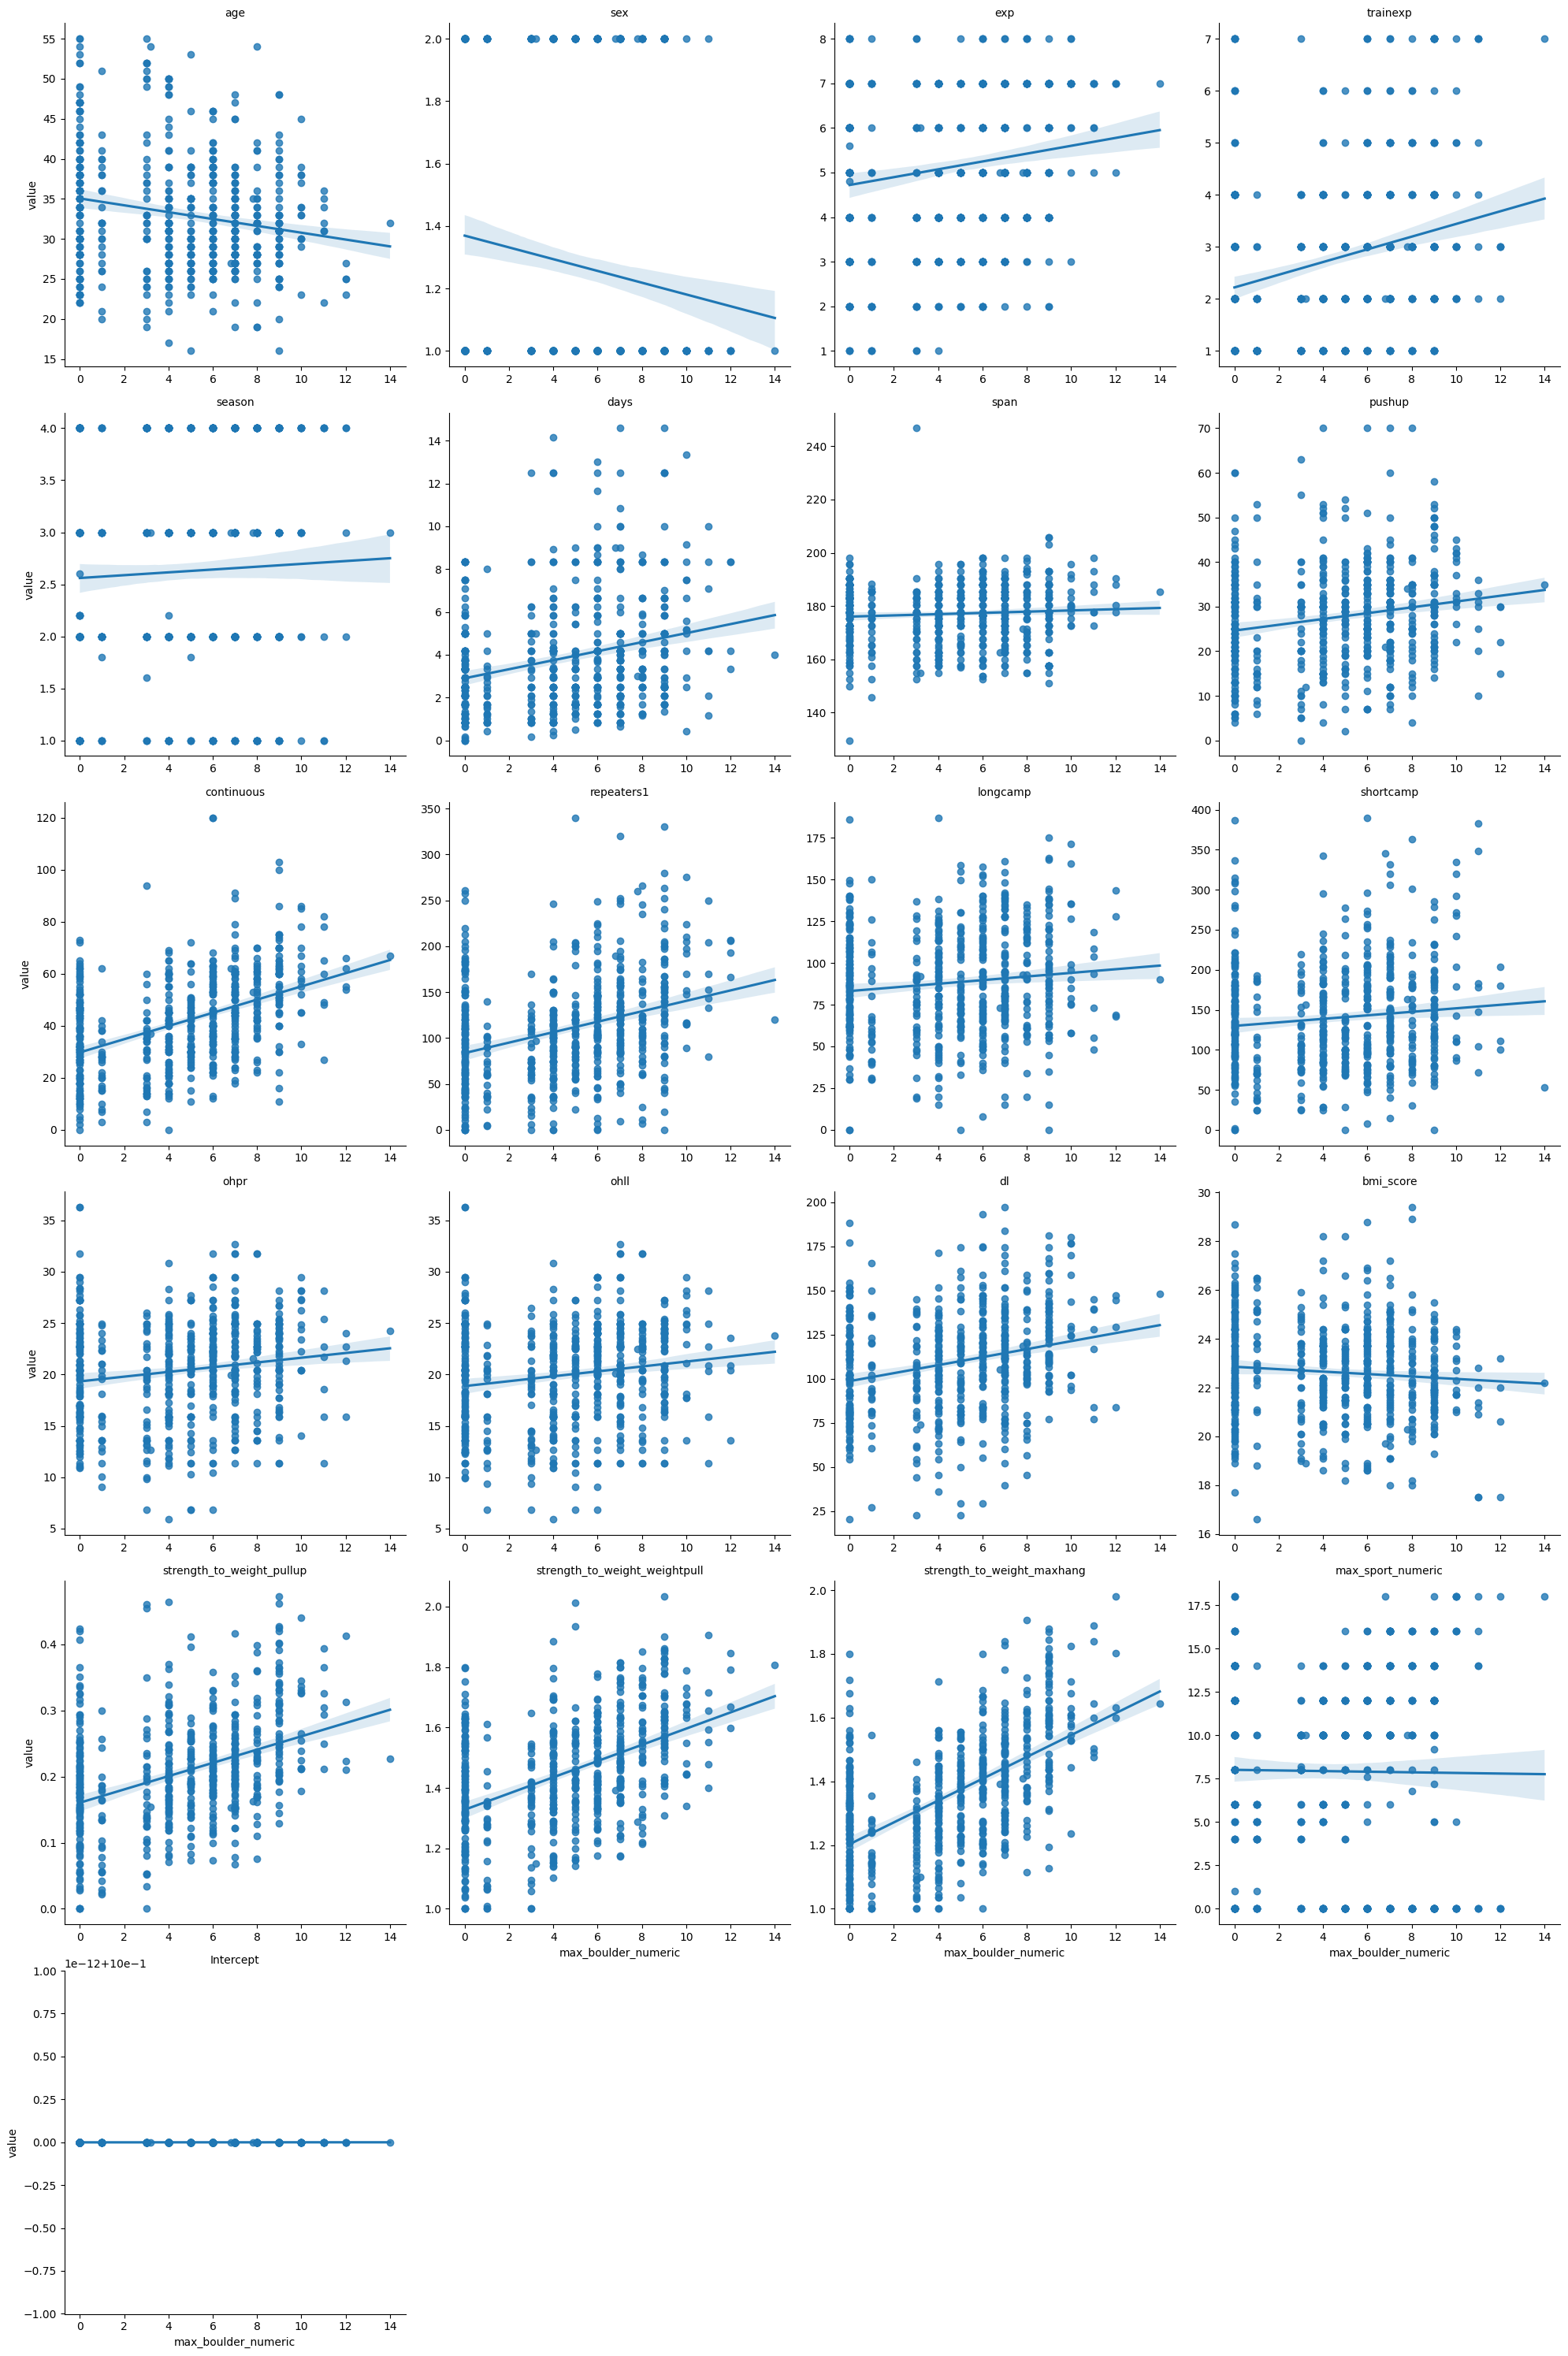

In [ ]:
X = data_imputed_clean

f = pd.melt(X, id_vars=['max_boulder_numeric'], value_vars=data_imputed_clean)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)
g = g.map(sns.regplot, "max_boulder_numeric", "value").set_titles("{col_name}")

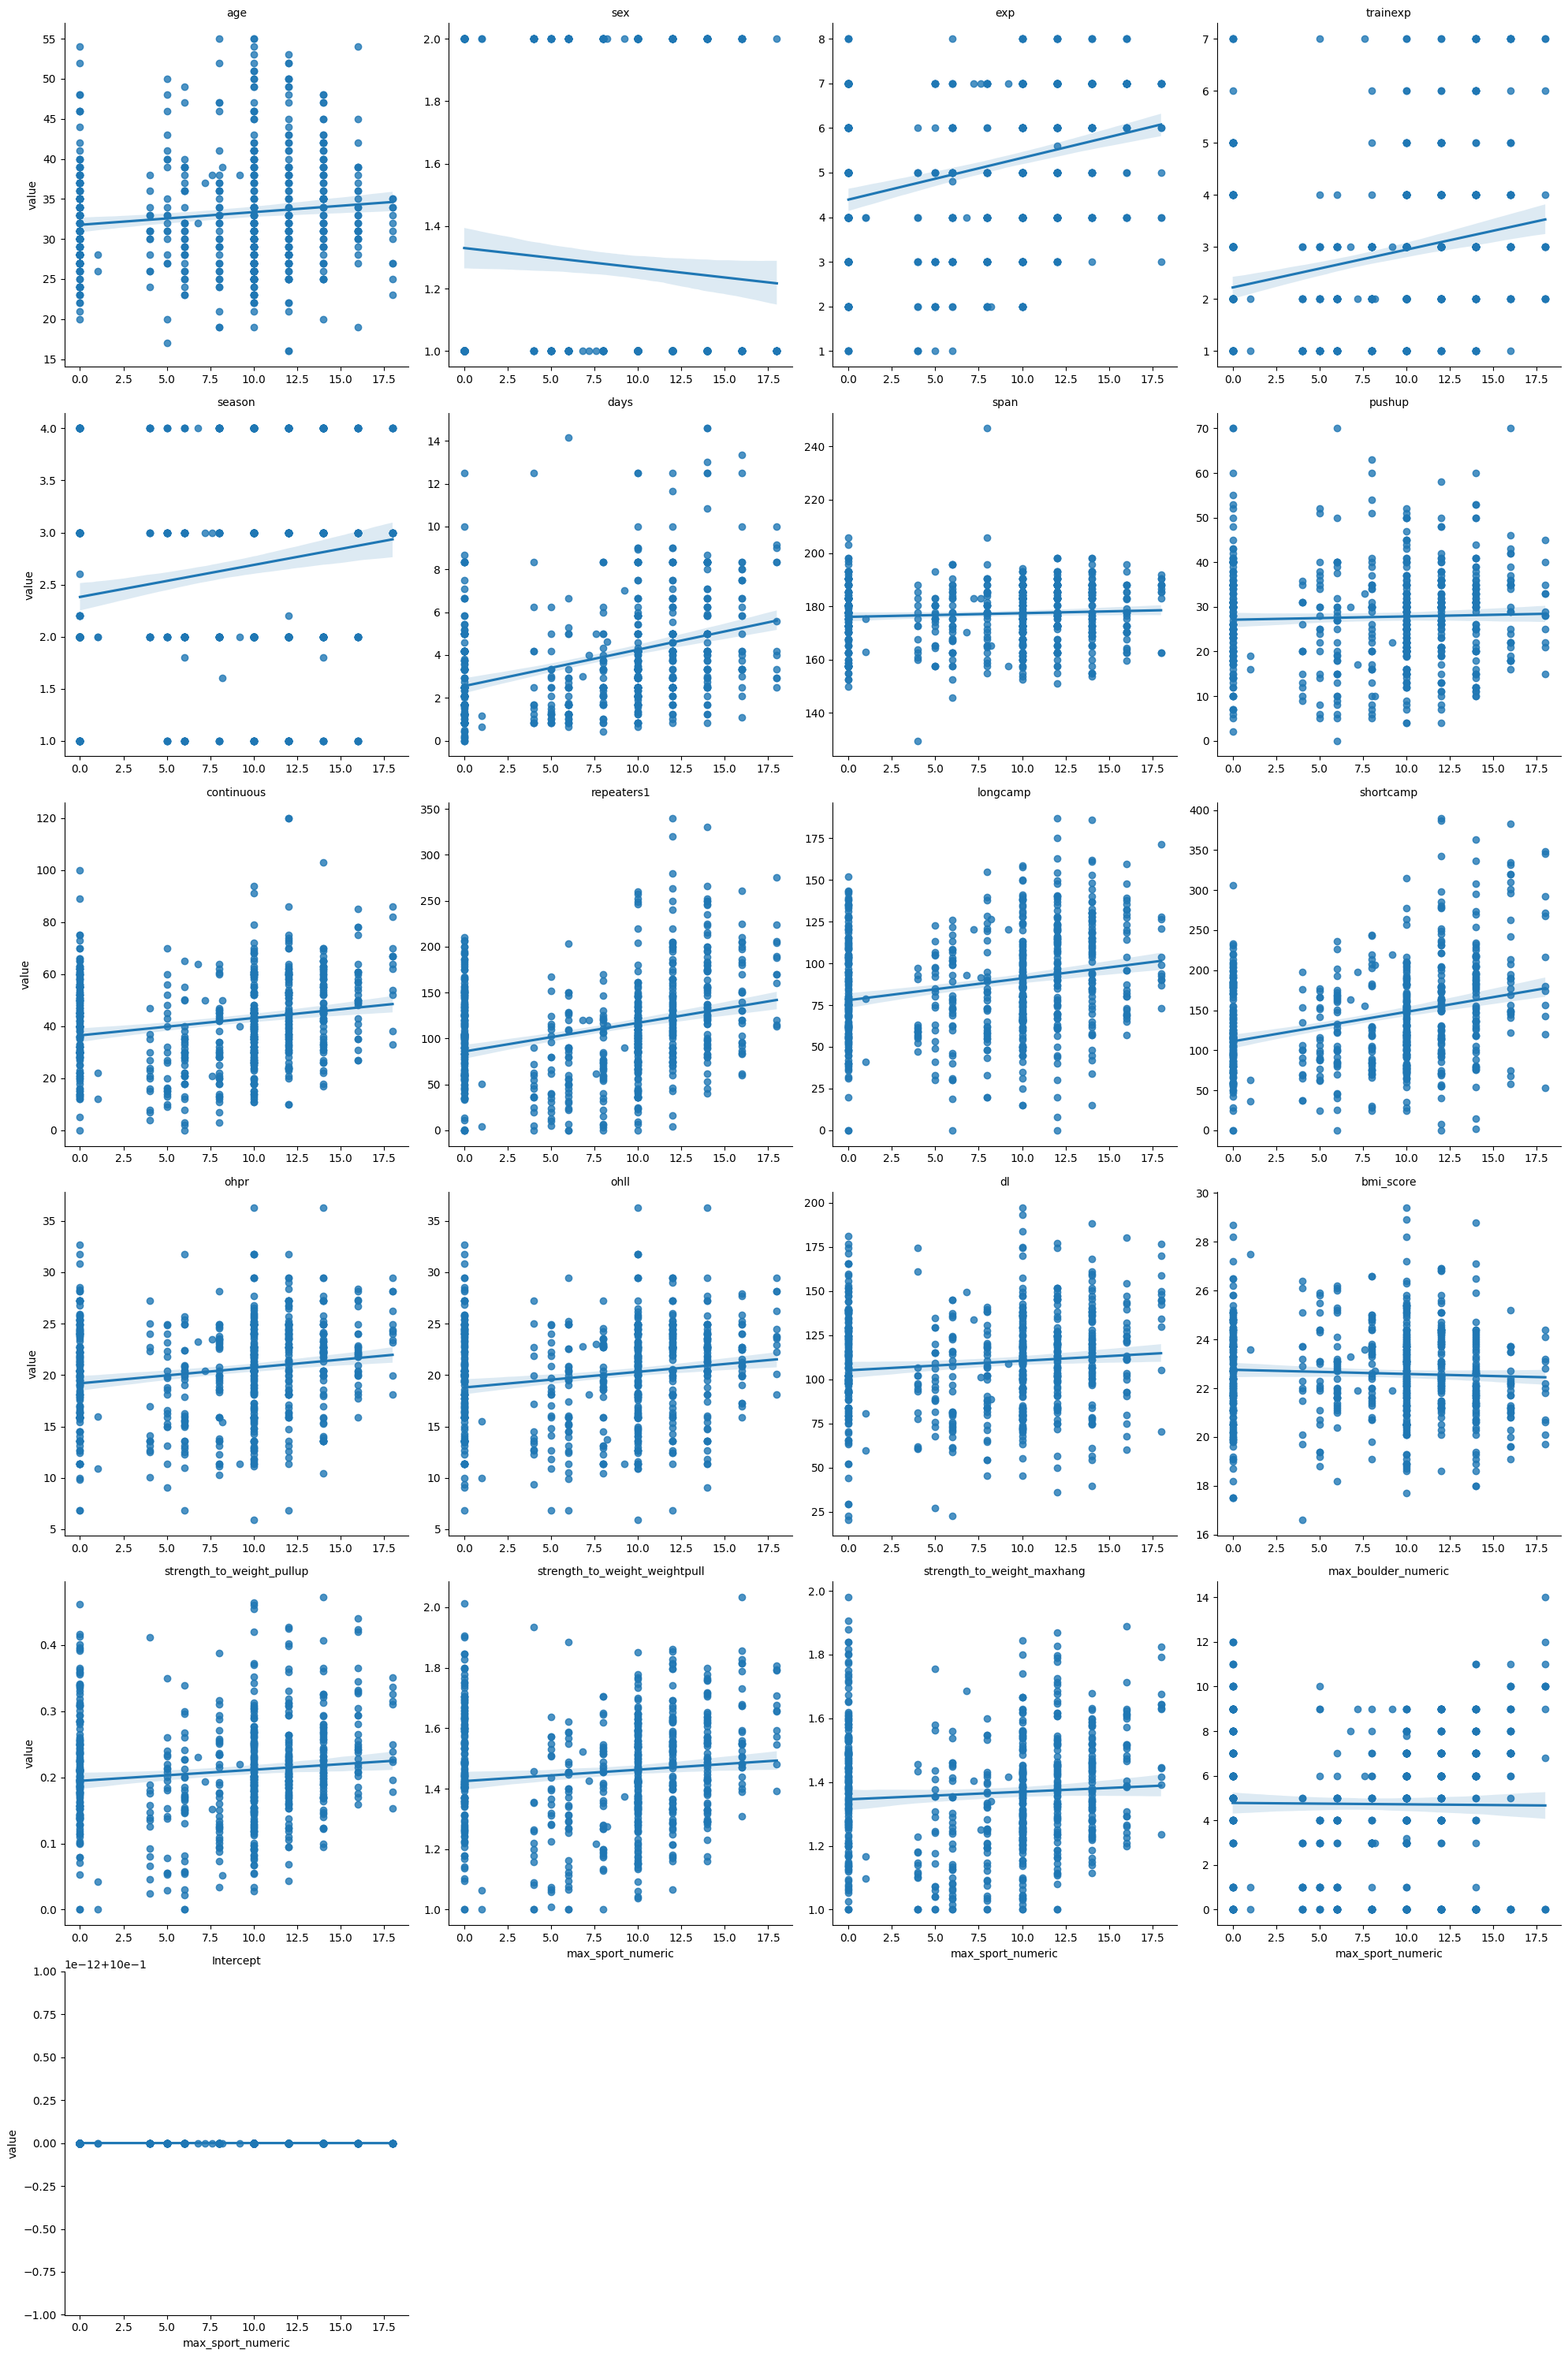

In [87]:
X = data_imputed_clean

f = pd.melt(X, id_vars=['max_sport_numeric'], value_vars=data_imputed_clean)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)
g = g.map(sns.regplot, "max_sport_numeric", "value").set_titles("{col_name}")

Since age, sex, and BMI tend to be a focus point when discussing climbing grades, it's worth exploring these in a little more detail to confirm the results above - that they don't actually matter that much.

In [88]:
# Define the age buckets
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
data_imputed_clean['age_group'] = pd.cut(data_imputed_clean['age'], bins=bins, labels=labels)

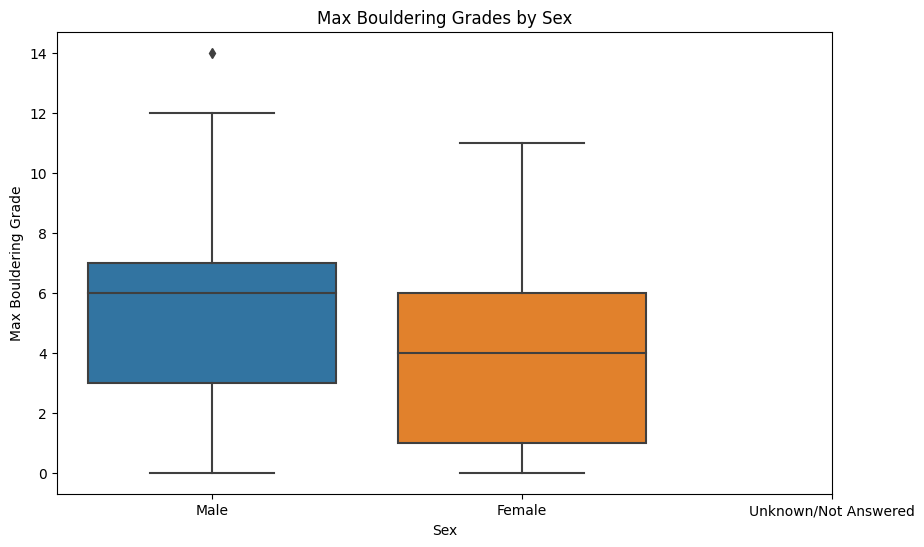

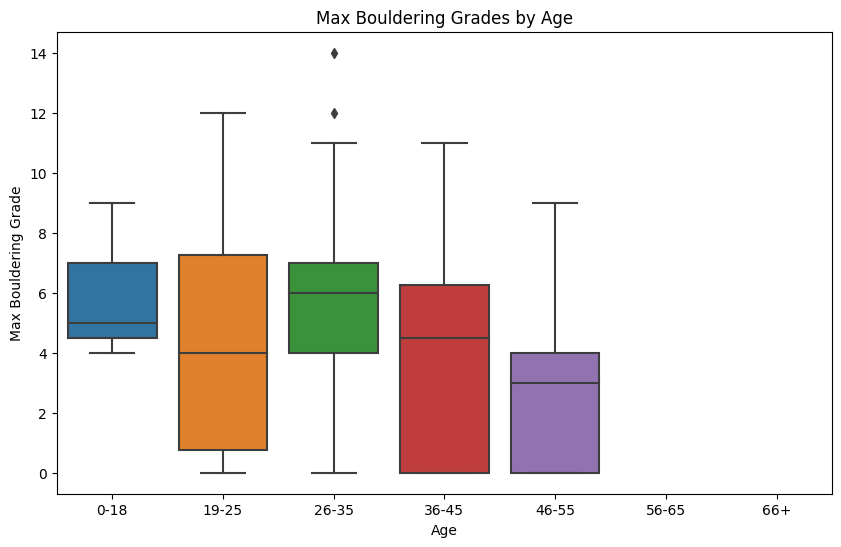

In [89]:
# Create a boxplot for max bouldering grades by sex
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='max_boulder_numeric', data=data_imputed_clean)
plt.title('Max Bouldering Grades by Sex')
plt.xlabel('Sex')
plt.ylabel('Max Bouldering Grade')
plt.xticks([0, 1, 2], ['Male', 'Female', 'Unknown/Not Answered'])
plt.show()

# Create a boxplot for max bouldering grades by age
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='max_boulder_numeric', data=data_imputed_clean)
plt.title('Max Bouldering Grades by Age')
plt.xlabel('Age')
plt.ylabel('Max Bouldering Grade')
plt.show()


In [91]:
# Summary statistics for max_boulder_numeric
summary_stats_sex = data_imputed_clean.groupby('sex')['max_boulder_numeric'].agg(['mean', 'std', 'count'])
print(summary_stats_sex)

# Summary statistics for max_boulder_numeric
summary_stats_age = data_imputed_clean.groupby('age_group')['max_boulder_numeric'].agg(['mean', 'std', 'count'])
print(summary_stats_age)

         mean       std  count
sex                           
1.0  5.009434  3.304829    424
2.0  4.023030  3.006936    165
               mean       std  count
age_group                           
0-18       6.000000  2.645751      3
19-25      4.544118  3.650532     68
26-35      5.306269  3.040474    335
36-45      4.080882  3.351186    136
46-55      2.727660  2.732868     47
56-65           NaN       NaN      0
66+             NaN       NaN      0


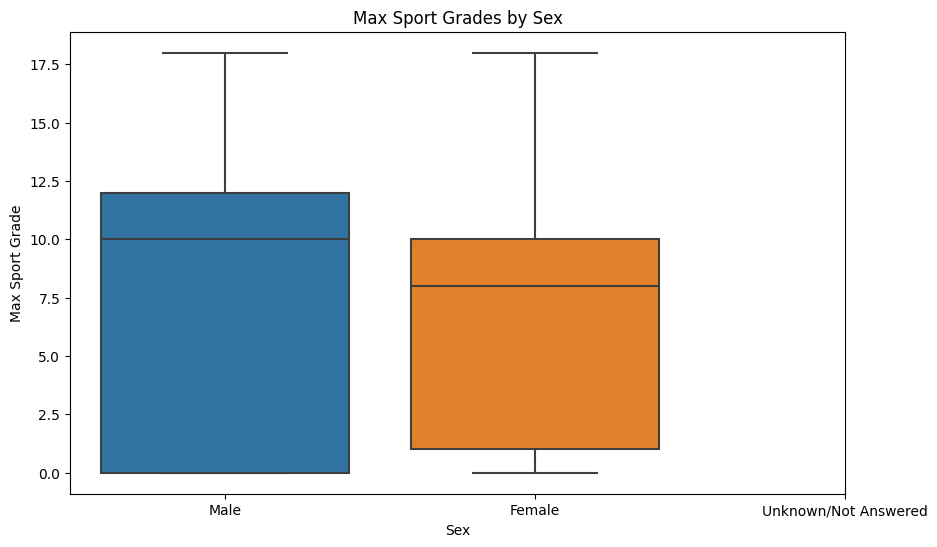

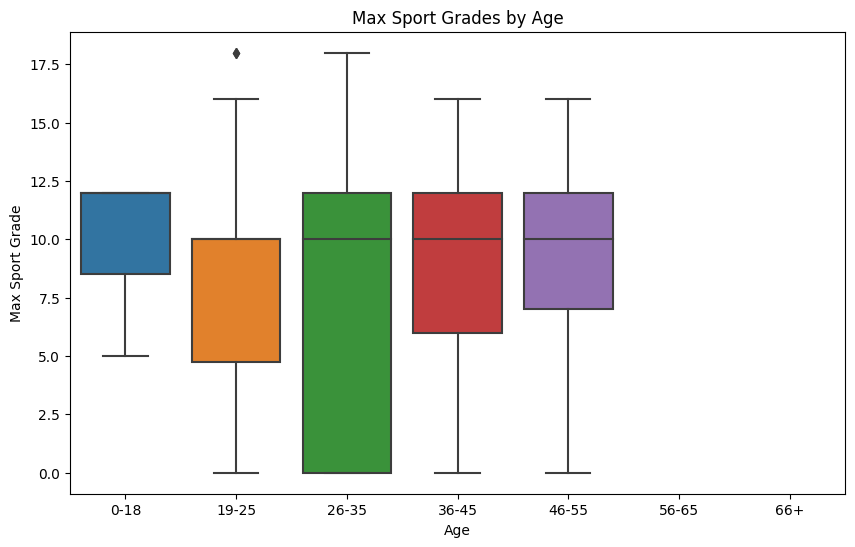

In [92]:
# Create a boxplot for max bouldering grades by sex
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='max_sport_numeric', data=data_imputed_clean)
plt.title('Max Sport Grades by Sex')
plt.xlabel('Sex')
plt.ylabel('Max Sport Grade')
plt.xticks([0, 1, 2], ['Male', 'Female', 'Unknown/Not Answered'])
plt.show()

# Create a boxplot for max bouldering grades by age
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='max_sport_numeric', data=data_imputed_clean)
plt.title('Max Sport Grades by Age')
plt.xlabel('Age')
plt.ylabel('Max Sport Grade')
plt.show()

In [93]:
# Summary statistics for max_sport_numeric
summary_stats_sex = data_imputed_clean.groupby('sex')['max_sport_numeric'].agg(['mean', 'std', 'count'])
print(summary_stats_sex)

# Summary statistics for max_sport_numeric
summary_stats_age = data_imputed_clean.groupby('age_group')['max_sport_numeric'].agg(['mean', 'std', 'count'])
print(summary_stats_age)

         mean       std  count
sex                           
1.0  8.187736  5.532046    424
2.0  7.263030  5.203695    165
               mean       std  count
age_group                           
0-18       9.666667  4.041452      3
19-25      7.838235  5.077343     68
26-35      7.474030  5.747627    335
36-45      8.788235  5.163104    136
46-55      8.702128  4.393250     47
56-65           NaN       NaN      0
66+             NaN       NaN      0


In [96]:
males_boulder = data_imputed_clean[data_imputed_clean['sex'] == 1]['max_boulder_numeric']
females_boulder = data_imputed_clean[data_imputed_clean['sex'] == 2]['max_boulder_numeric']

# Perform t-test
t_stat, p_value = ttest_ind(males_boulder, females_boulder)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 3.334084452842188, P-value: 0.000909736609016375


In [100]:
# Calculate means and standard deviations
mean_males_boulder = np.mean(males_boulder)
mean_females_boulder = np.mean(females_boulder)
std_males_boulder = np.std(males_boulder, ddof=1)
std_females_boulder = np.std(females_boulder, ddof=1)

# Calculate pooled standard deviation
n_males_boulder = len(males_boulder)
n_females_boulder = len(females_boulder)
pooled_std_boulder = np.sqrt(((n_males_boulder - 1) * std_males_boulder**2 + (n_females_boulder - 1) * std_females_boulder**2) / (n_males_boulder + n_females_boulder - 2))

# Calculate Cohen's d
cohen_d_boulder = (mean_males_boulder - mean_females_boulder) / pooled_std_boulder
print(f"Cohen's d: {cohen_d_boulder}")

Cohen's d: 0.3059210374293748


In [103]:
# Calculate the mean difference
mean_diff_boulder = mean_males_boulder - mean_females_boulder

# Standard error of the difference
se_diff_boulder = np.sqrt(std_males_boulder**2 / n_males_boulder + std_females_boulder**2 / n_females_boulder)

# Confidence interval for the mean difference
confidence_level = 0.95
df_boulder = n_males_boulder + n_females_boulder - 2
t_crit_boulder = stats.t.ppf((1 + confidence_level) / 2, df_boulder)
ci_low_boulder = mean_diff_boulder - t_crit_boulder * se_diff_boulder
ci_high_boulder = mean_diff_boulder + t_crit_boulder * se_diff_boulder
print(f"95% CI for mean difference: [{ci_low_boulder}, {ci_high_boulder}]")

95% CI for mean difference: [0.42896575986934904, 1.5438415585983472]


Bouldering and Sex: Comparing the performance of males and females using an independent t-test shows us that the difference is not statistically significant (t = 3.3, p < 0.05>), and the effect size was small to medium (Cohen's d = 0.31). The 95% confidence interval for the mean difference is 0.43 to 1.5, suggesting that there is some small difference between males and females and max boldering grades.Further investigation with a larger sample size may be warranted, but as it stands, the impact of being male or female is minimal.

In [101]:
males_sport = data_imputed_clean[data_imputed_clean['sex'] == 1]['max_sport_numeric']
females_sport = data_imputed_clean[data_imputed_clean['sex'] == 2]['max_sport_numeric']

# Perform t-test
t_stat, p_value = ttest_ind(males_sport, females_sport)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 1.8517737401785996, P-value: 0.06456026636600799


In [102]:
# Calculate means and standard deviations
mean_males_sport = np.mean(males_sport)
mean_females_sport = np.mean(females_sport)
std_males_sport = np.std(males_sport, ddof=1)
std_females_sport = np.std(females_sport, ddof=1)

# Calculate pooled standard deviation
n_males_sport = len(males_sport)
n_females_sport = len(females_sport)
pooled_std_sport = np.sqrt(((n_males_sport - 1) * std_males_sport**2 + (n_females_sport - 1) * std_females_sport**2) / (n_males_sport + n_females_sport - 2))

# Calculate Cohen's d
cohen_d_sport = (mean_males_sport - mean_females_sport) / pooled_std_sport
print(f"Cohen's d: {cohen_d_sport}")

Cohen's d: 0.1699106761368905


In [104]:
# Calculate the mean difference
mean_diff_sport = mean_males_sport - mean_females_sport

# Standard error of the difference
se_diff_sport = np.sqrt(std_males_sport**2 / n_males_sport + std_females_sport**2 / n_females_sport)

# Confidence interval for the mean difference
confidence_level = 0.95
df_sport = n_males_sport + n_females_sport - 2
t_crit_sport = stats.t.ppf((1 + confidence_level) / 2, df_sport)
ci_low_sport = mean_diff_sport - t_crit_sport * se_diff_sport
ci_high_sport = mean_diff_sport + t_crit_sport * se_diff_sport
print(f"95% CI for mean difference: [{ci_low_sport}, {ci_high_sport}]")

95% CI for mean difference: [-0.029994794342232955, 1.8794058863948313]


Sport climbing and Sex: Comparing the performance of males and females using an independent t-test shows us that the difference is not statistically significant (t = 1.85, p = 0.065), and the effect size was small (Cohen's d = 0.17). The 95% confidence interval for the mean difference included zero (-0.03 to 1.88), suggesting that the true difference could be negligible or slightly in favor of one group. While the results show us that there is no real difference in sport climbing performance between males and females, further investigation with a larger sample size may be warranted.

In [113]:

# ensure 'sex' is a categorical variable
data['sex'] = data['sex'].astype('category')
# Define the target variable
target = 'max_boulder_numeric'
# Get all predictor columns (exclude the target variable)
predictors = data.columns.drop(target)
# Create the formula dynamically
formula = "max_boulder_numeric ~ age + sex + exp + trainexp + season + days + span + pushup + continuous + repeaters1 + longcamp + shortcamp + ohpr + ohll + dl + bmi_score + strength_to_weight_pullup + strength_to_weight_weightpull + strength_to_weight_maxhang + max_sport_numeric"
model = smf.ols(formula, data=data).fit()
print(model.summary())
# Extract the coefficient and standard error for the sex variable
coeff_sex = model.params['sex[T.2.0]']
se_sex = model.bse['sex[T.2.0]']
# Calculate Cohen's d for the sex variable
pooled_sd = np.sqrt((se_sex ** 2 + se_sex ** 2) / 2)
cohens_d = coeff_sex / pooled_sd
print(f"Cohen's d for sex: {cohens_d}")


                             OLS Regression Results                            
Dep. Variable:     max_boulder_numeric   R-squared:                       0.466
Model:                             OLS   Adj. R-squared:                  0.447
Method:                  Least Squares   F-statistic:                     24.74
Date:                 Tue, 04 Mar 2025   Prob (F-statistic):           2.34e-64
Time:                         13:22:50   Log-Likelihood:                -1343.3
No. Observations:                  588   AIC:                             2729.
Df Residuals:                      567   BIC:                             2821.
Df Model:                           20                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Inte

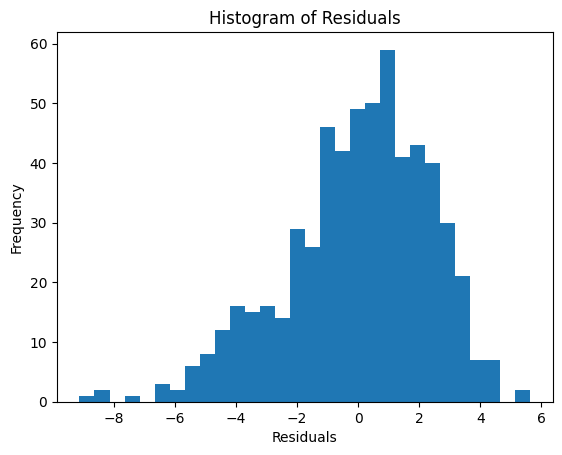

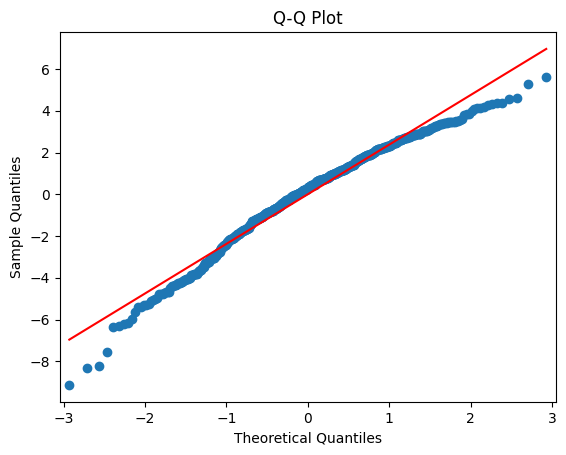

Shapiro-Wilk Test: Statistic=0.9740905165672302, p-value=1.0927315940989502e-08


In [114]:
# Histogram of residuals
plt.hist(model.resid, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot
sm.qqplot(model.resid, line='s')
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk test
from scipy import stats
shapiro_test = stats.shapiro(model.resid)
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')


In [51]:
# Breusch-Pagan test
import statsmodels.stats.api as sms

bp_test = sms.het_breuschpagan(model.resid, model.model.exog)
bp_test_results = {'Lagrange multiplier statistic': bp_test[0], 'p-value': bp_test[1], 'f-value': bp_test[2], 'f p-value': bp_test[3]}
print(bp_test_results)

{'Lagrange multiplier statistic': 23.170215496253444, 'p-value': 0.05755575353526076, 'f-value': 1.6839187092550483, 'f p-value': 0.055594454116821485}


In [115]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Number of bootstrap samples
n_bootstraps = 1000

# Storage for bootstrap results
bootstrap_results = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    # Resample with replacement
    bootstrap_sample = data_imputed_clean.sample(frac=1, replace=True)
    
    # Fit the model
    model = smf.ols(formula, data=bootstrap_sample).fit()
    
    # Store the coefficients
    bootstrap_results.append(model.params)

# Convert results to DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results)

# Calculate confidence intervals
conf_intervals = bootstrap_df.quantile([0.025, 0.975])


# print the results in a tabular format
print("Bootstrap Confidence Intervals:")
print(conf_intervals)




Bootstrap Confidence Intervals:
       Intercept  sex[T.2.0]       age       exp  trainexp    season  \
0.025 -16.496717   -1.075858 -0.114943  0.069170  0.014642 -0.312884   
0.975  -4.221074    0.416917 -0.046158  0.361836  0.364362  0.131619   

           days      span    pushup  continuous  ...  longcamp  shortcamp  \
0.025  0.233179 -0.002199 -0.028743   -0.002196  ... -0.015369  -0.005792   
0.975  0.396533  0.048749  0.020302    0.034586  ...  0.006817   0.006116   

           ohpr      ohll        dl  bmi_score  strength_to_weight_pullup  \
0.025 -0.359867 -0.285585 -0.001454  -0.088042                  -4.720301   
0.975  0.141282  0.202021  0.019269   0.148059                   4.378074   

       strength_to_weight_weightpull  strength_to_weight_maxhang  \
0.025                       1.415855                    3.997924   
0.975                       5.869924                    7.640733   

       max_sport_numeric  
0.025          -0.137583  
0.975          -0.051072  



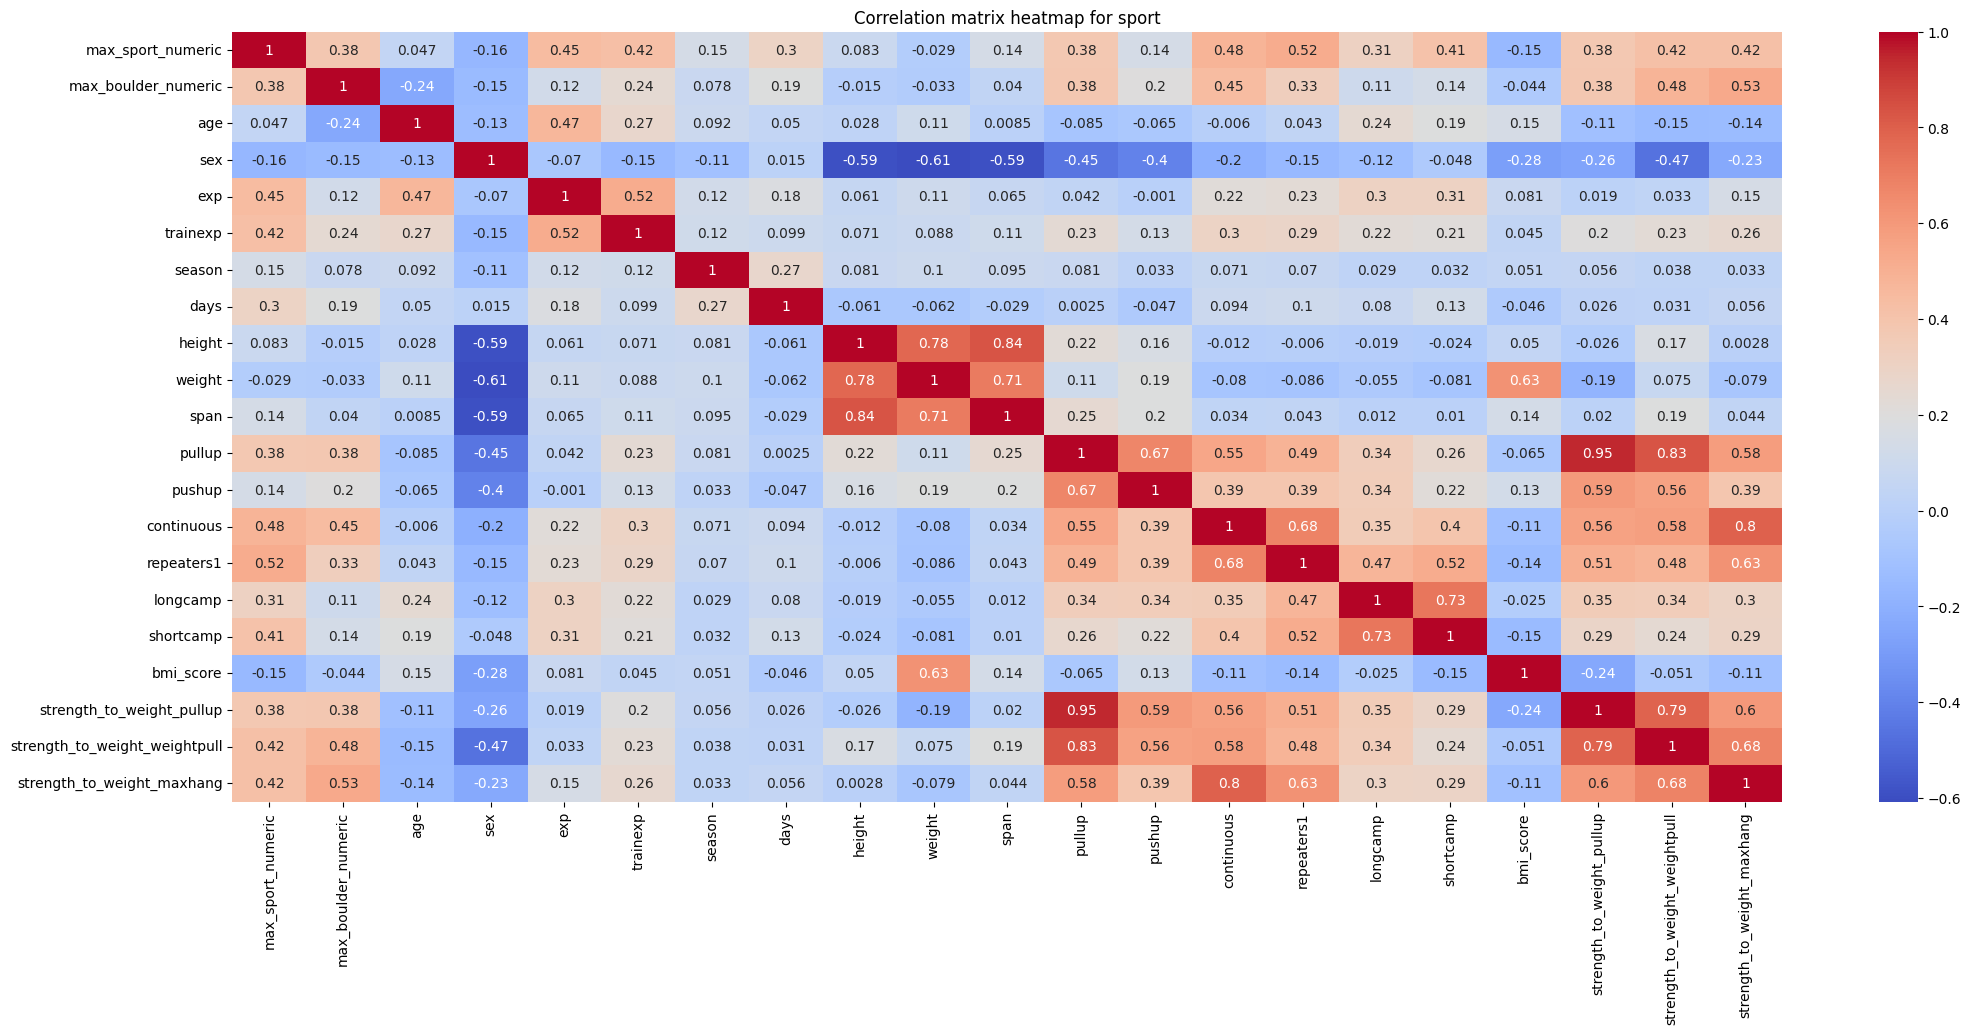

In [53]:
# calculate the correlation matrix for the specified columns in the sport data
corr = data_filtered_sport[[
    "max_sport_numeric", "max_boulder_numeric", "age", "sex", "exp", "trainexp",
    "season", "days", "height", "weight", "span", "pullup", "pushup", "continuous",
    "repeaters1", "longcamp", "shortcamp", "bmi_score", "strength_to_weight_pullup",
    "strength_to_weight_weightpull", "strength_to_weight_maxhang"
]].corr()

# create a new figure with a specified size
plt.figure(figsize=(25, 10))

# create a heatmap of the correlation matrix
# 'annot=True' makes the correlation values visible on the heatmap
# 'cmap' sets the color map to 'coolwarm', which is a diverging colormap
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.title("Correlation matrix heatmap for sport")
plt.show()

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each explanatory variable
X = all_feat_sport
X['Intercept'] = 1  # Add intercept for VIF calculation

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif.to_string(index=False))

                     Variable          VIF
                          age     1.603052
                          sex     2.639245
                       season     1.137541
                          exp     1.870917
                     trainexp     1.539323
                         days     1.157142
                       height    18.777389
                       weight    29.626148
                         span     3.702108
                       pullup   151.822974
                       pushup     2.113552
                   continuous     3.467691
                      maxhang   115.432830
                 weightedpull   234.985726
                   repeaters1     2.413669
                     longcamp     2.770750
                    shortcamp     2.706903
                    bmi_score    10.494549
    strength_to_weight_pullup   153.213446
strength_to_weight_weightpull   220.212521
   strength_to_weight_maxhang   118.879792
                    Intercept 11783.603032


In [55]:

# Calculate VIF for each explanatory variable
X = all_feat_sport.drop(columns=['height', 'weight', 'pullup', 'maxhang', 'weightedpull'])
X['Intercept'] = 1  # Add intercept for VIF calculation

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif.to_string(index=False))

                     Variable         VIF
                          age    1.596563
                          sex    2.359500
                       season    1.120016
                          exp    1.825015
                     trainexp    1.512003
                         days    1.134767
                         span    1.674074
                       pushup    1.996563
                   continuous    3.425168
                   repeaters1    2.372054
                     longcamp    2.516869
                    shortcamp    2.480360
                    bmi_score    1.403451
    strength_to_weight_pullup    3.893467
strength_to_weight_weightpull    4.362862
   strength_to_weight_maxhang    3.752804
                    Intercept 1066.585247


Text(0.5, 0.98, 'Max Sport')

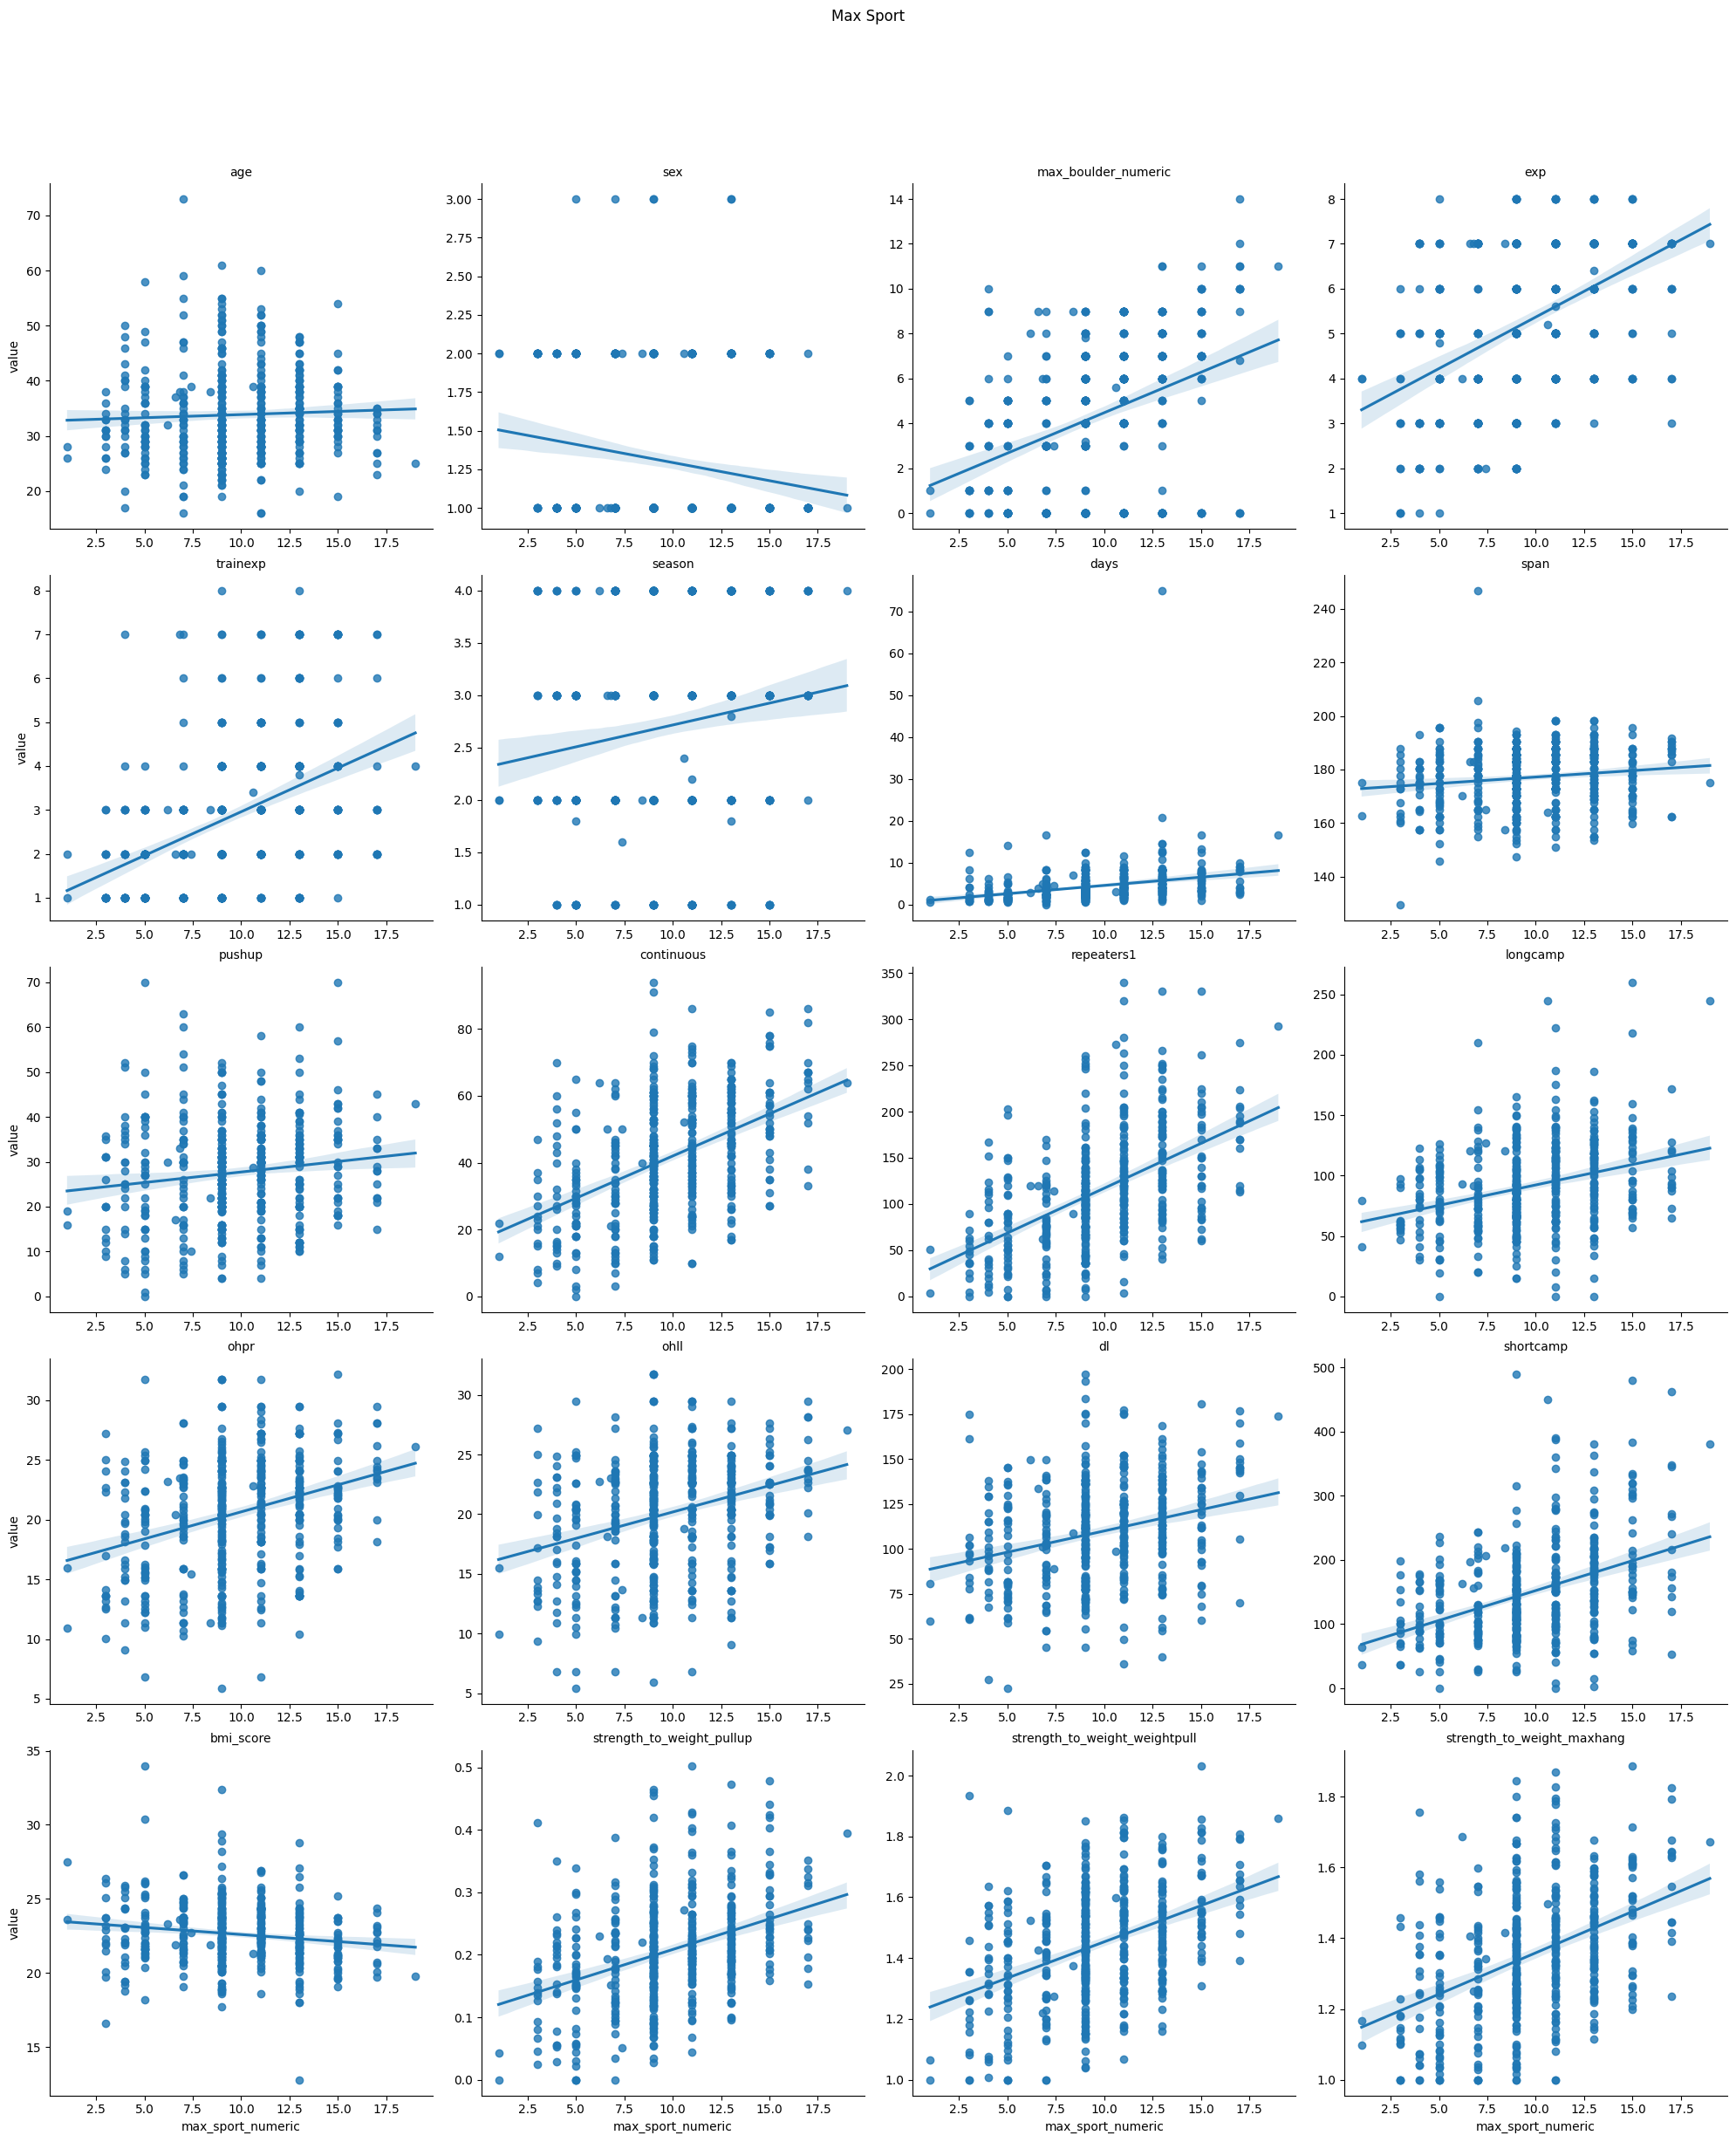

In [56]:
X = data_filtered_sport

# melt the DataFrame, keeping 'max_boulder_numeric' fixed and converting the columns in 'all_feat_sport' into a single column
f = pd.melt(X, id_vars=['max_sport_numeric'], value_vars=data_filtered_sport.drop(columns=['height', 'weight', 'pullup', 'maxhang', 'weightedpull']))

# create a FacetGrid object with a subplot for each feature in 'all_feat_sport'
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)

# map a regplot to each subplot, plotting 'max_boulder_numeric' against the feature values
g = g.map(sns.regplot, "max_sport_numeric", "value").set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Max Sport')

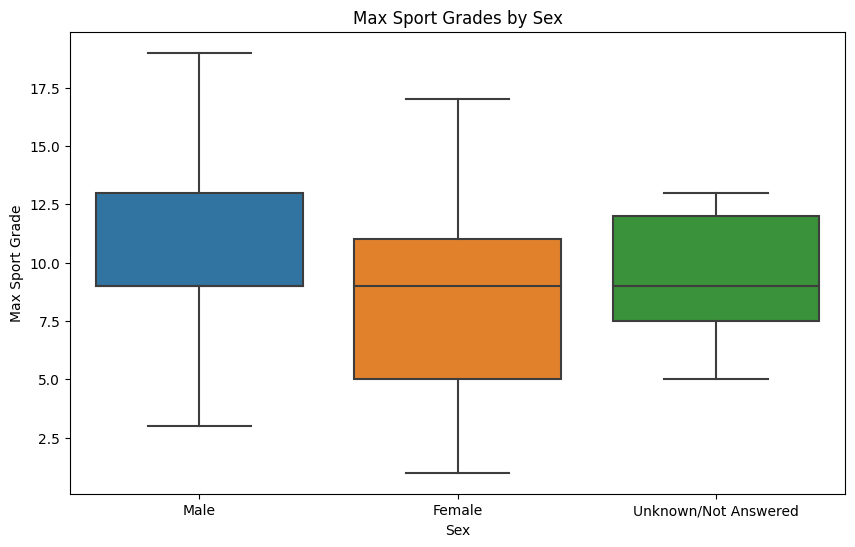

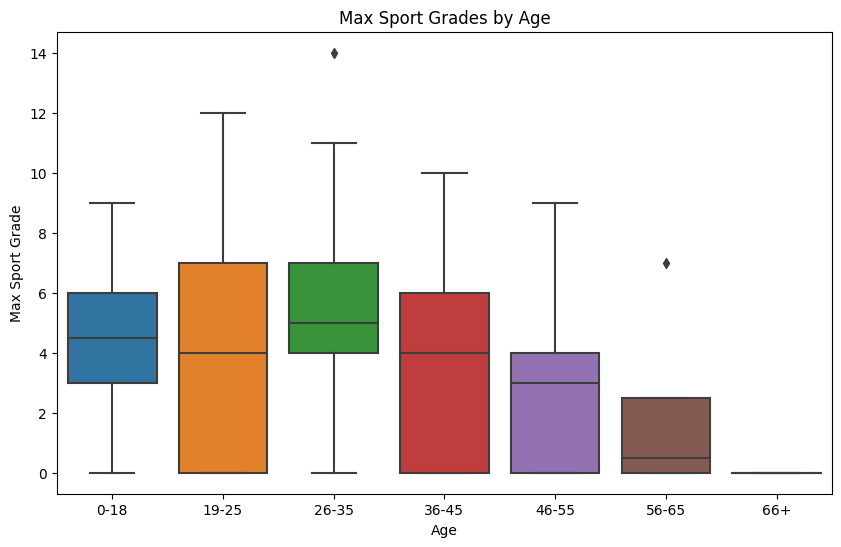

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot for max bouldering grades by sex
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex', y='max_sport_numeric', data=data_filtered_sport)
plt.title('Max Sport Grades by Sex')
plt.xlabel('Sex')
plt.ylabel('Max Sport Grade')
plt.xticks([0, 1, 2], ['Male', 'Female', 'Unknown/Not Answered'])
plt.show()


import pandas as pd

# Define the age buckets
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']

# Add age buckets to the dataset
data_filtered_sport['age_group'] = pd.cut(data_filtered_sport['age'], bins=bins, labels=labels)


# Create a boxplot for max bouldering grades by age
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='max_boulder_numeric', data=data_filtered_sport)
plt.title('Max Sport Grades by Age')
plt.xlabel('Age')
plt.ylabel('Max Sport Grade')
plt.show()


In [58]:
# Summary statistics for max_boulder_numeric by sex
summary_stats = data_filtered_sport.groupby('sex')['max_boulder_numeric'].agg(['mean', 'std', 'count'])
print(summary_stats)

         mean       std  count
sex                           
1.0  4.666667  3.287322    330
2.0  3.510937  2.873809    128
3.0  4.500000  2.738613      6


In [59]:
from scipy.stats import ttest_ind
# Subset the data
males = data_filtered_sport[data_filtered_sport['sex'] == 1]['max_sport_numeric']
females = data_filtered_sport[data_filtered_sport['sex'] == 2]['max_sport_numeric']

# Perform t-test
t_stat, p_value = ttest_ind(males, females)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 3.776089775491654, P-value: 0.00018038517384423122


In [60]:
import numpy as np

# Calculate means and standard deviations
mean_males = np.mean(males)
mean_females = np.mean(females)
std_males = np.std(males, ddof=1)
std_females = np.std(females, ddof=1)

# Calculate pooled standard deviation
n_males = len(males)
n_females = len(females)
pooled_std = np.sqrt(((n_males - 1) * std_males**2 + (n_females - 1) * std_females**2) / (n_males + n_females - 2))

# Calculate Cohen's d
cohen_d = (mean_males - mean_females) / pooled_std
print(f"Cohen's d: {cohen_d}")

Cohen's d: 0.39319962522784113


In [61]:
import scipy.stats as stats

# Calculate the mean difference
mean_diff = mean_males - mean_females

# Standard error of the difference
se_diff = np.sqrt(std_males**2 / n_males + std_females**2 / n_females)

# Confidence interval for the mean difference
confidence_level = 0.95
df = n_males + n_females - 2
t_crit = stats.t.ppf((1 + confidence_level) / 2, df)
ci_low = mean_diff - t_crit * se_diff
ci_high = mean_diff + t_crit * se_diff
print(f"95% CI for mean difference: [{ci_low}, {ci_high}]")

95% CI for mean difference: [0.6051322894456878, 2.02236771055431]


In [62]:
# Summary statistics for max_boulder_numeric by sex
summary_stats = data_filtered_sport.groupby('age_group')['max_sport_numeric'].agg(['mean', 'std', 'count'])
print(summary_stats)

               mean       std  count
age_group                           
0-18       8.250000  3.403430      4
19-25      9.396226  3.200599     53
26-35      9.672951  3.619984    244
36-45      9.972174  3.250359    115
46-55      9.302326  2.577696     43
56-65      8.000000  2.581989      4
66+        7.000000       NaN      1


In [63]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

# Load your dataset
data = data_filtered_sport.drop(columns=['height', 'weight', 'pullup', 'maxhang', 'weightedpull'])

# Ensure 'sex' is a categorical variable
data['sex'] = data['sex'].astype('category')

# Define the formula for ANCOVA
formula = 'max_sport_numeric ~ age + sex + exp + span + pushup + continuous + repeaters1 + longcamp + shortcamp + bmi_score + strength_to_weight_pullup + strength_to_weight_weightpull + strength_to_weight_maxhang'

# Fit the model
model = smf.ols(formula, data=data).fit()

# Display the summary of the model
print(model.summary())

# Extract the coefficient and standard error for the sex variable
coeff_sex = model.params['sex[T.2.0]']
se_sex = model.bse['sex[T.2.0]']

# Calculate Cohen's d for the sex variable
pooled_sd = np.sqrt((se_sex ** 2 + se_sex ** 2) / 2)
cohens_d = coeff_sex / pooled_sd
print(f"Cohen's d for sex: {cohens_d}")

# Obtain the 95% confidence intervals for the coefficients
conf_intervals = model.conf_int()
conf_intervals.columns = ['2.5%', '97.5%']
print("95% Confidence Intervals for OLS Coefficients:\n", conf_intervals)


                            OLS Regression Results                            
Dep. Variable:      max_sport_numeric   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     33.04
Date:                Fri, 06 Sep 2024   Prob (F-statistic):           3.14e-60
Time:                        10:41:06   Log-Likelihood:                -1059.2
No. Observations:                 464   AIC:                             2148.
Df Residuals:                     449   BIC:                             2211.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [64]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Number of bootstrap samples
n_bootstraps = 1000

# Storage for bootstrap results
bootstrap_results = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    # Resample with replacement
    bootstrap_sample = data_filtered_sport.sample(frac=1, replace=True)
    
    # Fit the model
    model = smf.ols(formula, data=bootstrap_sample).fit()
    
    # Store the coefficients
    bootstrap_results.append(model.params)

# Convert results to DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results)

# Calculate confidence intervals
conf_intervals = bootstrap_df.quantile([0.025, 0.975])


# print the results in a tabular format
print("Bootstrap Confidence Intervals:")
print(conf_intervals)

Bootstrap Confidence Intervals:
       Intercept       age       sex       exp      span    pushup  \
0.025  -7.902813 -0.088031 -0.717864  0.611677  0.006399 -0.089283   
0.975   5.395774 -0.024309  0.559302  0.929730  0.052186 -0.031996   

       continuous  repeaters1  longcamp  shortcamp  bmi_score  \
0.025    0.005783    0.008618 -0.017837   0.002659   -0.21713   
0.975    0.057429    0.019167  0.000788   0.011988    0.02456   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
0.025                  -1.709688                       2.610048   
0.975                   8.598163                       7.711939   

       strength_to_weight_maxhang  
0.025                   -5.145075  
0.975                   -0.598983  


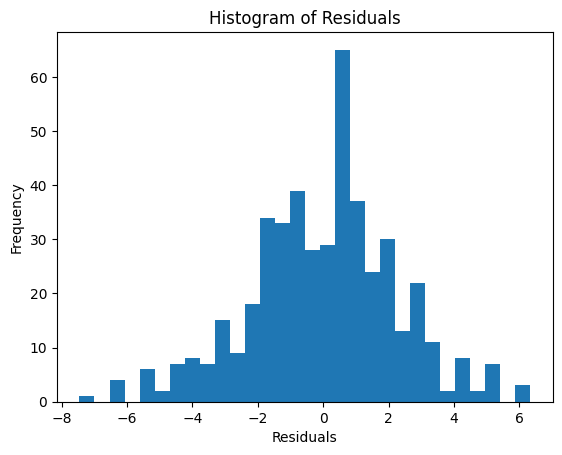

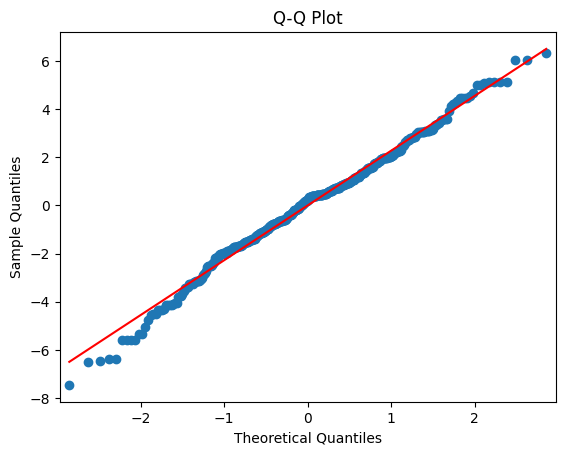

Shapiro-Wilk Test: Statistic=0.9914695620536804, p-value=0.009030385874211788


In [65]:
# Histogram of residuals
plt.hist(model.resid, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot
sm.qqplot(model.resid, line='s')
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk test
from scipy import stats
shapiro_test = stats.shapiro(model.resid)
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')


In [66]:
# Breusch-Pagan test
import statsmodels.stats.api as sms

bp_test = sms.het_breuschpagan(model.resid, model.model.exog)
bp_test_results = {'Lagrange multiplier statistic': bp_test[0], 'p-value': bp_test[1], 'f-value': bp_test[2], 'f p-value': bp_test[3]}
print(bp_test_results)

{'Lagrange multiplier statistic': 19.465176789211164, 'p-value': 0.10937182054317147, 'f-value': 1.515729580639633, 'f p-value': 0.1078563494954449}


For max bouldering, it doesn't seem like there is a significant difference between males (1) and females (2) when it comes to max bouldering grades - although we should note that males tend to have a higher max grade.

In the below ANCOVA model, sex has a very low p-value (close to 0), indicating it is highly statistically significant. It suggests that the sex variable significantly affects max_sport_numeric.Continuous, maxhang, weightedpull, repeaters1, and shortcamp have lower p-values, suggesting some level of significance, but not as strong as the sex. Strength_to_weight_pullup, strength_to_weight_weightpull, and strength_to_weight_maxhang have high p-values, indicating that they are not statistically significant predictors of max_sport_numeric.

Again, as above, I decided to use domain expertise and the results of the rest of the analysis when thinking about these results. Sex could very well have an important role to play when predicting max sport climbing grade, so I will analyse that one further with a box plot. I am not convinced about the rest of the features though like strength to weight pullup/weightedpullups/maxhangs - I know from experience and other similar analyses that these features do play a role, and usually quite an important one.

Results are slightly different to the max bouldering grade vs sex box plots, so we could argue that sex does play a role in predicting max sport grade. I am choosing to keep this as information rather than incorporating it into the model for a number of reasons, but mainly that I would prefer not to ask for gender on the applet when asking individuals to provide their actual climbing values.

The graphs above are another way of representing the relationships between each feature and the max bouldering/sport climbing grades. The trend lines are calculated using regression, which attempts to draw a straight line to indicate the relationship between the variable the max_sport/bouldering_grade. 

There are some features which are not suitable for this type of plotting (e.g. season and sex) however I have included them to avoid creating multiple filters of my dataset. For other features where we do expect to see some type of relationship, it's clear where the relationship is neutral, slightly positive, or highly positive (e.g. strength to weight maxhang is highly positive when looking at both sport and bouldering max grades)


Using all the methods above we can validate which metrics to include in our ML models for sport and bouldering.

![Silence](https://www.lacrux.com/wp-content/uploads/2018/04/Warum-Adam-Ondra-Silence-mit-9c-bewertete-1024x444.jpg)

In the following section I am testing out 3 different models to try and find the one that most accurately predicts bouldering and sport max grade. I will be using a linear regression model, gradient boosting model, and random forest model.

**Model Information**

For information (I didn't know much about these before and want to keep the notes here for future reference):

Linear Regression: Linear regression models are one of the simplest types of predictive models. They model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. The steps to obtain the equation are deterministic, meaning that you'll get the same model each time you run a linear regression with the same data and the same settings. Linear regression models are interpretable, but they can oversimplify real-world problems by assuming a linear relationship between variables.

Gradient Boosting: Gradient boosting models are a type of ensemble learning model. They combine the predictions of multiple "weak" models to make a final prediction. In the case of gradient boosting, the models (often decision trees) are built sequentially. Each new model attempts to correct the errors made by the previous models. This is achieved by fitting the new model to the residuals (i.e., the differences between the predicted and true values) of the previous model, hence "gradient" (referring to the direction of steepest descent towards minimizing error) and "boosting" (referring to the combination of many models). Gradient boosting models often have high predictive accuracy, but they can be prone to overfitting and are less interpretable than linear regression models.

Random Forest: Random forest models are another type of ensemble learning model. Like gradient boosting, they combine the predictions of multiple models (in this case, decision trees), but the trees are built in parallel rather than sequentially. In a random forest, each tree is trained on a random subset of the data, and each split in each tree is chosen from a random subset of the features. This randomness helps to make the model robust to overfitting. Random forest models are typically less prone to overfitting than gradient boosting models, and they also provide measures of feature importance, which can be useful for interpretation.

In summary, linear regression models are simple and interpretable but can oversimplify complex relationships. Gradient boosting and random forest models can capture more complex relationships and often have higher predictive accuracy, but they can be prone to overfitting (particularly gradient boosting) and are less interpretable. The best model to use depends on the specifics of the data and the analytical goals.

I will also be looking at feature importance and SHAP values. 

**Feature Importance**

Feature importance in machine learning provides a score that indicates how useful or valuable each feature was in the construction of the machine learning model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

Here are brief explanations of feature importance in the context of the three models I have used:

Linear Regression: In linear regression, the coefficient size can often be used as an indication of feature importance. A larger coefficient means that the feature has a stronger impact on the prediction. However, it's important to note that this interpretation assumes that all features have been appropriately scaled to the same range (e.g., -1 to 1).

Random Forest: In a random forest model, feature importance is usually calculated by looking at how much the tree nodes that use that feature reduce impurity across all trees in the forest. It computes this score automatically for each feature after training and scales the results so that the sum of all importances is equal to 1.

Gradient Boosting: Like a random forest, gradient boosting provides a feature importance score based on the reduction of the criterion used to split the nodes (like Gini or entropy for classification, variance for regression). However, since gradient boosting involves creating trees in a serial manner where each new tree helps to correct errors made by previously trained trees, the feature importance calculation can be slightly different. There's also a method to compute feature importance by "permutation", where the model's performance is assessed with each feature's values randomly shuffled - a large decrease in performance indicates high feature importance.

**SHAP Values**

SHAP (SHapley Additive exPlanations) values interpret the impact of having a certain value for a given feature in comparison to the prediction we would make if that feature took some baseline value.

Here are some insights you can get from SHAP values:

Feature Importance: Features with larger SHAP values (either positive or negative) are more important in the model's decision-making process. This can help you understand which features are driving the predictions.

Effect of Feature Values: Positive SHAP values for a given feature indicate that the high values of that feature increase the prediction, while negative SHAP values mean that high values of that feature decrease the prediction. In other words, if a feature has a positive SHAP value, it means it's pushing the model's output higher than the base value, and vice versa for a negative SHAP value.

**Feedback loop**

Following the launch of the applet on Streamlit, I have been collecting user data which I will be using to re-train and improve the models periodically. Users are asked to input their actual max sport and bouldering grades, alongside their strength metrics. This data is then sent to and stored in MongoDB, from where I access it. 

Below, I am importing that data, applying the conversion mappings for bouldering and sport grades, and then imputing any 0 values (e.g. some users input a max bouldering grade but not a max sport grade). This cleaned and updated data will be joined on to the data used in the models.


In [67]:
# # import csv file of new data from mongo db
# new_data_mongodb = pd.read_csv(r"training_data/new_feedback.csv")

In [68]:
# # rename actual_bouldering_grade and actual_sport_grade in new_data_mongodb
# new_data_mongodb.rename(columns={'actual_bouldering_grade': 'max_boulder_grade', 'actual_sport_grade': 'max_sport_grade'}, inplace=True)

In [69]:

# # map the French grades to numerical values
# new_data_mongodb['max_sport_numeric'] = new_data_mongodb['max_sport_grade'].map(conversion_map_french)
# # apply the conversion function to the 'max_boulder' column to create a new column of numeric V grades
# new_data_mongodb['max_boulder_numeric'] = new_data_mongodb['max_boulder_grade'].apply(convert_v_grade_to_numeric)

In [70]:
# print(new_data_mongodb.columns)  # print the dataframe to confirm the columns

In [71]:
# # drop the max_sport_grade and max_boulder_grade columns
# new_data_mongodb = new_data_mongodb.drop(columns=["_id","max_sport_grade", "max_boulder_grade", "predicted_bouldering_grade", "predicted_sport_grade"])
# print(new_data_mongodb.columns)  # print the dataframe to confirm the columns have been dropped

In [72]:
# # replace all NaNs with 0s in the new_data_mongodb dataframe
# new_data_mongodb = new_data_mongodb.fillna(0)
# # print any rows which contan NaNs
# print(new_data_mongodb[new_data_mongodb.isna().any(axis=1)])

In [73]:
# # impute 0s in new_data_mongo_db
# # store column names before imputation
# column_names = new_data_mongodb.columns
# # perform imputation
# new_data_mongodb_imputed = knn_imputer.fit_transform(new_data_mongodb)
# # convert the result back to a DataFrame
# new_data_mongodb = pd.DataFrame(new_data_mongodb_imputed, columns=column_names)

In [74]:
# define the independent variables for bouldering which we want to use in the models
# exclude highly correlated variables like pullup and strength_to_weight_pullup since one is based on the other
independent_vars_bouldering = ['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','exp','continuous','repeaters1']
#'days']

In [75]:
# define the independent variables for sport which we want to use in the models
# exclude highly correlated variableslike pullup and strength_to_weight_pullup since one is based on the other
independent_vars_sport = ['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','exp','continuous','repeaters1']
                          #'days']

In [76]:
# # Concatenate the new data with the existing bouldering and sport datasets
# data_filtered_bouldering = pd.concat([data_filtered_bouldering, new_data_mongodb], axis=0, ignore_index=True)
# data_filtered_sport = pd.concat([data_filtered_sport, new_data_mongodb], axis=0, ignore_index=True)

In [77]:
# # check how many rows we have and compare against the original dataset (pre mongo db import)
# print(len(data_filtered_bouldering))
# print(len(data_filtered_sport))

In [78]:
# # save in training data folder
# training_dir = 'training_data'

# # create the directory if it does not exist
# if not os.path.exists(training_dir):
#     os.makedirs(training_dir)

# # Save the files in the training data folder
# data_filtered_bouldering.to_csv(os.path.join(training_dir, 'data_filtered_bouldering.csv'))
# data_filtered_sport.to_csv(os.path.join(training_dir, 'data_filtered_sport.csv'))

In [79]:
# # final check: show NaN values in the bouldering and sport datasets we are using to train the models
# print(data_filtered_bouldering[independent_vars_bouldering].isna().sum())
# print(data_filtered_sport[independent_vars_sport].isna().sum())

In [80]:
# define the personal variables in each of the [] brackets for bouldering
# this is used to predict a user's max bouldering grade
new_data_bouldering = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [1.8], 
     'strength_to_weight_weightpull': [1.7],
     'exp': [6],
    'continuous':[31],
     'repeaters1':[150]
})


In [81]:
# define the personal variables in each of the [] brackets for sport climbing
# this is used to predict a user's max sport grade
new_data_sport = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [1.8], 
     'strength_to_weight_weightpull': [3.8],
     'exp': [4],
    'continuous':[60],
     'repeaters1':[80]
})

In [82]:
# from interpret import set_visualize_provider
# from interpret.provider import InlineProvider
# set_visualize_provider(InlineProvider())

In [84]:
data_filtered_bouldering[independent_vars_bouldering].describe()

strength_to_weight_pullup  strength_to_weight_maxhang  \
count                 491.000000                  491.000000   
mean                    0.216227                    1.395880   
std                     0.082913                    0.195356   
min                     0.000000                    1.000000   
25%                     0.164961                    1.250000   
50%                     0.208722                    1.392857   
75%                     0.261181                    1.527397   
max                     0.472419                    1.979730   

       strength_to_weight_weightpull         exp  continuous  repeaters1  
count                     491.000000  491.000000  491.000000  491.000000  
mean                        1.477618    5.147862   43.916029  114.459063  
std                         0.186110    1.727488   18.125790   57.712761  
min                         1.000000    1.000000    0.000000    0.000000  
25%                         1.354562    4.000000   30.000000   75.000000  
50%                         1.480000    5.000000   44.000000  110.000000  
75%                         1.598721    7.000000   57.000000  146.400000  
max                         2.032895    8.000000  120.000000  330.000000

In [95]:
# import data_filtered_bouldering_new as df
# Load the datasets
data_filtered_bouldering_new = pd.read_csv('training_data/data_filtered_bouldering_new.csv')

data_filtered_sport_new = pd.read_csv('training_data/data_filtered_sport_new.csv')

**Set your variable metrics in order to predict your max bouldering and sport climbing grade**

If you want to run this code, you can input your climbing metrics in the section above where it says: # input your personal variables in each of the [] brackets

Best alpha: {'ridge__alpha': 1000.0}
Best cross-validation R-squared score: -1.4896066243143147


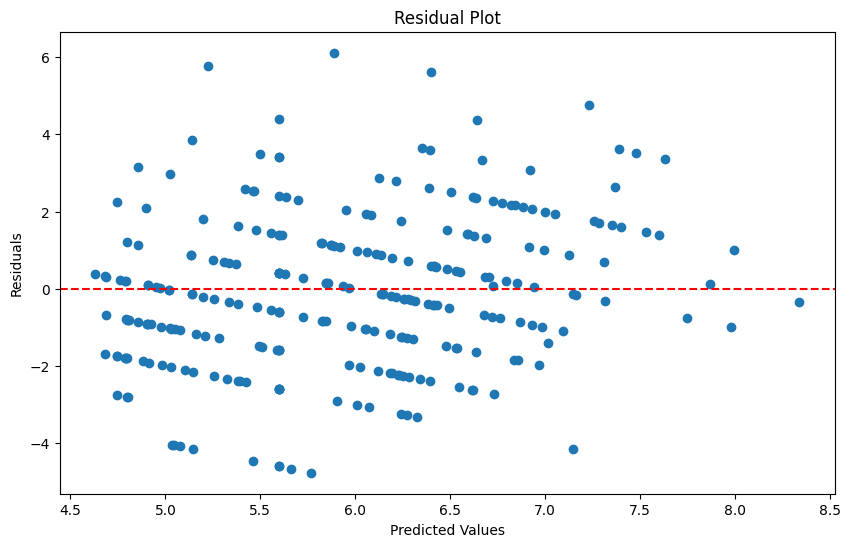

Training Data - Ridge Regression Mean Squared Error: 4.103928377033309
Training Data - Ridge Regression Mean Absolute Error: 1.613705992115589
Training Data - Ridge Regression Mean Absolute Percentage Error: 0.4280857131054935
Training Data - Ridge Regression R-squared: 0.25993368753608337
Testing Data - Ridge Regression Mean Squared Error: 3.976497817195546
Testing Data - Ridge Regression Mean Absolute Error: 1.576870786559685
Testing Data - Ridge Regression Mean Absolute Percentage Error: 0.42536962667625994
Testing Data - Ridge Regression R-squared: 0.24818711052876186
Cross-validation R-squared scores: [ 0.23229637  0.17317524 -7.49552769  0.21224204  0.35270204]
Mean Cross-validation R-squared score: -1.3050223987142953
Predicted numeric grade: 6.70597989841726
Ridge Regression Predicted Max Boulder Grade: V8


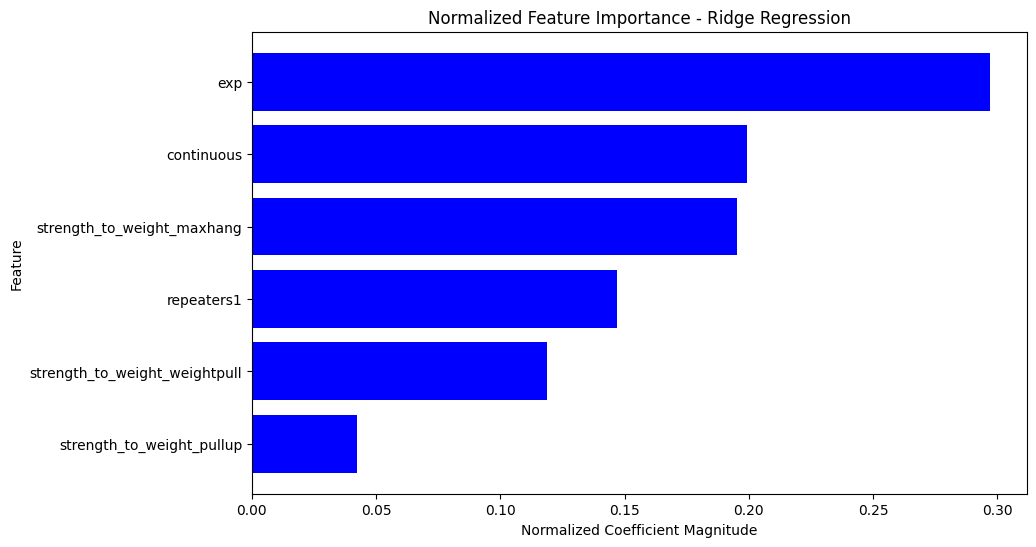

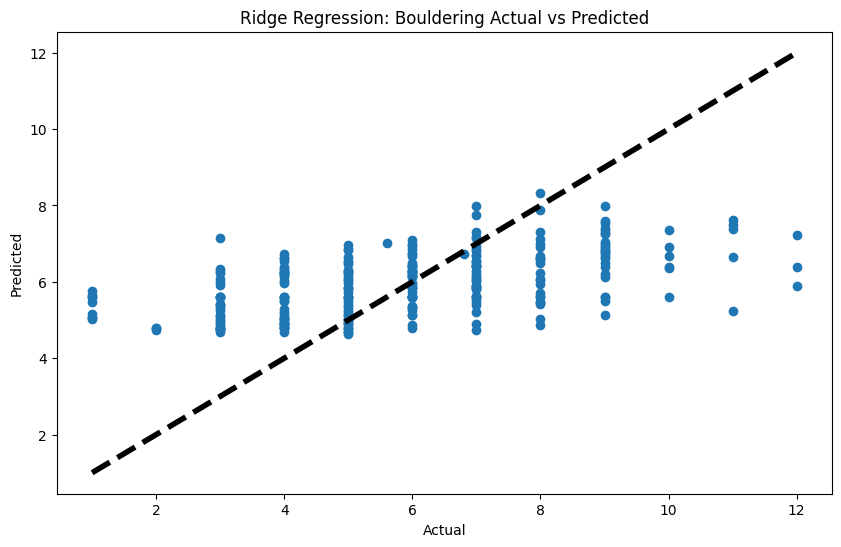

In [96]:
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run() is not None:
    mlflow.end_run()
mlflow.start_run(run_name="Bouldering Grade Forecasting - Ridge Regression")

# Define the features and target
X = data_filtered_bouldering_new[independent_vars_bouldering]
y_boulder = data_filtered_bouldering_new['max_boulder_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

# Define a function to train and evaluate Ridge Regression models without scaling
def train_and_evaluate_model_no_scaling(model_name, model, X_train, X_test, y_train, y_test):
    if mlflow.active_run() is not None:
        mlflow.end_run()
    with mlflow.start_run(run_name=f"Bouldering Grade Forecasting - {model_name}"):
        mlflow.set_tag("Description", f"{model_name} model to predict bouldering grades.")

        # Fit the model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        
        # Plot residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals)
        plt.title('Residual Plot')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.show()
        
        # Evaluate
        mse_test = mean_squared_error(y_test, y_pred)
        mae_test = mean_absolute_error(y_test, y_pred)
        mape_test = mean_absolute_percentage_error(y_test, y_pred)  # Add MAPE
        r2_test = r2_score(y_test, y_pred)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mape_train = mean_absolute_percentage_error(y_train, y_train_pred)  # Add MAPE
        r2_train = r2_score(y_train, y_train_pred)

        # Log metrics to MLFlow
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mape_train", mape_train)  # Log MAPE
        mlflow.log_metric("r2_train", r2_train)

        mlflow.log_metric("mse_test", mse_test)
        mlflow.log_metric("mae_test", mae_test)
        mlflow.log_metric("mape_test", mape_test)  # Log MAPE
        mlflow.log_metric("r2_test", r2_test)

        # Log model to MLFlow
        mlflow.sklearn.log_model(model, f"{model_name}ModelBoulderingNoScaling")

        print(f"Training Data - {model_name} Mean Squared Error: {mse_train}")
        print(f"Training Data - {model_name} Mean Absolute Error: {mae_train}")
        print(f"Training Data - {model_name} Mean Absolute Percentage Error: {mape_train}")  # Print MAPE
        print(f"Training Data - {model_name} R-squared: {r2_train}")

        print(f"Testing Data - {model_name} Mean Squared Error: {mse_test}")
        print(f"Testing Data - {model_name} Mean Absolute Error: {mae_test}")
        print(f"Testing Data - {model_name} Mean Absolute Percentage Error: {mape_test}")  # Print MAPE
        print(f"Testing Data - {model_name} R-squared: {r2_test}")

        return model

# Define Ridge Regression pipeline with scaling
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),  # Standard Scaler added
    ('ridge', Ridge())  # Ridge Regression
])


# Hyperparameter tuning for Ridge Regression
param_grid = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0, 500.0, 1000.0]}

ridge_grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='r2')
ridge_grid_search.fit(X_train, y_train)

# Output the best parameters and scores
best_ridge_model = ridge_grid_search.best_estimator_
print("Best alpha:", ridge_grid_search.best_params_)
print("Best cross-validation R-squared score:", ridge_grid_search.best_score_)

# Train and evaluate the best Ridge model without scaling
best_ridge_model = train_and_evaluate_model_no_scaling("Ridge Regression", best_ridge_model, X_train, X_test, y_train, y_test)

# Cross-validation for the Ridge Regression model without scaling
cv_scores = cross_val_score(best_ridge_model, X, y_boulder, cv=5, scoring='r2')
print("Cross-validation R-squared scores:", cv_scores)
print("Mean Cross-validation R-squared score:", cv_scores.mean())

# Predict with new data
predicted_grade_numeric = best_ridge_model.predict(new_data_bouldering)
print(f"Predicted numeric grade: {predicted_grade_numeric[0]}")

predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_numeric[0]))
print(f"Ridge Regression Predicted Max Boulder Grade: {predicted_grade}")

# Plot the Ridge Regression results without scaling
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Calculate feature importance (coefficients)
feature_importance = best_ridge_model.steps[-1][1].coef_
features = independent_vars_bouldering


# Normalize the feature importance
normalized_feature_importance = abs(feature_importance) / sum(abs(feature_importance))
# plot them in descending importance
sorted_indices = np.argsort(normalized_feature_importance)[0::]
features = [features[i] for i in sorted_indices]
normalized_feature_importance = [normalized_feature_importance[i] for i in sorted_indices]

# Plot normalized feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, normalized_feature_importance, color='b') 
plt.title('Normalized Feature Importance - Ridge Regression')
plt.xlabel('Normalized Coefficient Magnitude') 
plt.ylabel('Feature')
plt.show()

# Call the plotting function for Ridge Regression without scaling
plot_actual_vs_predicted(y_test, best_ridge_model.predict(X_test), 'Ridge Regression: Bouldering Actual vs Predicted')


**Linear Regression Model Results**

Mean Squared Error (MSE): This is an average of the square of the errors, or the differences between the true values and the predictions. The MSE for this linear regression model is 7.95, which means the square of the differences between the observed and predicted values averages to 3.5. A lower MSE indicates a better fit to the data. 

Mean Absolute Error (MAE): This is an average of the absolute differences between the true and predicted values. In this case, the MAE is 1.4, which is easier to interpret because it's in the same units as the original data. This means that on average, the predictions are about 1.4 units away from the actual values.

R-squared: R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. Normally, it ranges from 0 to 1, with 1 indicating a perfect fit. However, if the model is worse than a simple mean model, R-squared can be negative. In this case, R-squared is 0.37 which tells us that 37% of the variability in max bouldering grade can be explained by the model.

Randomized search best score: 0.40294863426644395
Randomized search best params: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 6, 'rf__max_leaf_nodes': 30, 'rf__max_features': 0.5, 'rf__max_depth': 8, 'rf__bootstrap': True}
Training Data - MSE: 2.5784102542737783, MAE: 1.2647713726052507, MAPE: 0.3335247337467712, R2: 0.5350321951088824
Testing Data - MSE: 3.252383505311687, MAE: 1.4263366555606307, MAPE: 0.36972025992085866, R2: 0.38509111454222866
Cross-validation R-squared scores: [0.41298286 0.27669603 0.36300565 0.35360413 0.49034384]
Mean Cross-validation R-squared score: 0.379326500589604
Cross-validation MSE scores: [3.71912073 3.62448452 3.63503795 3.62299055 2.41171175]
Mean Cross-validation MSE score: 3.4026691019715285
Cross-validation MAE scores: [1.5605912  1.5173579  1.47375638 1.5280581  1.21785999]
Mean Cross-validation MAE score: 1.4595247120034787


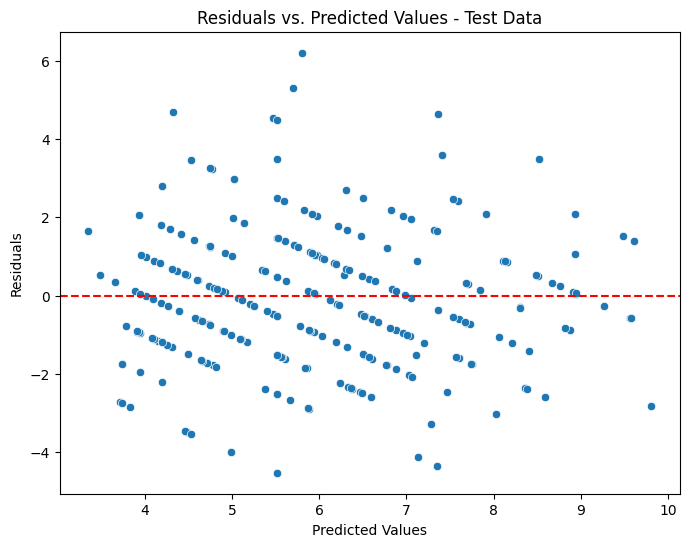

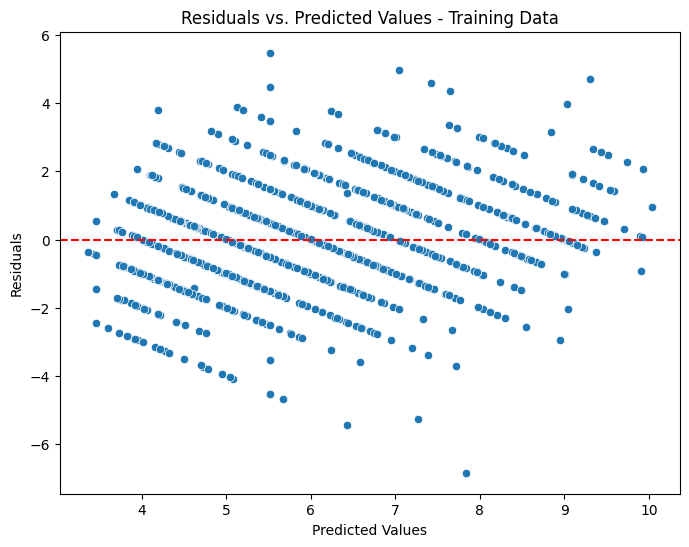

Random Forest Predicted Max Boulder Grade: V6


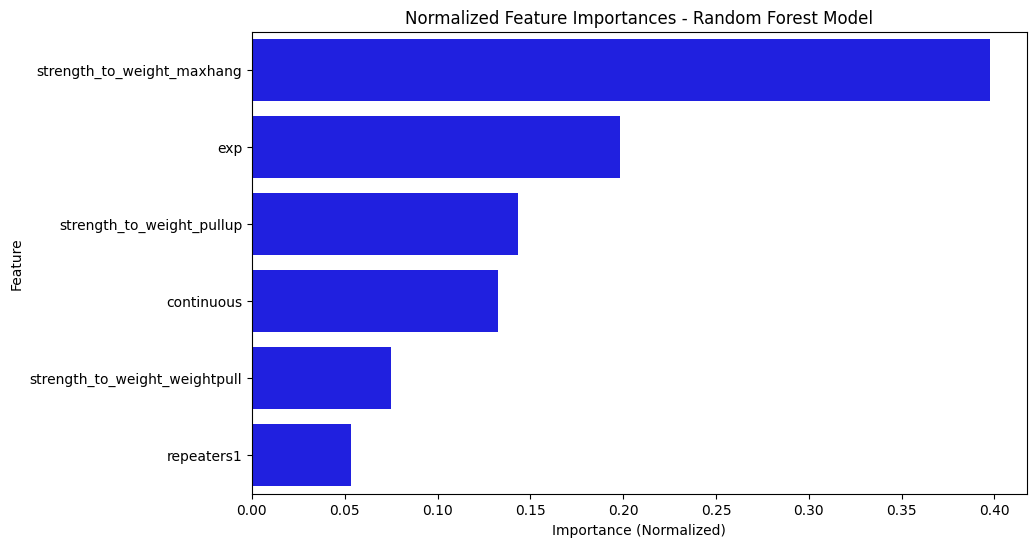

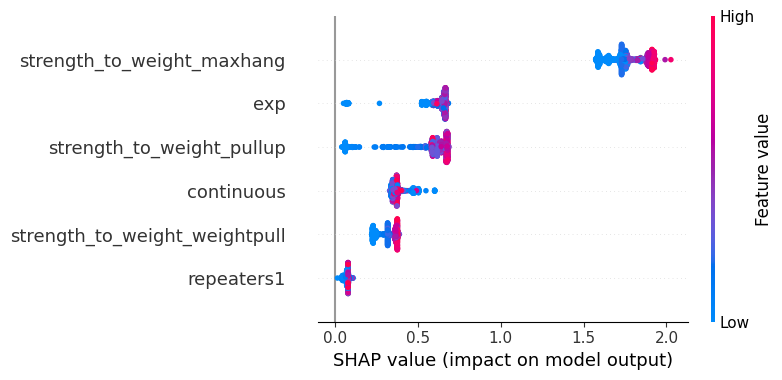

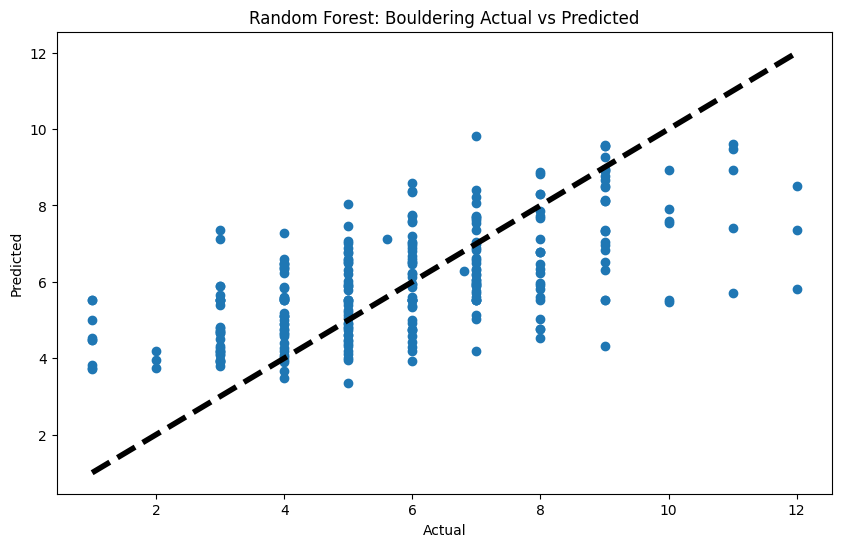

In [99]:
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import os

# Function to initialize MLFlow run
def init_mlflow_run(run_name):
    if mlflow.active_run():
        mlflow.end_run()
    mlflow.start_run(run_name=run_name)

# Function to perform hyperparameter tuning using RandomizedSearchCV
def perform_random_search(X_train, y_train, param_grid):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Optional scaling
        ('rf', RandomForestRegressor(random_state=42))
    ])
    
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    
    print(f"Randomized search best score: {random_search.best_score_}")
    print(f"Randomized search best params: {random_search.best_params_}")
    
    return random_search.best_estimator_

# Function to perform cross-validation and return scores
def cross_validation_scores(model, X, y):
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

    print("Cross-validation R-squared scores:", cv_r2)
    print("Mean Cross-validation R-squared score:", cv_r2.mean())
    
    print("Cross-validation MSE scores:", cv_mse)
    print("Mean Cross-validation MSE score:", cv_mse.mean())
    
    print("Cross-validation MAE scores:", cv_mae)
    print("Mean Cross-validation MAE score:", cv_mae.mean())
    
    return {
        'cv_r2': cv_r2.mean(),
        'cv_mse': cv_mse.mean(),
        'cv_mae': cv_mae.mean()
    }

def evaluate_model(y_train, y_train_pred, y_test, y_pred):
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)  # Add MAPE
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_pred)  # Add MAPE
    r2_test = r2_score(y_test, y_pred)

    metrics = {
        'mse_train': mse_train, 'mae_train': mae_train, 'mape_train': mape_train, 'r2_train': r2_train,  # Log MAPE
        'mse_test': mse_test, 'mae_test': mae_test, 'mape_test': mape_test, 'r2_test': r2_test  # Log MAPE
    }

    print(f"Training Data - MSE: {mse_train}, MAE: {mae_train}, MAPE: {mape_train}, R2: {r2_train}")  # Print MAPE
    print(f"Testing Data - MSE: {mse_test}, MAE: {mae_test}, MAPE: {mape_test}, R2: {r2_test}")  # Print MAPE
    
    return metrics

# Function to log metrics to MLFlow
def log_metrics_to_mlflow(metrics):
    for metric, value in metrics.items():
        mlflow.log_metric(metric, value)

# Function to log feature importances with nested runs to avoid key collisions
def log_feature_importances_to_mlflow(model, features):
    for feature, importance in zip(features, model.named_steps['rf'].feature_importances_):
        with mlflow.start_run(nested=True):
            mlflow.log_param(f"feature_importance_{feature}", importance)

# Function to plot residuals
def plot_residuals(y_test, y_pred, y_train=None, y_train_pred=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=y_test - y_pred)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residuals vs. Predicted Values - Test Data")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    if y_train is not None and y_train_pred is not None:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_train_pred, y=y_train - y_train_pred)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title("Residuals vs. Predicted Values - Training Data")
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.show()

# Function to plot normalized feature importance
def plot_feature_importance(model, features):
    importances = model.named_steps['rf'].feature_importances_
    importances_normalized = importances / importances.sum()  # Normalize importance scores
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_normalized})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title(f'Normalized Feature Importances - Random Forest Model')
    plt.xlabel('Importance (Normalized)')
    plt.ylabel('Feature')
    plt.show()


# Function to plot SHAP values
def plot_shap_values(model, X_train, features):
    explainer = shap.TreeExplainer(model.named_steps['rf'], feature_names=features)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, feature_names=features)

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Function to save the model and pipeline
def save_model_and_pipeline(model, save_dir, model_filename, pipeline_filename):
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, model_filename), 'wb') as f:
        pickle.dump(model, f)
    with open(os.path.join(save_dir, pipeline_filename), 'wb') as f:
        pickle.dump(model, f)

# Main function to run the Random Forest model
def run_random_forest(X, y, param_grid, new_data, save_dir):
    # Initialize MLFlow run
    init_mlflow_run(run_name="RandomForest_Bouldering_Model_Training")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Perform hyperparameter tuning with RandomizedSearchCV
    best_rf_model = perform_random_search(X_train, y_train, param_grid)
    
    # Train and evaluate the model
    y_train_pred_rf = best_rf_model.predict(X_train)
    y_pred_rf = best_rf_model.predict(X_test)
    
    metrics = evaluate_model(y_train, y_train_pred_rf, y_test, y_pred_rf)
    
    # Log metrics to MLFlow
    log_metrics_to_mlflow(metrics)
    
    # Perform cross-validation and get scores for R², MSE, and MAE
    cv_metrics = cross_validation_scores(best_rf_model, X, y)
    log_metrics_to_mlflow(cv_metrics)
    
    # Log feature importances using nested runs
    log_feature_importances_to_mlflow(best_rf_model, X.columns)
    
    # Log the model to MLFlow
    mlflow.sklearn.log_model(best_rf_model, "RandomForest_Bouldering_Model")
    
    # Plot residuals
    plot_residuals(y_test, y_pred_rf, y_train, y_train_pred_rf)
    
    # Predict with new data
    new_data_scaled_bouldering = best_rf_model.named_steps['scaler'].transform(new_data)
    predicted_grade_rf = best_rf_model.predict(new_data_scaled_bouldering)
    predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_rf[0]))
    print(f"Random Forest Predicted Max Boulder Grade: {predicted_grade}")
    
    # Plot feature importance
    plot_feature_importance(best_rf_model, X.columns)
    
    # Plot SHAP values
    plot_shap_values(best_rf_model, X_train, X.columns)
    
    # Plot actual vs predicted values
    plot_actual_vs_predicted(y_test, y_pred_rf, 'Random Forest: Bouldering Actual vs Predicted')
    
    # Save the model and pipeline
    save_model_and_pipeline(best_rf_model, save_dir, 'best_model_rf_bouldering.pkl', 'full_pipeline_rf_bouldering.pkl')
    
    # End MLflow run
    mlflow.end_run()

# Example of calling the main function
param_grid = {
    'rf__n_estimators': [100, 200, 300, 500],
    'rf__max_depth': [5, 6, 8, 10],
    'rf__min_samples_split': [5, 10, 15],
    'rf__min_samples_leaf': [2, 4, 6],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False],
    'rf__max_leaf_nodes': [10, 20, 30]
}

# save_dir = '/path/to/save/pkl_files'
run_random_forest(X=data_filtered_bouldering_new[independent_vars_bouldering], 
                  y=data_filtered_bouldering_new['max_boulder_numeric'], 
                  param_grid=param_grid, 
                  new_data=new_data_bouldering, 
                  save_dir='pkl_files')


**Feature Importance Results**

Strength_to_weight_maxhang is the most important feature (with a score of 0.55) in predicting the output variable in the model. This means that changes in strength_to_weight_maxhang have the biggest effect on the model's predictions.

The second most important feature is strength_to_weight_pullup with a score of 0.11. It's followed by the number of days spent climbing outside (0.13)

So, in terms of predictive power for the model, the features rank as follows:

1. strength_to_weight_maxhang
2. strength_to_weight_pullup
3. days
4. strength_to_weight_weightpull


**SHAP Results**

As expected max hang ratio comes out on top having the potential to offer a +-3 V grade swing in the prediction, followed by days climbing outside and then strength_to_weight_weightpull. This is quite a large swing (+/-3) but at this point in time I'm not sure how to improve on this.

**Random Forest Model Results**

Mean Squared Error (MSE): In this case, the MSE for the Random Forest model is approximately 2.9 MSE is always non-negative, and a value of 0 would indicate a perfect fit to the data. The smaller the MSE, the better the model's performance.

Mean Absolute Error (MAE): The MAE of the Random Forest model is approximately 1.3.

R-squared (R^2): The R-squared of the  Random Forest model is approximately 0.52 which is okay, but could be better. There is some overfitting as the training data R^2 is 0.62.

Predicted Max Boulder Grade: This is the prediction output of the model for a specific input. In this case, the Random Forest model predicted a Max Boulder Grade of 'V5'.

In summary, based on these metrics, the Random Forest model is performing decently, with some room for improvement. The R-squared value could ideally be higher, as 0.52 indicates that only 52% of the variance in the target variable is being explained by the model. 

Randomized search best score: 0.39794042521878537
Randomized search best params: {'gb__n_estimators': 500, 'gb__min_samples_split': 4, 'gb__min_samples_leaf': 2, 'gb__max_depth': 4, 'gb__learning_rate': 0.01}
Training Data - MSE: 2.185681703942674, MAE: 1.152773338329401, MAPE: 0.30268329232654084, R2: 0.6058534042872319
Testing Data - MSE: 3.2570758980115797, MAE: 1.425854772914923, MAPE: 0.3568294000897688, R2: 0.3842039516475366
Cross-validation R-squared scores: [0.39665382 0.26285123 0.36074624 0.37672045 0.46375721]
Mean Cross-validation R-squared score: 0.3721457890226983
Cross-validation MSE scores: [3.82257536 3.69386097 3.64793138 3.49342569 2.53752067]
Mean Cross-validation MSE score: 3.4390628156115737
Cross-validation MAE scores: [1.58703625 1.53100083 1.47581007 1.48898793 1.25640277]
Mean Cross-validation MAE score: 1.4678475676733287


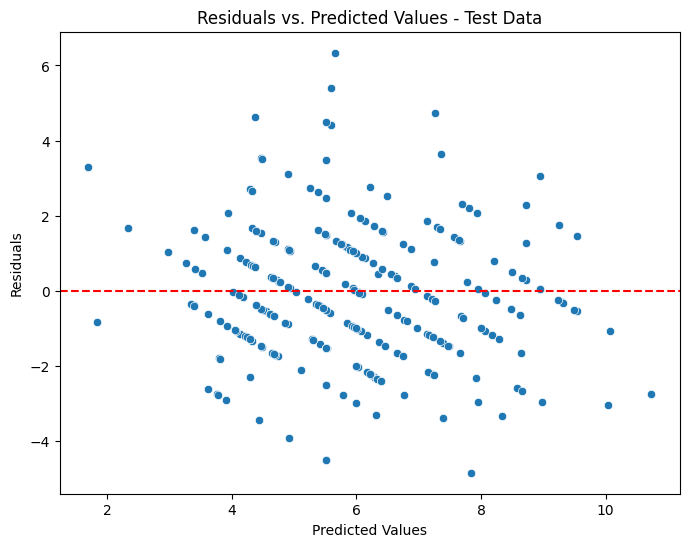

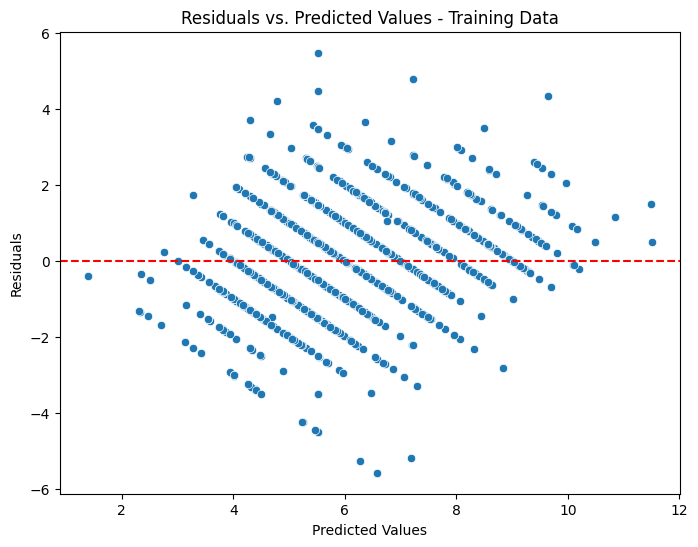

Gradient Boosting Predicted Max Boulder Grade: V6


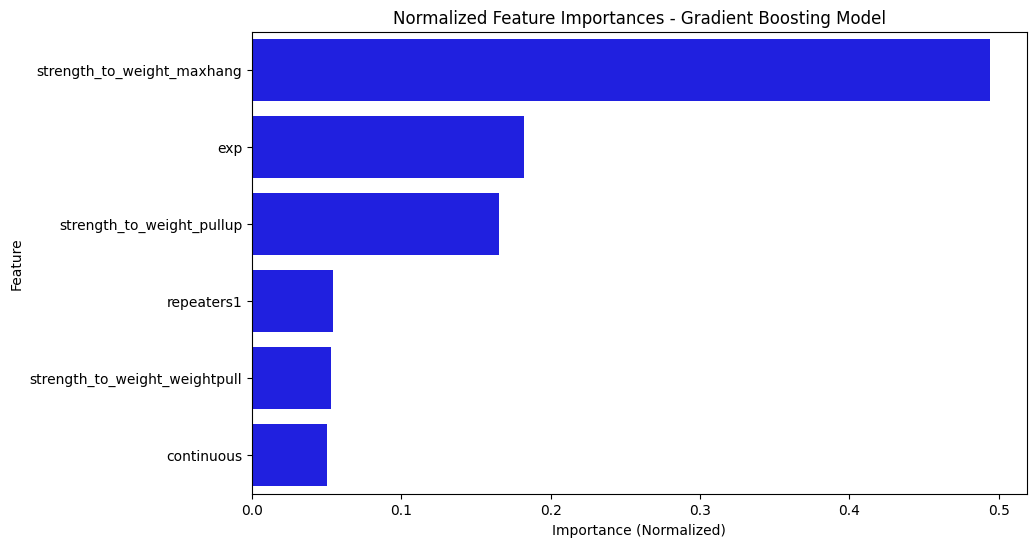

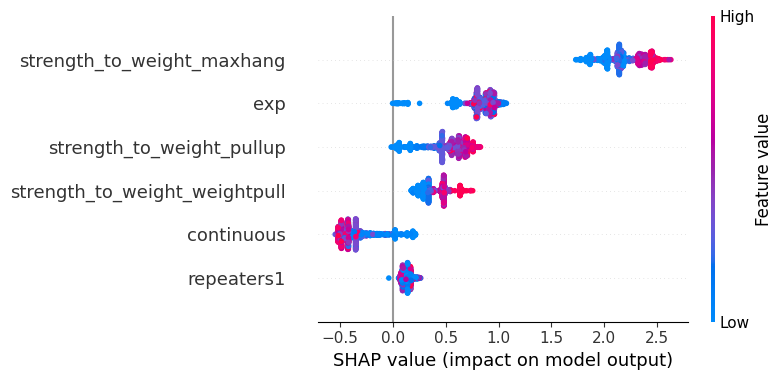

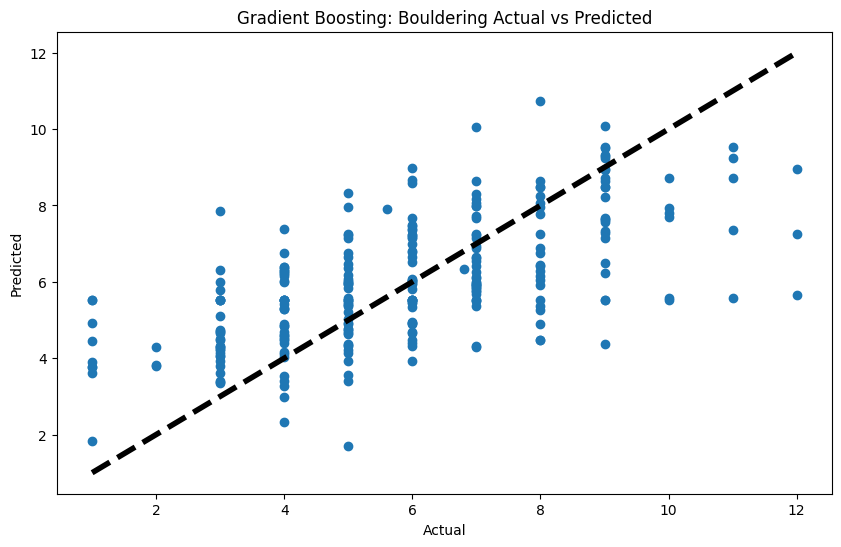

In [98]:
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import os

# Function to initialize MLFlow run
def init_mlflow_run(run_name):
    if mlflow.active_run():
        mlflow.end_run()
    mlflow.start_run(run_name=run_name)

# Function to perform hyperparameter tuning using RandomizedSearchCV
def perform_random_search(X_train, y_train, param_grid):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling to handle outliers
        ('gb', GradientBoostingRegressor(random_state=42))
    ])
    
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    
    print(f"Randomized search best score: {random_search.best_score_}")
    print(f"Randomized search best params: {random_search.best_params_}")
    
    return random_search.best_estimator_

# Function to perform cross-validation and return scores
def cross_validation_scores(model, X, y):
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

    print("Cross-validation R-squared scores:", cv_r2)
    print("Mean Cross-validation R-squared score:", cv_r2.mean())
    
    print("Cross-validation MSE scores:", cv_mse)
    print("Mean Cross-validation MSE score:", cv_mse.mean())
    
    print("Cross-validation MAE scores:", cv_mae)
    print("Mean Cross-validation MAE score:", cv_mae.mean())
    
    return {
        'cv_r2': cv_r2.mean(),
        'cv_mse': cv_mse.mean(),
        'cv_mae': cv_mae.mean()
    }

def evaluate_model(y_train, y_train_pred, y_test, y_pred):
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)  # Add MAPE
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_pred)  # Add MAPE
    r2_test = r2_score(y_test, y_pred)

    metrics = {
        'mse_train': mse_train, 'mae_train': mae_train, 'mape_train': mape_train, 'r2_train': r2_train,  # Log MAPE
        'mse_test': mse_test, 'mae_test': mae_test, 'mape_test': mape_test, 'r2_test': r2_test  # Log MAPE
    }

    print(f"Training Data - MSE: {mse_train}, MAE: {mae_train}, MAPE: {mape_train}, R2: {r2_train}")  # Print MAPE
    print(f"Testing Data - MSE: {mse_test}, MAE: {mae_test}, MAPE: {mape_test}, R2: {r2_test}")  # Print MAPE
    
    return metrics

# Function to log metrics to MLFlow
def log_metrics_to_mlflow(metrics):
    for metric, value in metrics.items():
        mlflow.log_metric(metric, value)

# Function to log feature importances with nested runs to avoid key collisions
def log_feature_importances_to_mlflow(model, features):
    for feature, importance in zip(features, model.named_steps['gb'].feature_importances_):
        with mlflow.start_run(nested=True):
            mlflow.log_param(f"feature_importance_{feature}", importance)

# Function to plot residuals
def plot_residuals(y_test, y_pred, y_train=None, y_train_pred=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=y_test - y_pred)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residuals vs. Predicted Values - Test Data")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    if y_train is not None and y_train_pred is not None:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_train_pred, y=y_train - y_train_pred)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title("Residuals vs. Predicted Values - Training Data")
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.show()

# Function to plot normalized feature importance
def plot_feature_importance(model, features):
    importances = model.named_steps['gb'].feature_importances_
    importances_normalized = importances / importances.sum()  # Normalize importance scores
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_normalized})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title(f'Normalized Feature Importances - Gradient Boosting Model')
    plt.xlabel('Importance (Normalized)')
    plt.ylabel('Feature')
    plt.show()


# Function to plot SHAP values
def plot_shap_values(model, X_train, features):
    explainer = shap.Explainer(model.named_steps['gb'], feature_names=features)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, feature_names=features)

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Function to save the model and pipeline
def save_model_and_pipeline(model, save_dir, model_filename, pipeline_filename):
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, model_filename), 'wb') as f:
        pickle.dump(model, f)
    with open(os.path.join(save_dir, pipeline_filename), 'wb') as f:
        pickle.dump(model, f)

# Main function to run the Gradient Boosting model
def run_gradient_boosting(X, y, param_grid, new_data, save_dir):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Perform hyperparameter tuning with RandomizedSearchCV
    best_gb_model = perform_random_search(X_train, y_train, param_grid)
    
    # Train and evaluate the model
    y_train_pred_gb = best_gb_model.predict(X_train)
    y_pred_gb = best_gb_model.predict(X_test)
    
    metrics = evaluate_model(y_train, y_train_pred_gb, y_test, y_pred_gb)
    
    # Log metrics to MLFlow
    log_metrics_to_mlflow(metrics)
    
    # Perform cross-validation and get scores for R², MSE, and MAE
    cv_metrics = cross_validation_scores(best_gb_model, X, y)
    log_metrics_to_mlflow(cv_metrics)
    
    # Log feature importances using nested runs
    log_feature_importances_to_mlflow(best_gb_model, X.columns)
    
    # Plot residuals
    plot_residuals(y_test, y_pred_gb, y_train, y_train_pred_gb)
    
    # Predict with new data
    new_data_scaled_bouldering = best_gb_model.named_steps['scaler'].transform(new_data)
    predicted_grade_gb = best_gb_model.predict(new_data_scaled_bouldering)
    predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_gb[0]))
    print(f"Gradient Boosting Predicted Max Boulder Grade: {predicted_grade}")
    
    # Plot feature importance
    plot_feature_importance(best_gb_model, X.columns)
    
    # Plot SHAP values
    plot_shap_values(best_gb_model, X_train, X.columns)
    
    # Plot actual vs predicted values
    plot_actual_vs_predicted(y_test, y_pred_gb, 'Gradient Boosting: Bouldering Actual vs Predicted')
    
    # Save the model and pipeline
    save_model_and_pipeline(best_gb_model, save_dir, 'best_model_gb_bouldering.pkl', 'full_pipeline_gb_bouldering.pkl')

# Example of calling the main function
param_grid_gb = {
    'gb__n_estimators': [100, 200, 300, 500],
    'gb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gb__max_depth': [2, 4, 6],
    'gb__min_samples_split': [2, 4, 6],
    'gb__min_samples_leaf': [1, 2, 3]
}

run_gradient_boosting(X=data_filtered_bouldering_new[independent_vars_bouldering], 
                      y=data_filtered_bouldering_new['max_boulder_numeric'], 
                      param_grid=param_grid_gb, 
                      new_data=new_data_bouldering, 
                      save_dir='pkl_files')


**Feature Importance Results**

Strength_to_weight_maxhang is the most important feature (with a score of 0.49) in predicting the output variable in the model. This means that changes in strength_to_weight_maxhang have the biggest effect on the model's predictions.

The second most important feature is strength_to_weight_pullup followed by days climbing outside, and then strength_to_weight_weightpull.

So, in terms of predictive power for the model, the features rank as follows:

1. strength_to_weight_maxhang
2. strength_to_weight_pull
3. strength_to_weight_weightpull
4. days climbing outside

These results are slightly different from the RF model in that number 3 and 4 are swapped. This still leaves the max hangs to bodyweight ratio at the top.

**SHAP Results**

Again as expected the maxhangs ratio comes out on top having the potential to offer a +-2 V grade swing in the prediction, followed by days and then weighted pullups ratio. 

**Gradient Boosting Model Results**

Mean Squared Error (MSE): The MSE for the Gradient Boosting model is approximately 2.9. 

Mean Absolute Error (MAE): The MAE for the Gradient Boosting model is approximately 1.3. Both MSE and MAE are almost identical to the RF model results.

R-squared (R^2): The R-squared for the Gradient Boosting model is approximately 0.53. This value indicates that the model explains about 53% of the variance in the target variable. 

In summary, the Gradient Boosting model performs slightly better than the Random Forest model, based on these metrics. The R-squared value is slightly higher, indicating that it can explain a bit more variance in the target variable. The MAE and MSE are also slightly lower, indicating fewer prediction errors.

The predicted grade is actually slightly higher in this case, V6 instead of V5.

Best alpha: {'ridge__alpha': 10.0}
Best cross-validation R-squared score: 0.3936051906257123


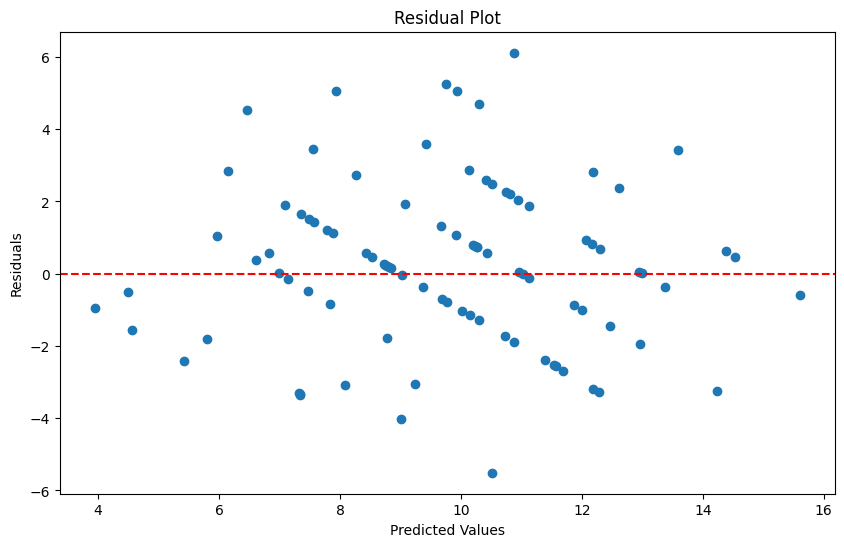

Training Data - Ridge Regression Mean Squared Error: 6.717139906005854
Training Data - Ridge Regression Mean Absolute Error: 2.0455938506690394
Training Data - Ridge Regression Mean Absolute Percentage Error: 0.29195154966378667
Training Data - Ridge Regression R-squared: 0.42365743268015743
Testing Data - Ridge Regression Mean Squared Error: 5.197606442354311
Testing Data - Ridge Regression Mean Absolute Error: 1.764067746691934
Testing Data - Ridge Regression Mean Absolute Percentage Error: 0.20956424138589447
Testing Data - Ridge Regression R-squared: 0.5001225603320703
Cross-validation R-squared scores: [0.31556229 0.51845153 0.43991598 0.38229552 0.34188889]
Mean Cross-validation R-squared score: 0.3996228434643602
Predicted numeric grade: 18.69975207544687
Ridge Regression Predicted Max Sport Grade: 8b


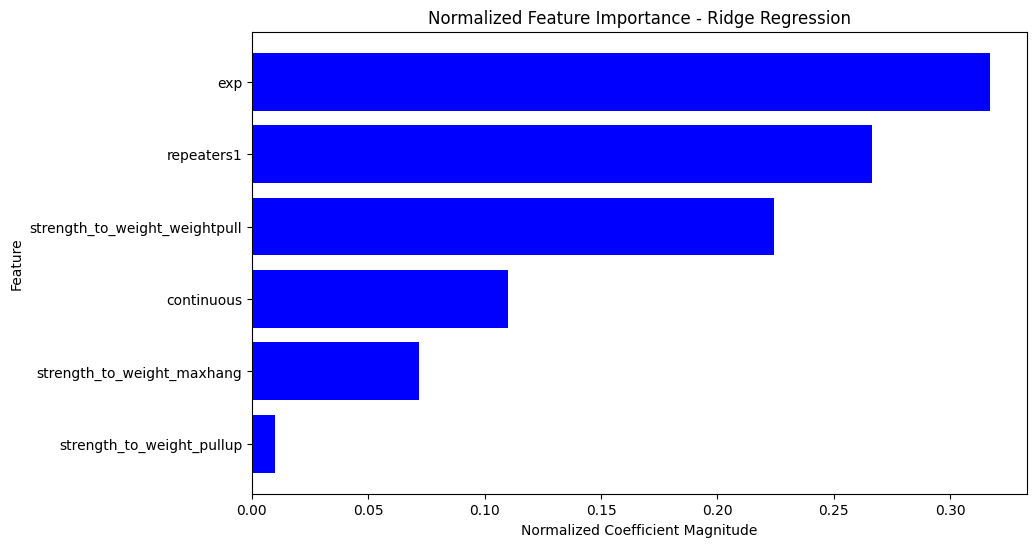

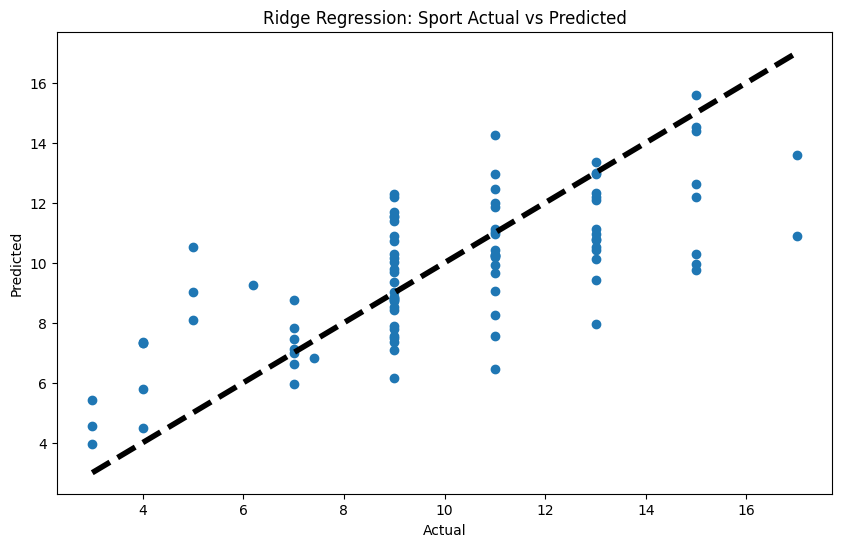

In [90]:
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run() is not None:
    mlflow.end_run()
mlflow.start_run(run_name="Sport Grade Forecasting - Ridge Regression")

# Define the features and target
X = data_filtered_sport[independent_vars_sport]
y_boulder = data_filtered_sport['max_sport_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

# Define a function to train and evaluate Ridge Regression models without scaling
def train_and_evaluate_model_no_scaling(model_name, model, X_train, X_test, y_train, y_test):
    if mlflow.active_run() is not None:
        mlflow.end_run()
    with mlflow.start_run(run_name=f"Sport Grade Forecasting - {model_name}"):
        mlflow.set_tag("Description", f"{model_name} model to predict sport grades.")

        # Fit the model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        
        # Plot residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals)
        plt.title('Residual Plot')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.show()
        
        # Evaluate
        mse_test = mean_squared_error(y_test, y_pred)
        mae_test = mean_absolute_error(y_test, y_pred)
        mape_test = mean_absolute_percentage_error(y_test, y_pred)  # Add MAPE
        r2_test = r2_score(y_test, y_pred)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mape_train = mean_absolute_percentage_error(y_train, y_train_pred)  # Add MAPE
        r2_train = r2_score(y_train, y_train_pred)

        # Log metrics to MLFlow
        mlflow.log_metric("mse_train", mse_train)
        mlflow.log_metric("mae_train", mae_train)
        mlflow.log_metric("mape_train", mape_train)  # Log MAPE
        mlflow.log_metric("r2_train", r2_train)

        mlflow.log_metric("mse_test", mse_test)
        mlflow.log_metric("mae_test", mae_test)
        mlflow.log_metric("mape_test", mape_test)  # Log MAPE
        mlflow.log_metric("r2_test", r2_test)

        # Log model to MLFlow
        mlflow.sklearn.log_model(model, f"{model_name}ModelBoulderingNoScaling")

        print(f"Training Data - {model_name} Mean Squared Error: {mse_train}")
        print(f"Training Data - {model_name} Mean Absolute Error: {mae_train}")
        print(f"Training Data - {model_name} Mean Absolute Percentage Error: {mape_train}")  # Print MAPE
        print(f"Training Data - {model_name} R-squared: {r2_train}")

        print(f"Testing Data - {model_name} Mean Squared Error: {mse_test}")
        print(f"Testing Data - {model_name} Mean Absolute Error: {mae_test}")
        print(f"Testing Data - {model_name} Mean Absolute Percentage Error: {mape_test}")  # Print MAPE
        print(f"Testing Data - {model_name} R-squared: {r2_test}")

        return model

# Define Ridge Regression pipeline with scaling
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),  # Standard Scaler added
    ('ridge', Ridge())  # Ridge Regression
])


# Hyperparameter tuning for Ridge Regression
param_grid = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0, 500.0, 1000.0]}

ridge_grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='r2')
ridge_grid_search.fit(X_train, y_train)

# Output the best parameters and scores
best_ridge_model = ridge_grid_search.best_estimator_
print("Best alpha:", ridge_grid_search.best_params_)
print("Best cross-validation R-squared score:", ridge_grid_search.best_score_)

# Train and evaluate the best Ridge model without scaling
best_ridge_model = train_and_evaluate_model_no_scaling("Ridge Regression", best_ridge_model, X_train, X_test, y_train, y_test)

# Cross-validation for the Ridge Regression model without scaling
cv_scores = cross_val_score(best_ridge_model, X, y_boulder, cv=5, scoring='r2')
print("Cross-validation R-squared scores:", cv_scores)
print("Mean Cross-validation R-squared score:", cv_scores.mean())

# Predict with new data
predicted_grade_numeric = best_ridge_model.predict(new_data_sport)
print(f"Predicted numeric grade: {predicted_grade_numeric[0]}")

predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_numeric[0]))
print(f"Ridge Regression Predicted Max Sport Grade: {predicted_grade}")

# Plot the Ridge Regression results without scaling
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Calculate feature importance (coefficients)
feature_importance = best_ridge_model.steps[-1][1].coef_
features = independent_vars_bouldering


# Normalize the feature importance
normalized_feature_importance = abs(feature_importance) / sum(abs(feature_importance))
# plot them in descending importance
sorted_indices = np.argsort(normalized_feature_importance)[0::]
features = [features[i] for i in sorted_indices]
normalized_feature_importance = [normalized_feature_importance[i] for i in sorted_indices]

# Plot normalized feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, normalized_feature_importance, color='b') 
plt.title('Normalized Feature Importance - Ridge Regression')
plt.xlabel('Normalized Coefficient Magnitude') 
plt.ylabel('Feature')
plt.show()

# Call the plotting function for Ridge Regression without scaling
plot_actual_vs_predicted(y_test, best_ridge_model.predict(X_test), 'Ridge Regression: Sport Actual vs Predicted')


Randomized search best score: 0.3536888236630279
Randomized search best params: {'rf__n_estimators': 300, 'rf__min_samples_split': 15, 'rf__min_samples_leaf': 2, 'rf__max_leaf_nodes': 30, 'rf__max_features': 0.5, 'rf__max_depth': 5, 'rf__bootstrap': True}
Training Data - MSE: 4.83039703270065, MAE: 1.732073356759918, MAPE: 0.24859364659496527, R2: 0.5855433315432844
Testing Data - MSE: 5.529729238462615, MAE: 1.840217135051087, MAPE: 0.22740685724055001, R2: 0.4681808012136611
Cross-validation R-squared scores: [0.30001583 0.45974952 0.41653287 0.31477582 0.32402019]
Mean Cross-validation R-squared score: 0.36301884735324463
Cross-validation MSE scores: [8.31149014 7.18884312 5.69597216 6.68032171 7.65045584]
Mean Cross-validation MSE score: 7.105416594059794
Cross-validation MAE scores: [2.41619301 2.0353941  1.84044374 2.0433765  2.14879072]
Mean Cross-validation MAE score: 2.0968396141540016


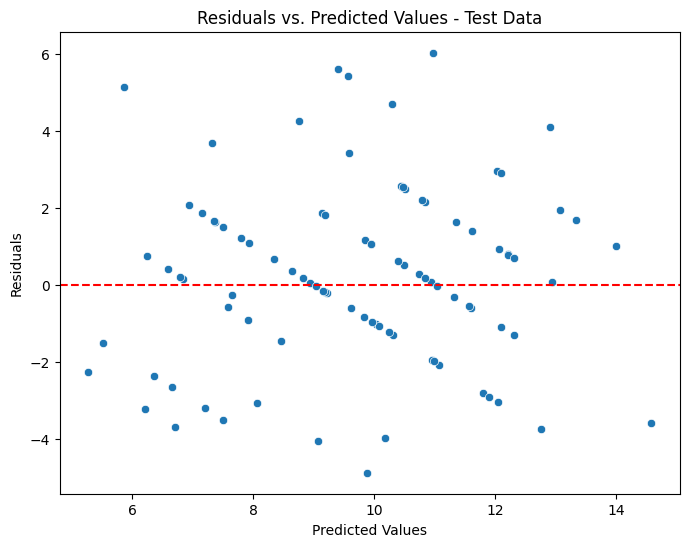

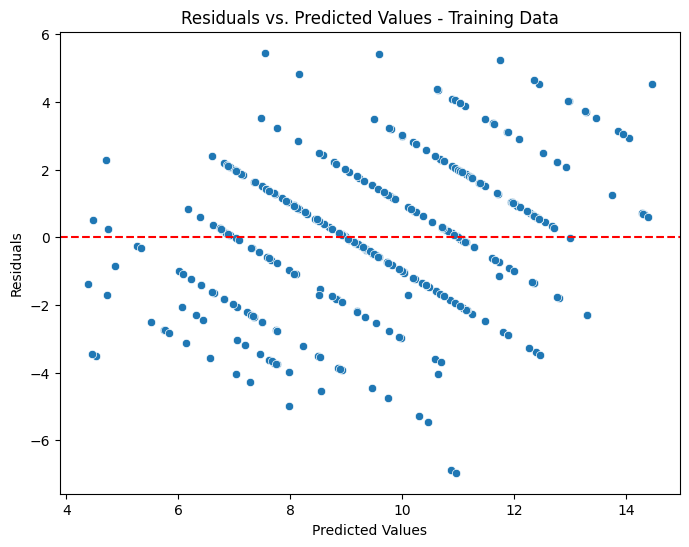

Random Forest Predicted Max Sport Grade: 6b


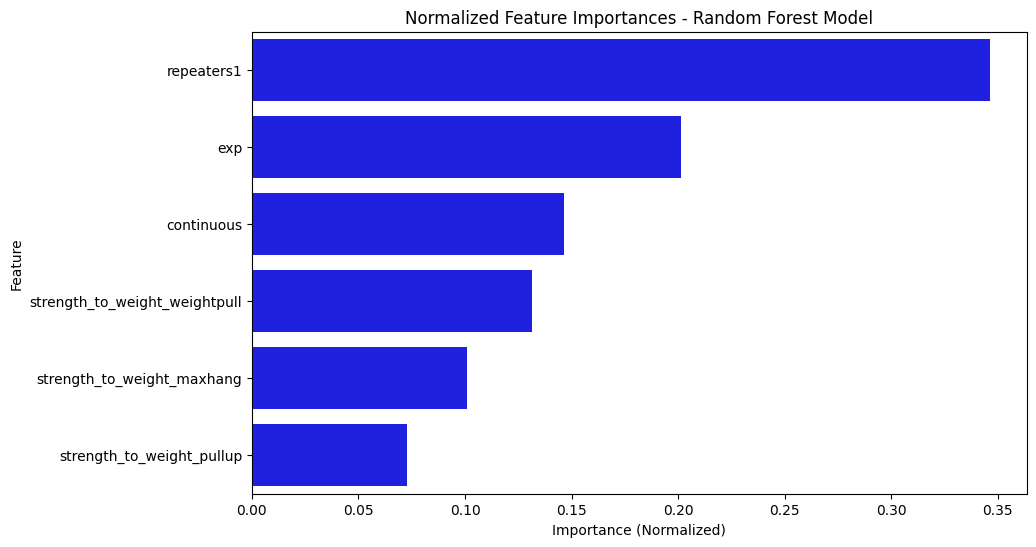

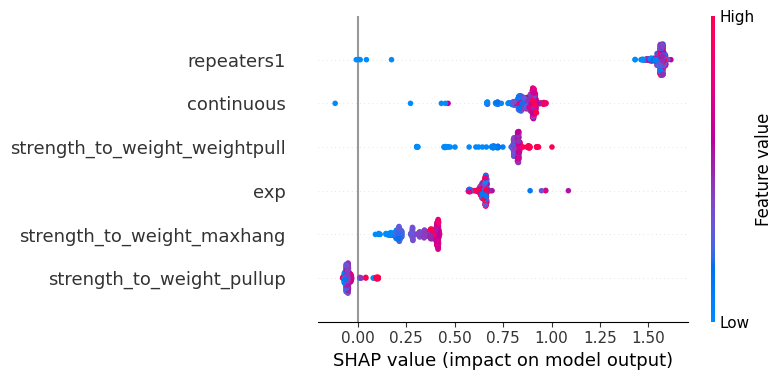

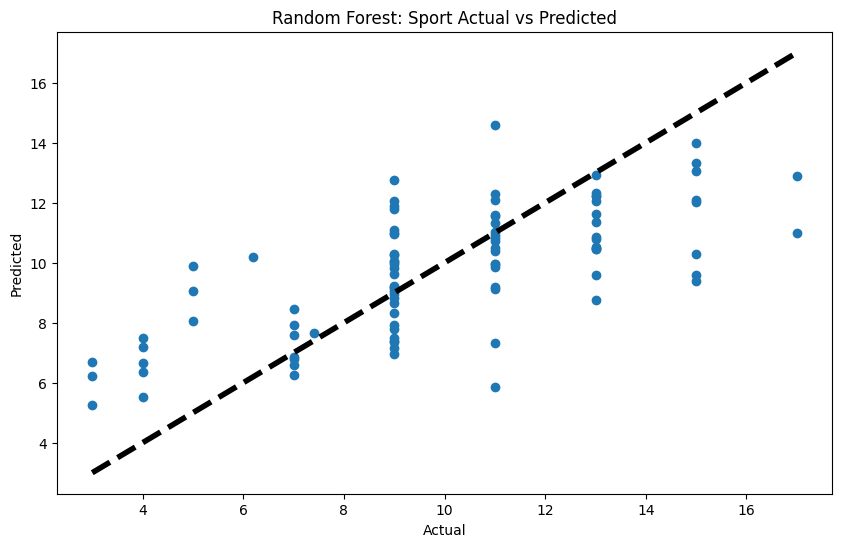

In [91]:
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import os

# Function to initialize MLFlow run
def init_mlflow_run(run_name):
    if mlflow.active_run():
        mlflow.end_run()
    mlflow.start_run(run_name=run_name)

# Function to perform hyperparameter tuning using RandomizedSearchCV
def perform_random_search(X_train, y_train, param_grid):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Optional scaling
        ('rf', RandomForestRegressor(random_state=42))
    ])
    
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    
    print(f"Randomized search best score: {random_search.best_score_}")
    print(f"Randomized search best params: {random_search.best_params_}")
    
    return random_search.best_estimator_

# Function to perform cross-validation and return scores
def cross_validation_scores(model, X, y):
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

    print("Cross-validation R-squared scores:", cv_r2)
    print("Mean Cross-validation R-squared score:", cv_r2.mean())
    
    print("Cross-validation MSE scores:", cv_mse)
    print("Mean Cross-validation MSE score:", cv_mse.mean())
    
    print("Cross-validation MAE scores:", cv_mae)
    print("Mean Cross-validation MAE score:", cv_mae.mean())
    
    return {
        'cv_r2': cv_r2.mean(),
        'cv_mse': cv_mse.mean(),
        'cv_mae': cv_mae.mean()
    }

def evaluate_model(y_train, y_train_pred, y_test, y_pred):
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)  # Add MAPE
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_pred)  # Add MAPE
    r2_test = r2_score(y_test, y_pred)

    metrics = {
        'mse_train': mse_train, 'mae_train': mae_train, 'mape_train': mape_train, 'r2_train': r2_train,  # Log MAPE
        'mse_test': mse_test, 'mae_test': mae_test, 'mape_test': mape_test, 'r2_test': r2_test  # Log MAPE
    }

    print(f"Training Data - MSE: {mse_train}, MAE: {mae_train}, MAPE: {mape_train}, R2: {r2_train}")  # Print MAPE
    print(f"Testing Data - MSE: {mse_test}, MAE: {mae_test}, MAPE: {mape_test}, R2: {r2_test}")  # Print MAPE
    
    return metrics

# Function to log metrics to MLFlow
def log_metrics_to_mlflow(metrics):
    for metric, value in metrics.items():
        mlflow.log_metric(metric, value)

# Function to log feature importances with nested runs to avoid key collisions
def log_feature_importances_to_mlflow(model, features):
    for feature, importance in zip(features, model.named_steps['rf'].feature_importances_):
        with mlflow.start_run(nested=True):
            mlflow.log_param(f"feature_importance_{feature}", importance)

# Function to plot residuals
def plot_residuals(y_test, y_pred, y_train=None, y_train_pred=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=y_test - y_pred)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residuals vs. Predicted Values - Test Data")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    if y_train is not None and y_train_pred is not None:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_train_pred, y=y_train - y_train_pred)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title("Residuals vs. Predicted Values - Training Data")
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.show()

# Function to plot normalized feature importance
def plot_feature_importance(model, features):
    importances = model.named_steps['rf'].feature_importances_
    importances_normalized = importances / importances.sum()  # Normalize importance scores
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_normalized})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title(f'Normalized Feature Importances - Random Forest Model')
    plt.xlabel('Importance (Normalized)')
    plt.ylabel('Feature')
    plt.show()


# Function to plot SHAP values
def plot_shap_values(model, X_train, features):
    explainer = shap.TreeExplainer(model.named_steps['rf'], feature_names=features)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, feature_names=features)

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Function to save the model and pipeline
def save_model_and_pipeline(model, save_dir, model_filename, pipeline_filename):
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, model_filename), 'wb') as f:
        pickle.dump(model, f)
    with open(os.path.join(save_dir, pipeline_filename), 'wb') as f:
        pickle.dump(model, f)

# Main function to run the Random Forest model
def run_random_forest(X, y, param_grid, new_data, save_dir):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Perform hyperparameter tuning with RandomizedSearchCV
    best_rf_model = perform_random_search(X_train, y_train, param_grid)
    
    # Train and evaluate the model
    y_train_pred_rf = best_rf_model.predict(X_train)
    y_pred_rf = best_rf_model.predict(X_test)
    
    metrics = evaluate_model(y_train, y_train_pred_rf, y_test, y_pred_rf)
    
    # Log metrics to MLFlow
    log_metrics_to_mlflow(metrics)
    
    # Perform cross-validation and get scores for R², MSE, and MAE
    cv_metrics = cross_validation_scores(best_rf_model, X, y)
    log_metrics_to_mlflow(cv_metrics)
    
    # Log feature importances using nested runs
    log_feature_importances_to_mlflow(best_rf_model, X.columns)
    
    # Plot residuals
    plot_residuals(y_test, y_pred_rf, y_train, y_train_pred_rf)
    
    # Predict with new data
    new_data_scaled_sport = best_rf_model.named_steps['scaler'].transform(new_data)
    predicted_grade_rf = best_rf_model.predict(new_data_scaled_sport)
    predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_rf[0]))
    print(f"Random Forest Predicted Max Sport Grade: {predicted_grade}")
    
    # Plot feature importance
    plot_feature_importance(best_rf_model, X.columns)
    
    # Plot SHAP values
    plot_shap_values(best_rf_model, X_train, X.columns)
    
    # Plot actual vs predicted values
    plot_actual_vs_predicted(y_test, y_pred_rf, 'Random Forest: Sport Actual vs Predicted')
    
    # Save the model and pipeline
    save_model_and_pipeline(best_rf_model, save_dir, 'best_model_rf_sport.pkl', 'full_pipeline_rf_sport.pkl')

# Example of calling the main function
param_grid = {
    'rf__n_estimators': [100, 200, 300, 500],
    'rf__max_depth': [5, 6, 8, 10],
    'rf__min_samples_split': [5, 10, 15],
    'rf__min_samples_leaf': [2, 4, 6],
    'rf__max_features': ['sqrt', 'log2', 0.5],
    'rf__bootstrap': [True, False],
    'rf__max_leaf_nodes': [10, 20, 30]
}

# save_dir = '/path/to/save/pkl_files'
run_random_forest(X=data_filtered_sport[independent_vars_sport], 
                  y=data_filtered_sport['max_sport_numeric'], 
                  param_grid=param_grid, 
                  new_data=new_data_sport, 
                  save_dir='pkl_files')


Randomized search best score: 0.34093713617420923
Randomized search best params: {'gb__n_estimators': 300, 'gb__min_samples_split': 4, 'gb__min_samples_leaf': 3, 'gb__max_depth': 2, 'gb__learning_rate': 0.01}
Training Data - MSE: 5.851190020802663, MAE: 1.9155992274356453, MAPE: 0.2765016358903965, R2: 0.497957475107753
Testing Data - MSE: 5.768153705723173, MAE: 1.8896409662068638, MAPE: 0.23719067130473073, R2: 0.4452504363293178
Cross-validation R-squared scores: [0.30592217 0.43536966 0.37985548 0.33712399 0.31926282]
Mean Cross-validation R-squared score: 0.3555068228576716
Cross-validation MSE scores: [8.24135935 7.51325366 6.05402735 6.46244713 7.70429775]
Mean Cross-validation MSE score: 7.19507705008189
Cross-validation MAE scores: [2.3930497  2.08707797 1.90088307 1.97826179 2.19927321]
Mean Cross-validation MAE score: 2.111709150494226


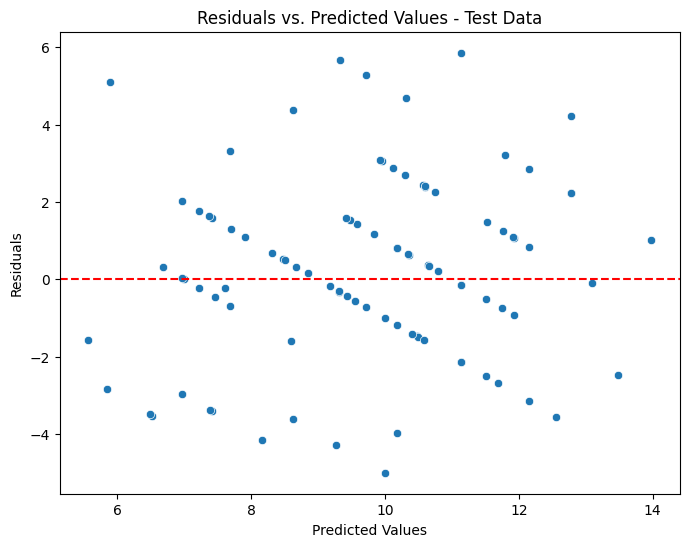

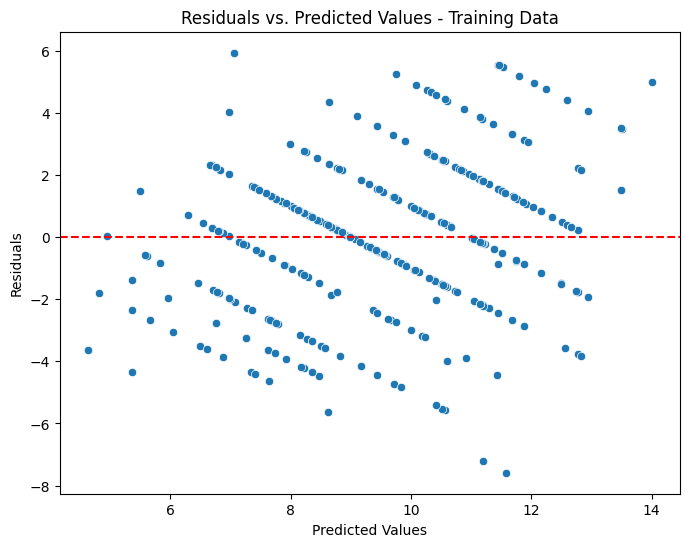

Gradient Boosting Predicted Max Sport Grade: 6b


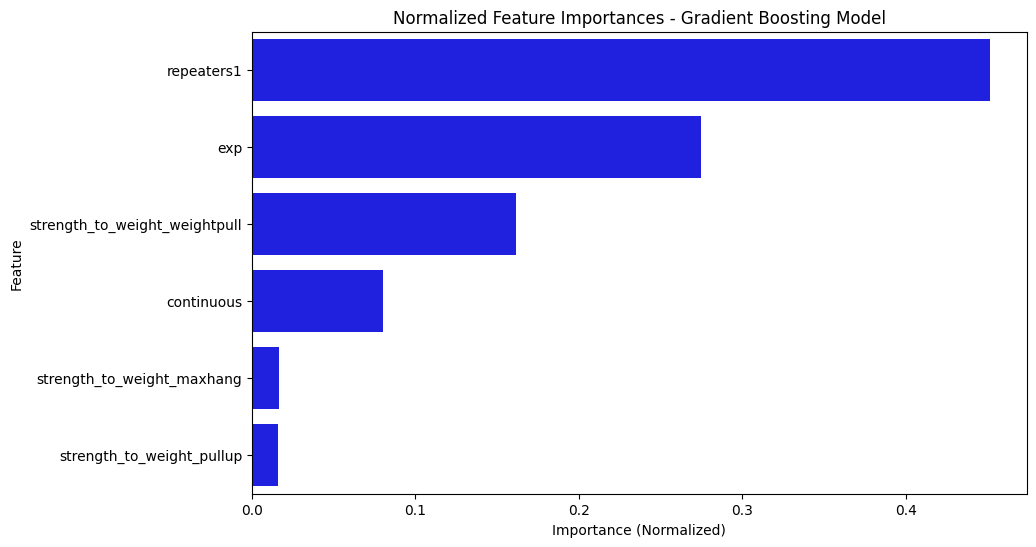

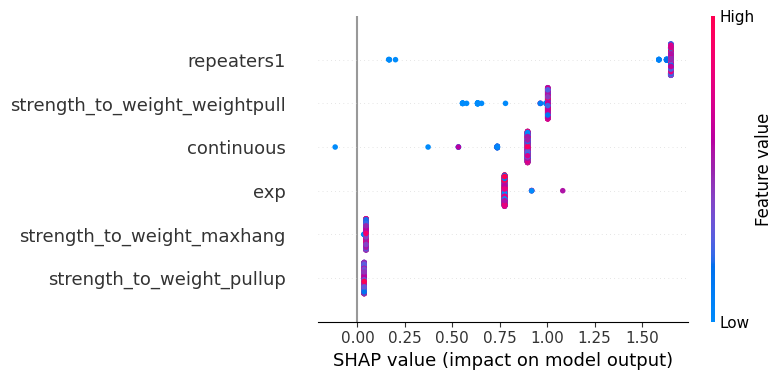

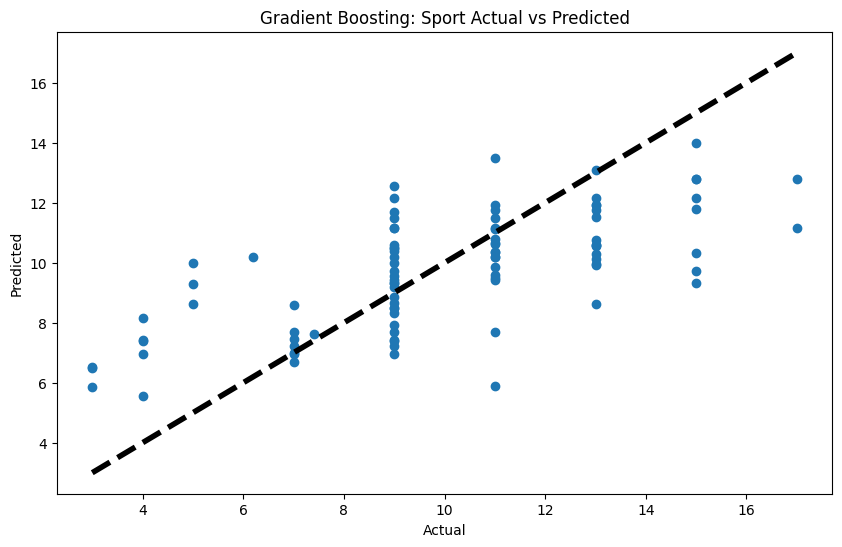

In [93]:
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import os

# Function to initialize MLFlow run
def init_mlflow_run(run_name):
    if mlflow.active_run():
        mlflow.end_run()
    mlflow.start_run(run_name=run_name)

# Function to perform hyperparameter tuning using RandomizedSearchCV
def perform_random_search(X_train, y_train, param_grid):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling to handle outliers
        ('gb', GradientBoostingRegressor(random_state=42))
    ])
    
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    
    print(f"Randomized search best score: {random_search.best_score_}")
    print(f"Randomized search best params: {random_search.best_params_}")
    
    return random_search.best_estimator_

# Function to perform cross-validation and return scores
def cross_validation_scores(model, X, y):
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

    print("Cross-validation R-squared scores:", cv_r2)
    print("Mean Cross-validation R-squared score:", cv_r2.mean())
    
    print("Cross-validation MSE scores:", cv_mse)
    print("Mean Cross-validation MSE score:", cv_mse.mean())
    
    print("Cross-validation MAE scores:", cv_mae)
    print("Mean Cross-validation MAE score:", cv_mae.mean())
    
    return {
        'cv_r2': cv_r2.mean(),
        'cv_mse': cv_mse.mean(),
        'cv_mae': cv_mae.mean()
    }

def evaluate_model(y_train, y_train_pred, y_test, y_pred):
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)  # Add MAPE
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_pred)  # Add MAPE
    r2_test = r2_score(y_test, y_pred)

    metrics = {
        'mse_train': mse_train, 'mae_train': mae_train, 'mape_train': mape_train, 'r2_train': r2_train,  # Log MAPE
        'mse_test': mse_test, 'mae_test': mae_test, 'mape_test': mape_test, 'r2_test': r2_test  # Log MAPE
    }

    print(f"Training Data - MSE: {mse_train}, MAE: {mae_train}, MAPE: {mape_train}, R2: {r2_train}")  # Print MAPE
    print(f"Testing Data - MSE: {mse_test}, MAE: {mae_test}, MAPE: {mape_test}, R2: {r2_test}")  # Print MAPE
    
    return metrics

# Function to log metrics to MLFlow
def log_metrics_to_mlflow(metrics):
    for metric, value in metrics.items():
        mlflow.log_metric(metric, value)

# Function to log feature importances with nested runs to avoid key collisions
def log_feature_importances_to_mlflow(model, features):
    for feature, importance in zip(features, model.named_steps['gb'].feature_importances_):
        with mlflow.start_run(nested=True):
            mlflow.log_param(f"feature_importance_{feature}", importance)

# Function to plot residuals
def plot_residuals(y_test, y_pred, y_train=None, y_train_pred=None):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=y_test - y_pred)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residuals vs. Predicted Values - Test Data")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    if y_train is not None and y_train_pred is not None:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=y_train_pred, y=y_train - y_train_pred)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title("Residuals vs. Predicted Values - Training Data")
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.show()

# Function to plot normalized feature importance
def plot_feature_importance(model, features):
    importances = model.named_steps['gb'].feature_importances_
    importances_normalized = importances / importances.sum()  # Normalize importance scores
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances_normalized})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title(f'Normalized Feature Importances - Gradient Boosting Model')
    plt.xlabel('Importance (Normalized)')
    plt.ylabel('Feature')
    plt.show()


# Function to plot SHAP values
def plot_shap_values(model, X_train, features):
    explainer = shap.Explainer(model.named_steps['gb'], feature_names=features)
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train, feature_names=features)

# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

# Function to save the model and pipeline
def save_model_and_pipeline(model, save_dir, model_filename, pipeline_filename):
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, model_filename), 'wb') as f:
        pickle.dump(model, f)
    with open(os.path.join(save_dir, pipeline_filename), 'wb') as f:
        pickle.dump(model, f)

# Main function to run the Gradient Boosting model
def run_gradient_boosting(X, y, param_grid, new_data, save_dir):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Perform hyperparameter tuning with RandomizedSearchCV
    best_gb_model = perform_random_search(X_train, y_train, param_grid)
    
    # Train and evaluate the model
    y_train_pred_gb = best_gb_model.predict(X_train)
    y_pred_gb = best_gb_model.predict(X_test)
    
    metrics = evaluate_model(y_train, y_train_pred_gb, y_test, y_pred_gb)
    
    # Log metrics to MLFlow
    log_metrics_to_mlflow(metrics)
    
    # Perform cross-validation and get scores for R², MSE, and MAE
    cv_metrics = cross_validation_scores(best_gb_model, X, y)
    log_metrics_to_mlflow(cv_metrics)
    
    # Log feature importances using nested runs
    log_feature_importances_to_mlflow(best_gb_model, X.columns)
    
    # Plot residuals
    plot_residuals(y_test, y_pred_gb, y_train, y_train_pred_gb)
    
    # Predict with new data
    new_data_scaled_sport = best_gb_model.named_steps['scaler'].transform(new_data)
    predicted_grade_gb = best_gb_model.predict(new_data_scaled_sport)
    predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_gb[0]))
    print(f"Gradient Boosting Predicted Max Sport Grade: {predicted_grade}")
    
    # Plot feature importance
    plot_feature_importance(best_gb_model, X.columns)
    
    # Plot SHAP values
    plot_shap_values(best_gb_model, X_train, X.columns)
    
    # Plot actual vs predicted values
    plot_actual_vs_predicted(y_test, y_pred_gb, 'Gradient Boosting: Sport Actual vs Predicted')
    
    # Save the model and pipeline
    save_model_and_pipeline(best_gb_model, save_dir, 'best_model_gb_sport.pkl', 'full_pipeline_gb_sport.pkl')

# Example of calling the main function
param_grid_gb = {
    'gb__n_estimators': [100, 200, 300, 500],
    'gb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gb__max_depth': [2, 4, 6],
    'gb__min_samples_split': [2, 4, 6],
    'gb__min_samples_leaf': [1, 2, 3]
}

run_gradient_boosting(X=data_filtered_sport[independent_vars_sport], 
                      y=data_filtered_sport['max_sport_numeric'], 
                      param_grid=param_grid_gb, 
                      new_data=new_data_sport, 
                      save_dir='pkl_files')


**Feature Importance Results**

What's interesting with the below results is how different they are to the bouldering results. Max hang ratio seems to have the least influential role to play, while weighted pullups ratio and continuous play a bigger role. We could make an assumption and say that being able to hang on to small edges for longer is more beneficial in sport climbing, as is being able to pull more than your bodyweight for longer periods of time (thus weighted pullups to weight ratio also being important).

Days climbing outside is first (0.24) followed by repeaters with a score of 0.21, continuous (0.14) and then strength_to_weight_weightpull (0.11).

So, in terms of predictive power for the model, the features rank as follows:

1. days climbing outside
2. repeaters1
3. continuous
4. strength_to_weight_weightpull


**SHAP Results**

Generally the same pattern as the feature importance results with number of days outside giving a -3/+2 swing in max sport grade. Interestingly enough, total climbing experience sneaks into 3rd place here with a -2/+2 swing.

**Random Forest Model Results**

Mean Squared Error (MSE): An MSE of 8.5 means that, on average, the squared difference between the predicted and actual values is 8.5. The lower this value is, the better the model's performance.

Mean Absolute Error (MAE): The MAE for the model is 2.13, which means that, on average, the predictions are off by around 2.13 units.

R-squared: An R-squared of 100 percent indicates that all changes in the dependent variable are completely explained by changes in the independent variable(s). This model's R-squared is approximately 0.48, indicating that around 48% of the variability in the 'max_sport_numeric' is accounted for by the features in the model. There is some overfitting taking place here as the R^2 for the training data is 0.63 compared to the testing data (0.48).

Days climbing outside is first (0.23) followed by experience (0.20), repeaters with a score of 0.19, and then continuous (0.13). Any actual strength metrics are lower e.g. strength_to_weight_weightpull (0.10).

So, in terms of predictive power for the model, the features rank as follows:

1. days climbing outside
2. total climbing experience
3. repeaters
4. continuous


**SHAP Results**

Generally the same pattern as the feature importance results with number of days outside giving a -3/+2 swing in max sport grade. 

**Random Forest Model Results**

Mean Squared Error (MSE): An MSE of 9.5 tells us that this model is performing slightly worse than the RF model (8.5)

Mean Absolute Error (MAE): The MAE for the model is 2.3, which means that, on average, the predictions are off by around 2.3 units. The RF model had similar results with 2.13.

R-squared: This model's R-squared is approximately 0.42, indicating that around 42% of the variability in the 'max_sport_numeric' is accounted for by the features in the model. There is some overfitting taking place here as the R^2 for the training data is 0.50, but the difference between training and testing is much lower than for the RF model.

![Rise of the sleepwalker](https://cdn.shopify.com/s/files/1/1554/2851/articles/sleepwalker-vid_e353c25c-7fdb-45ae-8bff-5f17eb8dad7c_1600x.jpg?v=1624463336)

**Final Thoughts**

Based on the above it's clear to see there are differences between what makes a strong boulderer and a strong sport climber, although there is definitely overlap between the two. The below overalls are based on the model with the lowest R^2.

Overall for bouldering, the order of priority seems to be:

1. strength_to_weight_maxhang
2. strength_to_weight_pull
3. strength_to_weight_weightpull
4. days climbing outside

This seems like a reasonable outcome given the raw strength and power needed for bouldering in the upper grades, with spending time outside also being an important factors. It's generally common knowledge that time spent climbing outside can significantly contritube to getting stronger and climbing harder grades. This might also account for the fact that more time spent outside means more time for projecting routes.


Overall for sport climbing, the order of priority seems to be:

1. days climbing outside
2. repeaters1
3. continuous
4. strength_to_weight_weightpull

However I think it's worth noting that the Gradient Boosting model also included total climbing experience in the top 4 results.

1. days climbing outside
2. total climbing experience
3. repeaters
4. continuous

The top performing variable is still the same, and repeaters and continuous are still important. If we look at these together, it looks like pure endurance metrics and actual time spent climbing on real rock contributes to higher sport climbing grades. I would say that the true results are a combination of the RF and GB models.


**Further thoughts**

I also think it might be worth re-running the sport climbing and bouldering models using other variables, maybe even running them with all the features to see if the results are much different.

Hope that was interesting, any thoughts/feedback/improvements you would make let me know!

![Brooke Rabatou](https://gripped.com/wp-content/uploads/2022/02/LT11_Jess-Talley_adidasTerrex_BrookeRaboutou_3-1.jpg)

Since completing this analysis I have come across another dataset I found on Reddit which has another 617 rows of data! Unfortunately not all the metrics are the same, but what the new dataset does have is height, weight, years of experience, max sport and bouldering grades, max hang weight, pullups, and weight added to weighted pullups. This means I can merge the two datasets and re-train the models but not using any endurance based metrics like 'continuous' or 'repeaters'. In order to keep the above analysis in tact I'm going to add on the extra analysis here and then compare the model results to see if a model with less features but more rows, ends up more or less accurate. The below is still WIP.

In [ ]:
#import new csv file
new_responses = pd.read_csv('original_data_files/Climbharder #V3 (Responses) - final sheet.csv')

In [ ]:
#apply the max boulder to max boulder numeric dictionary to the new data
new_responses['max_boulder_numeric'] = new_responses['max_boulder'].apply(convert_v_grade_to_numeric)
# map the French grades to numerical values
new_responses['max_sport_numeric'] = new_responses['max_sport'].map(conversion_map_french)
# convert sex data to numeric using dictionary from above
new_responses["sex"] = new_responses["sex"].map(sex_dict)
# create strength to weight ratios
new_responses['strength_to_weight_pullup'] = new_responses['pullup'] / new_responses['weight']
new_responses['strength_to_weight_weightpull'] = (new_responses['weightedpull'] + new_responses['weight']) / new_responses['weight']
new_responses['strength_to_weight_maxhang'] = (new_responses['maxhang'] + new_responses['weight']) / new_responses['weight']

In [ ]:
new_responses.head()

sex  height  weight  exp max_boulder max_sport  days  maxhang  pullup  \
0    1   173.0    77.0    5          V8         0    16      0.0      15   
1    1   180.0    81.0    3          V3        5b     4      0.0      11   
2    1   178.0    67.0    1          V7       6b+    12     25.0      17   
3    1   173.0    70.0    9          V5       6b+     8     15.0       8   
4    1   184.0    84.0    7         V10         0    24      0.0       0   

   weightedpull  max_boulder_numeric  max_sport_numeric  \
0          29.0                  7.0                0.0   
1           5.0                  2.0                3.0   
2          20.0                  6.0                8.0   
3           0.0                  4.0                8.0   
4           0.0                  9.0                0.0   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   0.194805                       1.376623   
1                   0.135802                       1.061728   
2                   0.253731                       1.298507   
3                   0.114286                       1.000000   
4                   0.000000                       1.000000   

   strength_to_weight_maxhang  
0                    1.000000  
1                    1.000000  
2                    1.373134  
3                    1.214286  
4                    1.000000

In [ ]:
new_responses.columns

Index(['sex', 'height', 'weight', 'exp', 'max_boulder', 'max_sport', 'days',
       'maxhang', 'pullup', 'weightedpull', 'max_boulder_numeric',
       'max_sport_numeric', 'strength_to_weight_pullup',
       'strength_to_weight_weightpull', 'strength_to_weight_maxhang'],
      dtype='object')

In [ ]:
# create a bouldering dataframe which contains exp, days, max_boulder_numeric, strength_to_weight_pullup, strength_to_weight_weightpull, and strength_to_weight_maxhang. Exclude all rows where max_boulder_numeric is null or 0
new_responses_bouldering = new_responses[['sex','exp', 'days', 'max_boulder_numeric', 'strength_to_weight_pullup', 'strength_to_weight_weightpull', 'strength_to_weight_maxhang']]
new_responses_bouldering = new_responses_bouldering[new_responses_bouldering['max_boulder_numeric'] != 0]
new_responses_bouldering = new_responses_bouldering[new_responses_bouldering['max_boulder_numeric'].notna()]
new_responses_bouldering.head()

sex  exp  days  max_boulder_numeric  strength_to_weight_pullup  \
0    1    5    16                  7.0                   0.194805   
1    1    3     4                  2.0                   0.135802   
2    1    1    12                  6.0                   0.253731   
3    1    9     8                  4.0                   0.114286   
4    1    7    24                  9.0                   0.000000   

   strength_to_weight_weightpull  strength_to_weight_maxhang  
0                       1.376623                    1.000000  
1                       1.061728                    1.000000  
2                       1.298507                    1.373134  
3                       1.000000                    1.214286  
4                       1.000000                    1.000000

In [ ]:
# create a sport climbing dataframe which contains exp, days, max_sport_numeric, strength_to_weight_pullup, strength_to_weight_weightpull, and strength_to_weight_maxhang. Exclude all rows where max_sport_numeric is null or 0
new_responses_sport = new_responses[['sex','exp', 'days', 'max_sport_numeric', 'strength_to_weight_pullup', 'strength_to_weight_weightpull', 'strength_to_weight_maxhang']]
new_responses_sport = new_responses_sport[new_responses_sport['max_sport_numeric'] != 0]
new_responses_sport = new_responses_sport[new_responses_sport['max_sport_numeric'].notna()]
new_responses_sport.head()

sex  exp  days  max_sport_numeric  strength_to_weight_pullup  \
1    1    3     4                3.0                   0.135802   
2    1    1    12                8.0                   0.253731   
3    1    9     8                8.0                   0.114286   
5    1    5     0                9.0                   0.134328   
7    1    2    12               11.0                   0.102273   

   strength_to_weight_weightpull  strength_to_weight_maxhang  
1                       1.061728                    1.000000  
2                       1.298507                    1.373134  
3                       1.000000                    1.214286  
5                       1.000000                    1.000000  
7                       1.284091                    1.000000

In [ ]:
# check the column names of the new dataframes
print(data_filtered_bouldering.columns)
print(data_filtered_sport.columns)

Index(['age', 'sex', 'max_boulder_numeric', 'max_sport_numeric', 'exp',
       'trainexp', 'season', 'days', 'height', 'weight', 'span', 'pullup',
       'pushup', 'continuous', 'maxhang', 'weightedpull', 'repeaters1',
       'longcamp', 'ohpr', 'ohll', 'dl', 'shortcamp', 'bmi_score',
       'strength_to_weight_pullup', 'strength_to_weight_weightpull',
       'strength_to_weight_maxhang', 'age_group'],
      dtype='object')
Index(['age', 'sex', 'max_boulder_numeric', 'max_sport_numeric', 'exp',
       'trainexp', 'season', 'days', 'height', 'weight', 'span', 'pullup',
       'pushup', 'continuous', 'maxhang', 'weightedpull', 'repeaters1',
       'longcamp', 'ohpr', 'ohll', 'dl', 'shortcamp', 'bmi_score',
       'strength_to_weight_pullup', 'strength_to_weight_weightpull',
       'strength_to_weight_maxhang', 'age_group'],
      dtype='object')


In [ ]:
# concatenate data_filtered_bouldering and data_filtered_sport with new_responses_bouldering and new_responses_sport
data_filtered_bouldering_new = pd.concat([data_filtered_bouldering, new_responses_bouldering], axis=0, ignore_index=True)
data_filtered_sport_new = pd.concat([data_filtered_sport, new_responses_sport], axis=0, ignore_index=True)

In [ ]:
# define columns which we want to impute
columns_to_impute = ['strength_to_weight_pullup', 'strength_to_weight_weightpull', 'strength_to_weight_maxhang','continuous','repeaters1']


In [ ]:
# Define a function to evaluate KNNImputer with different n_neighbors
def evaluate_knn_imputer(n_neighbors, data, columns_to_impute):
    # Create a pipeline with StandardScaler and KNNImputer
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=n_neighbors))
    ])
    
    # Define the cross-validation strategy
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Use cross_val_score to evaluate the mean squared error
    mse_scores = cross_val_score(pipeline, data[columns_to_impute], data[columns_to_impute].isnull(), cv=kf, scoring='neg_mean_squared_error')
    
    # Return the mean MSE score
    return np.mean(-mse_scores)

# Define a range of possible n_neighbors values
n_neighbors_range = range(1, 11)

# Evaluate the imputer for each n_neighbors value and store the results
results = {}
for n in n_neighbors_range:
    mse = evaluate_knn_imputer(n, data_filtered_sport_new, columns_to_impute)
    results[n] = mse

# Find the n_neighbors with the lowest MSE
best_n_neighbors = min(results, key=results.get)
print(f'The best number of neighbors is: {best_n_neighbors}')

The best number of neighbors is: 1


In [ ]:
# Create the KNNImputer instance
imputer = KNNImputer(n_neighbors=best_n_neighbors)  # You can adjust the number of neighbours

scaler = StandardScaler()

In [ ]:
data_filtered_bouldering_new.head()

age  sex  max_boulder_numeric  max_sport_numeric  exp  trainexp  season  \
0  43.0  2.0                  1.0                4.0  7.0       1.0     3.0   
1  16.0  2.0                  5.0               11.0  5.0       5.0     2.0   
2  19.0  1.0                  8.0               15.0  7.0       5.0     2.0   
3  34.0  1.0                  7.0                9.0  7.0       4.0     2.0   
4  30.0  2.0                  7.0                9.0  5.0       3.0     2.0   

   days  height     weight  ...  longcamp       ohpr       ohll          dl  \
0   3.0  165.10  68.492448  ...    41.000  11.339809  10.886217   67.675982   
1   4.0  162.56  56.699046  ...    79.886   6.803886   6.803886   49.895161   
2   5.0  177.80  70.306817  ...   114.000  22.498182  22.498182  127.368737   
3   6.0  172.72  74.842741  ...    85.200  21.863152  21.863152  111.402286   
4   4.0  172.72  64.410117  ...    95.000  11.339809  11.339809   65.770894   

   shortcamp  bmi_score  strength_to_weight_pullup  \
0     62.000       25.1                   0.029200   
1     95.276       21.5                   0.264555   
2    301.000       22.2                   0.256021   
3    117.200       25.1                   0.200420   
4    210.000       21.6                   0.077628   

   strength_to_weight_weightpull  strength_to_weight_maxhang  age_group  
0                       1.066225                    1.245033      36-45  
1                       1.160000                    1.080000       0-18  
2                       1.548387                    1.225806      19-25  
3                       1.424242                    1.303030      26-35  
4                       1.176056                    1.246479      26-35  

[5 rows x 27 columns]

In [ ]:
# Define columns to scale (excluding target variable and columns to impute)
columns_to_scale = data_filtered_bouldering_new.drop(columns=['max_boulder_numeric', 'max_sport_numeric','age_group'] + columns_to_impute).columns
# Apply scaling
data_filtered_bouldering_new[columns_to_scale] = scaler.fit_transform(data_filtered_bouldering_new[columns_to_scale])
# Replace 0s with NaN in the specified columns for imputation
data_filtered_bouldering_new[columns_to_impute] = data_filtered_bouldering_new[columns_to_impute].replace(0, np.nan)
# Impute the missing values
data_filtered_bouldering_new[columns_to_impute] = imputer.fit_transform(data_filtered_bouldering_new[columns_to_impute])
# Convert back to original scale
inverted_data = scaler.inverse_transform(data_filtered_bouldering_new[columns_to_scale])
data_filtered_bouldering_new[columns_to_scale] = inverted_data

In [ ]:
data_filtered_sport_new[columns_to_impute] = data_filtered_sport_new[columns_to_impute].replace(0, np.nan)
data_filtered_sport_new[columns_to_impute] = imputer.fit_transform(data_filtered_sport_new[columns_to_impute])

In [ ]:
# create new independent variables since we are missing some fields in our new dataset
independent_vars_bouldering_new = [ 'strength_to_weight_pullup','strength_to_weight_maxhang','strength_to_weight_weightpull','exp','continuous', 'repeaters1']
independent_vars_sport_new = ['strength_to_weight_pullup','strength_to_weight_maxhang','strength_to_weight_weightpull','exp','continuous','repeaters1']

In [ ]:
# final check: show NaN values in the bouldering and sport datasets we are using to train the models
print(data_filtered_bouldering_new[independent_vars_bouldering_new].isna().sum())
print(data_filtered_sport_new[independent_vars_sport_new].isna().sum())

strength_to_weight_pullup        0
strength_to_weight_maxhang       0
strength_to_weight_weightpull    0
exp                              0
continuous                       0
repeaters1                       0
dtype: int64
strength_to_weight_pullup        0
strength_to_weight_maxhang       0
strength_to_weight_weightpull    0
exp                              0
continuous                       0
repeaters1                       0
dtype: int64


In [ ]:
# bouldering data
# columns for outlier removal based on 'min' and 'max' fields
cols_to_consider = ['height', 'weight', 'span']
# fill NaNs for Z-score calculation
data_clean_bouldering[cols_to_consider] = data_clean_bouldering[cols_to_consider].fillna(data_clean_bouldering[cols_to_consider].mean())
# calculate absolute Z-scores
abs_z_scores = np.abs(stats.zscore(data_clean_bouldering[cols_to_consider]))
# identify non-outliers (within 3 standard deviations)
non_outlier_mask = (abs_z_scores < 3).all(axis=1)
# remove outliers
data_clean_bouldering = data_clean_bouldering[non_outlier_mask]

# descriptive statistics after outlier removal to confirm outliers have been removed
data_clean_bouldering.describe()

age         sex         exp    trainexp      season        days  \
count  488.000000  488.000000  488.000000  488.000000  488.000000  488.000000   
mean    32.594262    1.282787    5.150820    2.906148    2.648770    4.342042   
std      7.029370    0.473042    1.724863    1.590205    0.965184    4.419474   
min     16.000000    1.000000    1.000000    1.000000    1.000000    0.166667   
25%     28.000000    1.000000    4.000000    2.000000    2.000000    2.083333   
50%     31.000000    1.000000    5.000000    3.000000    3.000000    3.333333   
75%     37.000000    2.000000    7.000000    4.000000    3.000000    5.229167   
max     59.000000    3.000000    8.000000    8.000000    4.000000   75.000000   

           height      weight        span      pullup  ...   shortcamp  \
count  488.000000  488.000000  488.000000  488.000000  ...  488.000000   
mean   173.721322   68.692224  176.853225   14.699590  ...  143.033971   
std      9.356550    9.944818   10.961338    5.441132  ...   71.935313   
min    147.320000   43.091275  145.796000    0.000000  ...    0.000000   
25%    167.640000   61.575164  170.180000   11.000000  ...   90.200000   
50%    174.802800   68.946040  177.800000   15.000000  ...  130.000000   
75%    180.340000   75.409732  185.420000   18.000000  ...  182.700000   
max    195.580000   92.986436  205.740000   33.000000  ...  462.000000   

             ohpr        ohll          dl   bmi_score  \
count  488.000000  488.000000  488.000000  488.000000   
mean    20.525612   20.087970  112.060553   22.636393   
std      4.953877    4.961059   29.459380    2.107222   
min      5.896701    5.896701   22.679619   12.800000   
25%     17.508665   16.782918   94.029698   21.400000   
50%     21.228123   20.411657  112.944500   22.600000   
75%     24.040396   23.586803  131.655185   23.800000   
max     34.019428   34.019428  197.312681   34.000000   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
count                 488.000000                     488.000000   
mean                    0.216560                       1.478459   
std                     0.083009                       0.186222   
min                     0.000000                       1.000000   
25%                     0.164966                       1.354700   
50%                     0.209339                       1.480000   
75%                     0.261416                       1.599102   
max                     0.472419                       2.032895   

       strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
count                  488.000000         488.000000           488.000000  
mean                     1.396595           7.063525             6.033607  
std                      0.195554           5.225697             2.403082  
min                      1.000000           0.000000             1.000000  
25%                      1.250000           0.000000             4.000000  
50%                      1.393398           9.000000             6.000000  
75%                      1.527901          11.000000             8.000000  
max                      1.979730          19.000000            14.000000  

[8 rows x 26 columns]

In [ ]:
# print length of new datasets
print(len(data_filtered_bouldering_new))
print(len(data_filtered_sport_new))

1333
1180


In [ ]:
# save in training data folder
training_dir = 'training_data'

# create the directory if it does not exist
if not os.path.exists(training_dir):
    os.makedirs(training_dir)

# Save the files in the training data folder
data_filtered_bouldering_new.to_csv(os.path.join(training_dir, 'data_filtered_bouldering_new.csv'))
data_filtered_sport_new.to_csv(os.path.join(training_dir, 'data_filtered_sport_new.csv'))

These are almost double in size now to what we were using in the first models. Let's see if we can improve our results.

In [ ]:
# define the personal variables in each of the [] brackets for bouldering
# this is used to predict a user's max bouldering grade
user_data_bouldering = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [1.8], 
     'strength_to_weight_weightpull': [3.8],
     'exp': [4],
    #  'days': [8],
     'continuous':[45],
     'repeaters1':[80]
})

In [ ]:
# define the personal variables in each of the [] brackets for bouldering
# this is used to predict a user's max bouldering grade
user_data_sport = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [1.8], 
     'strength_to_weight_weightpull': [3.8],
     'exp': [4],
    #  'days': [8],
     'continuous':[45],
     'repeaters1':[70]
})

No active run.
Training Data - Linear Regression Mean Squared Error: 3.7989173842556156
Training Data - Linear Regression Mean Absolute Error: 1.5433531019995193
Training Data - Linear Regression R-squared: 0.3149366846520134
Testing Data - Linear Regression Mean Squared Error: 3.711855675080591
Testing Data - Linear Regression Mean Absolute Error: 1.5198701791976679
Testing Data - Linear Regression R-squared: 0.29822143286107516
Predicted Max Boulder Grade: V9


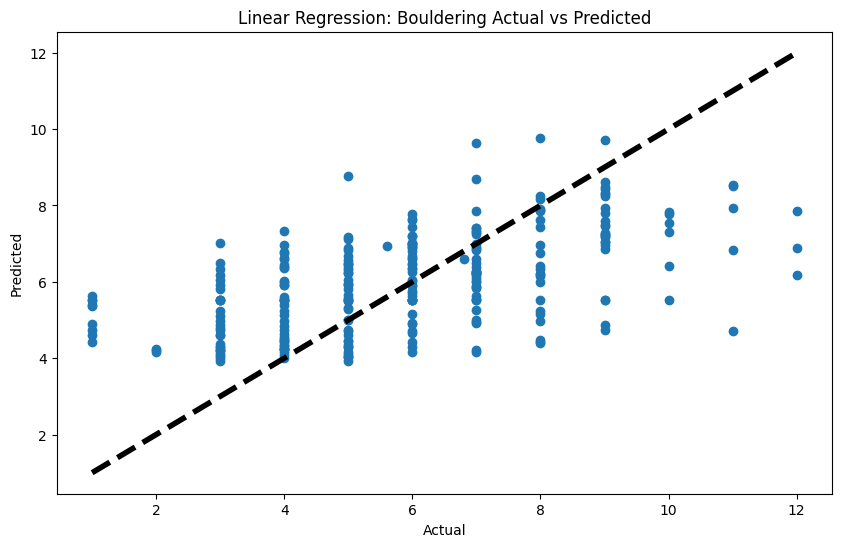

In [ ]:
# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Bouldering Grade Forecasting New Data - Linear Regression") as run:
    mlflow.set_tag("Description", "Linear Regression model to predict bouldering grades.")

    # step 1: Data Preparation for Linear Regression Bouldering Grade Forecasting
    X = data_filtered_bouldering_new[independent_vars_bouldering_new]
    y_boulder = data_filtered_bouldering_new['max_boulder_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # convert scaled arrays back to DataFrame
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # step 3: Model Selection
    model = LinearRegression()

    # step 4: Model Training
    model.fit(X_train_scaled, y_train)

    # step 5: Model Evaluation
    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)
    
    # evaluate the model using evaluation metrics on test data
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # evaluate on training data
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)


    # log metrics to mlflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mse_train", mse_train)
    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("r2_train", r2_train)
    mlflow.log_metric("mse_test", mse)
    mlflow.log_metric("mae_test", mae)
    mlflow.log_metric("r2_test", r2)

    # log model to mlflow
    mlflow.sklearn.log_model(model, "LinearRegressionModelBouldering")

    print(f"Training Data - Linear Regression Mean Squared Error: {mse_train}")
    print(f"Training Data - Linear Regression Mean Absolute Error: {mae_train}")
    print(f"Training Data - Linear Regression R-squared: {r2_train}")

    print(f"Testing Data - Linear Regression Mean Squared Error: {mse}")
    print(f"Testing Data - Linear Regression Mean Absolute Error: {mae}")
    print(f"Testing Data - Linear Regression R-squared: {r2}")

    # step 6: Model Fine-tuning (if necessary)

    # step 7: Model Deployment
    # Once we are satisfied with the model's performance, we can deploy it to make predictions on new data (e.g. using the user's input from above)
    new_data_scaled_bouldering = scaler.transform(user_data_bouldering)
    predicted_grade_numeric = model.predict(new_data_scaled_bouldering)
    predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_numeric[0]))
    print(f"Predicted Max Boulder Grade: {predicted_grade}")

    # plot the results of the model
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred) 
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Linear Regression: Bouldering Actual vs Predicted')

    plt.show()

No active run.
Randomized search best score: 0.40479298940391584
Randomized search best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Cross-Validation Mean Squared Error: 3.2800258915503937
Cross-Validation MSE Standard Deviation: 0.05162961051001891
Feature: strength_to_weight_pullup, Score: 0.16922
Feature: strength_to_weight_maxhang, Score: 0.27637
Feature: strength_to_weight_weightpull, Score: 0.11849
Feature: exp, Score: 0.18459
Feature: continuous, Score: 0.14139
Feature: repeaters1, Score: 0.10993
Training Data - Random Forest Mean Squared Error: 1.6244810204967473
Training Data - Random Forest Mean Absolute Error: 0.9816704555587071
Training Data - Random Forest R-squared: 0.7070553947201867
Testing Data - Random Forest Mean Squared Error: 3.20352372321429
Testing Data - Random Forest Mean Absolute Error: 1.410160263271639
Testing Data - Random Forest R-squared: 0.3943287441465336
Random Forest Predicted Max Boulder Grade: V9


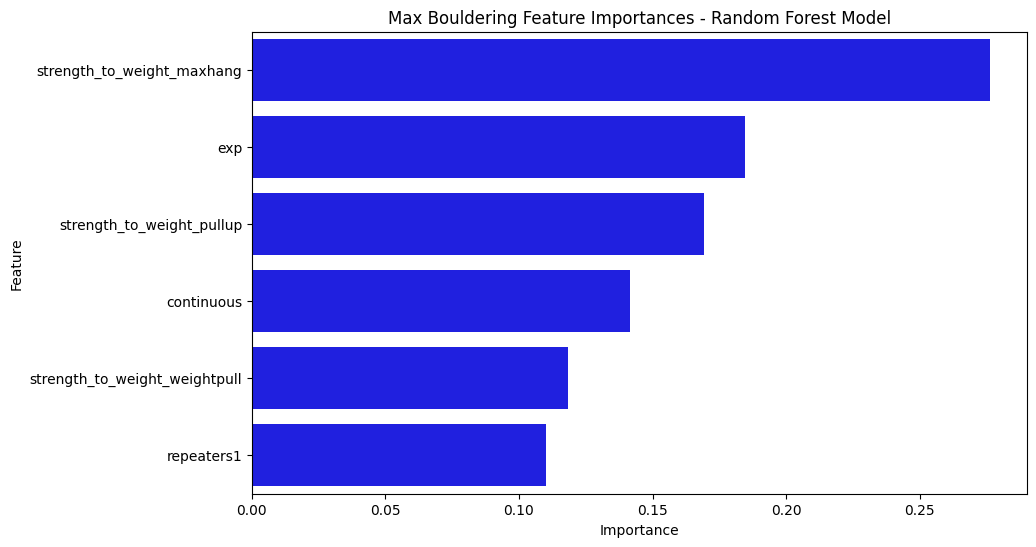

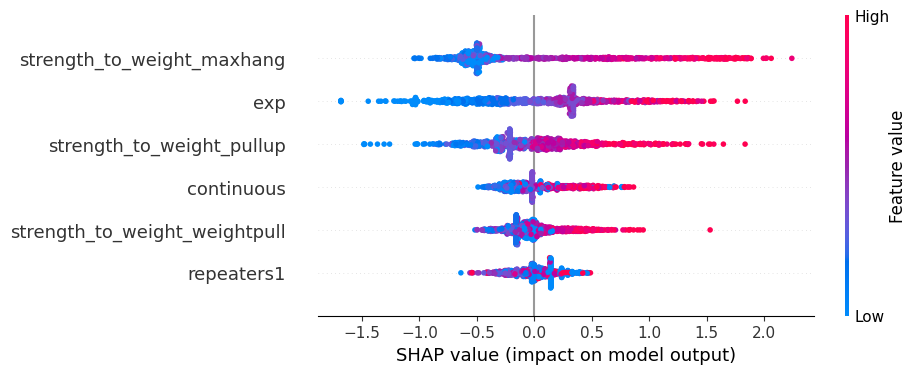

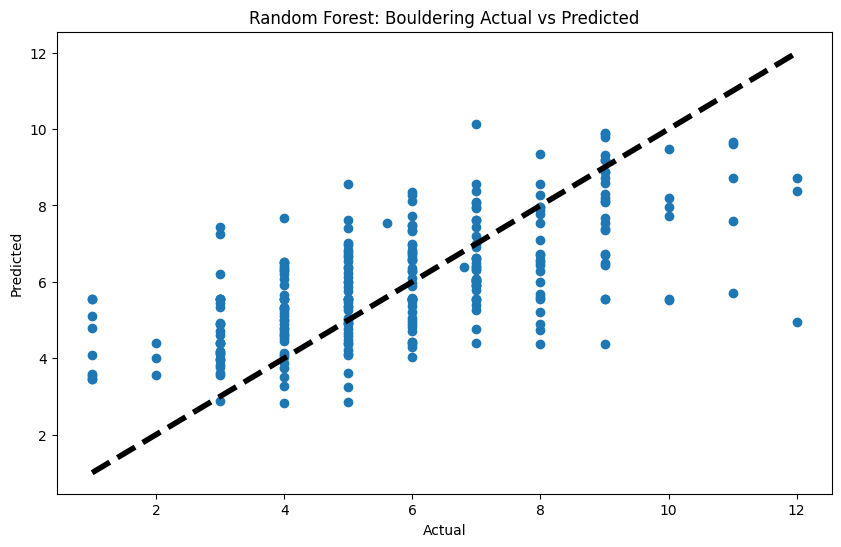

In [ ]:
# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")
    
with mlflow.start_run(run_name="Bouldering Grade Forecasting New Data - Random Forest") as run:
    mlflow.set_tag("Description", "Random Forest model to predict bouldering grades.")
    
    # step 1: Data Preparation for Bouldering Grade Forecasting - Random Forest Regression
    X = data_filtered_bouldering_new[independent_vars_bouldering_new]
    y_boulder = data_filtered_bouldering_new['max_boulder_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # Step 3: Model Selection with Regularization
    model_rf = RandomForestRegressor(random_state=42, max_features='sqrt')

    # Define the parameter values that should be searched (you can keep the existing parameter grid)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    # No need for GridSearchCV, we'll use RandomizedSearchCV for hyperparameter tuning
    # Step 4: Cross-Validation and Hyperparameter Tuning
    # Create a RandomizedSearchCV object
    random_search_rf = RandomizedSearchCV(
        model_rf, param_distributions=param_grid, n_iter=20, cv=5, random_state=42)

    # Fit the RandomizedSearchCV to the data (this performs cross-validation and hyperparameter tuning)
    random_search_rf.fit(X_train_scaled, y_train)

    # Examine the best model
    print(f"Randomized search best score: {random_search_rf.best_score_}")
    print(f"Randomized search best params: {random_search_rf.best_params_}")

    # Access the best model
    best_rf_model = random_search_rf.best_estimator_

    # Step 5: Model Evaluation
    # Perform cross-validation to evaluate the model
    cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

    # Convert the negative MSE scores to positive
    cv_mse_scores = -cv_scores

    # Calculate the mean and standard deviation of the cross-validation MSE scores
    mean_cv_mse = cv_mse_scores.mean()
    std_cv_mse = cv_mse_scores.std()

    # Print the cross-validation results
    print(f"Cross-Validation Mean Squared Error: {mean_cv_mse}")
    print(f"Cross-Validation MSE Standard Deviation: {std_cv_mse}")

    # step 5: Model Evaluation
    # make predictions on the testing dataset
    y_pred_rf = random_search_rf.predict(X_test_scaled)
    # make predictions on the training dataset
    y_train_pred_rf = random_search_rf.predict(X_train_scaled)

    # print the feature importance
    importance = random_search_rf.best_estimator_.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i],j))
        
    # evaluate the model using evaluation metrics
    # test data
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    # training data
    mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
    mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf)
    r2_rf_train = r2_score(y_train, y_train_pred_rf)


    # Log hyperparameters
    best_params = random_search_rf.best_params_
    mlflow.log_params(best_params)
    # Log metrics to mlflow
    mlflow.log_metric("mse", mse_rf)
    mlflow.log_metric("mae", mae_rf)
    mlflow.log_metric("r2", r2_rf)
    mlflow.log_metric("mse_train", mse_rf_train)
    mlflow.log_metric("mae_train", mae_rf_train)
    mlflow.log_metric("r2_train", r2_rf_train)
    mlflow.log_metric("mse_test", mse_rf)
    mlflow.log_metric("mae_test", mae_rf)
    mlflow.log_metric("r2_test", r2_rf)
    # Log feature importances
    for feature, importance in zip(X.columns, random_search_rf.best_estimator_.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
    # Log model to mlflow
    mlflow.sklearn.log_model(random_search_rf.best_estimator_, "RandomForestModelBouldering")
    

    print(f"Training Data - Random Forest Mean Squared Error: {mse_rf_train}")
    print(f"Training Data - Random Forest Mean Absolute Error: {mae_rf_train}")
    print(f"Training Data - Random Forest R-squared: {r2_rf_train}")

    print(f"Testing Data - Random Forest Mean Squared Error: {mse_rf}")
    print(f"Testing Data - Random Forest Mean Absolute Error: {mae_rf}")
    print(f"Testing Data - Random Forest R-squared: {r2_rf}")

    # Predict with new data
    new_data_scaled = scaler.transform(user_data_bouldering)
    new_data_scaled_bouldering = scaler.transform(user_data_bouldering)
    predicted_grade_rf = random_search_rf.predict(new_data_scaled_bouldering)
    predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_rf[0]))
    print(f"Random Forest Predicted Max Boulder Grade: {predicted_grade}")

    # get feature importances for visualization
    importances = random_search_rf.best_estimator_.feature_importances_
    # create a dataframe for visualization
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    # create a bar plot for feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Max Bouldering Feature Importances - Random Forest Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # plot feature importance using SHAP values
    explainer = shap.TreeExplainer(random_search_rf.best_estimator_, feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    # plot actual vs predicted scatter
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_rf)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest: Bouldering Actual vs Predicted')
    plt.show()
    
# directory to save pkl files
save_dir = '/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/pkl_files'
    
# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the best model as a pkl file to the specified directory
with open(os.path.join(save_dir, 'best_model_rf_bouldering_newdata.pkl'), 'wb') as f:
    pickle.dump(random_search_rf.best_estimator_, f)

# Save the scaler as a pkl file to the specified directory
with open(os.path.join(save_dir, 'scaler_rf_bouldering_newdata.pkl'), 'wb') as f:
    pickle.dump(scaler, f)


No active run.
Randomized search best score: 0.3994068700290045
Randomized search best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 2, 'learning_rate': 0.1}
Feature: strength_to_weight_pullup, Score: 0.16638
Feature: strength_to_weight_maxhang, Score: 0.51731
Feature: strength_to_weight_weightpull, Score: 0.03361
Feature: exp, Score: 0.21525
Feature: continuous, Score: 0.02360
Feature: repeaters1, Score: 0.04385
Training Data - Gradient Boosting Mean Squared Error: 2.6922279221917256
Training Data - Gradient Boosting Mean Absolute Error: 1.295581689112351
Training Data - Gradient Boosting R-squared: 0.5145073189291064
Testing Data - Gradient Boosting Mean Squared Error: 3.317389457825376
Testing Data - Gradient Boosting Mean Absolute Error: 1.4514719858012752
Testing Data - Gradient Boosting R-squared: 0.3728008241312021
Gradient Boosting Predicted Max Boulder Grade: V11
Maximum predicted grade by Gradient Boosting model: 9.87843040460512


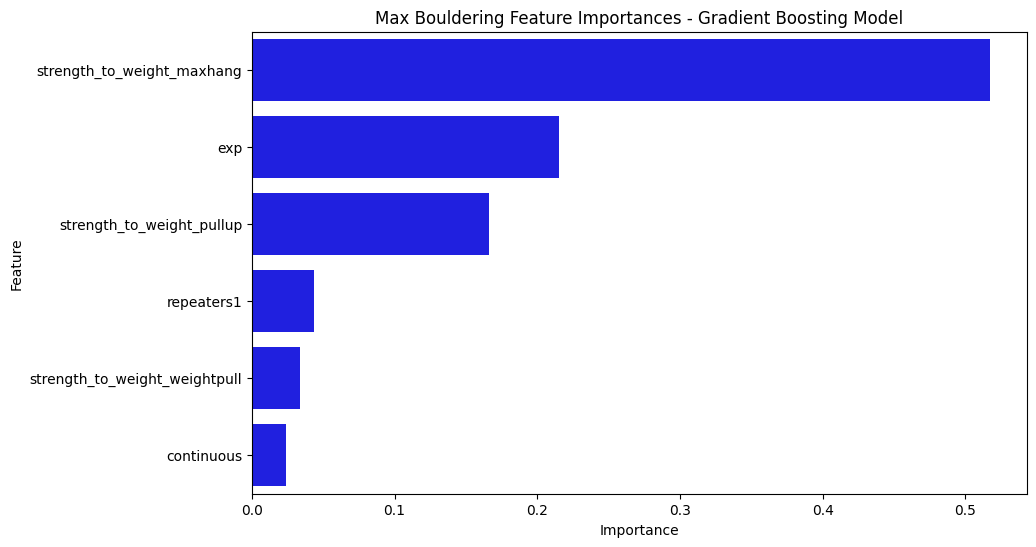

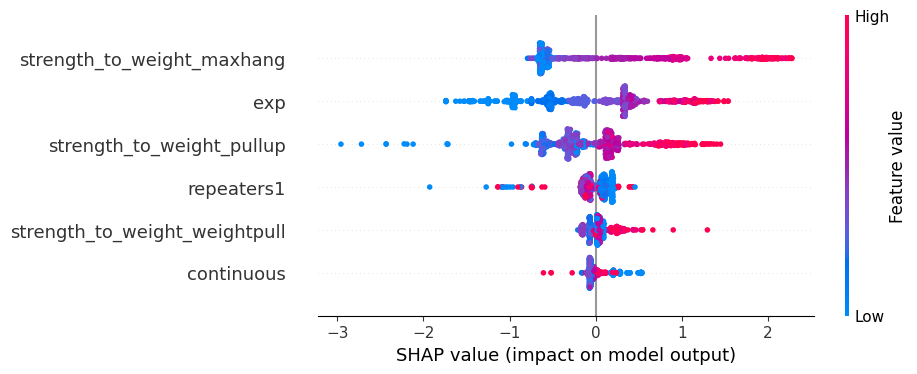

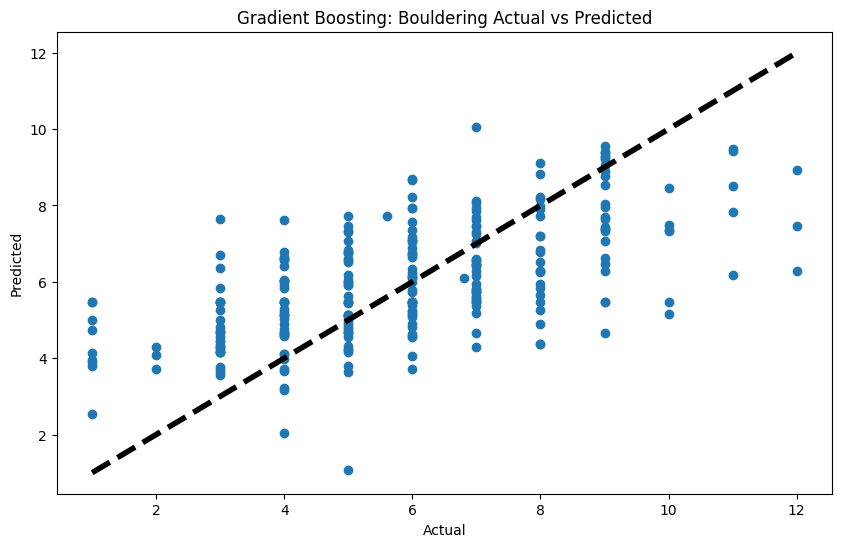

In [ ]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Bouldering Grade Forecasting New Data - Gradient Boosting") as run:
    mlflow.set_tag("Description", "Gradient Boosting model to predict bouldering grades.")

    # step 1: Data Preparation for Bouldering Grade Forecasting - Gradient Boosting Model
    X = data_filtered_bouldering_new[independent_vars_bouldering_new]
    y_boulder = data_filtered_bouldering_new['max_boulder_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # step 3: Model Selection with Randomized Search
    model_gb = GradientBoostingRegressor(random_state=42)

    # define the parameters grid
    param_grid_gb = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [None, 2, 4, 6],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 3]
    }

    # Create a RandomizedSearchCV object
    random_search_gb = RandomizedSearchCV(
        model_gb, param_distributions=param_grid_gb, n_iter=20, cv=5, random_state=42)

    # Fit the RandomizedSearchCV to the data (this performs cross-validation and hyperparameter tuning)
    random_search_gb.fit(X_train_scaled, y_train)

    # Examine the best model
    print(f"Randomized search best score: {random_search_gb.best_score_}")
    print(f"Randomized search best params: {random_search_gb.best_params_}")

    # Make the best model the new Gradient Boosting model
    model_gb = random_search_gb.best_estimator_

    # step 5: Model Evaluation
    # Make predictions on the testing dataset
    y_pred_gb = model_gb.predict(X_test_scaled)
    # Make predictions on the training dataset
    y_train_pred_gb = model_gb.predict(X_train_scaled)

    # Print the feature importance
    importance = model_gb.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i], j))

    # Evaluate the model using evaluation metrics
    # Test data
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)
    # Training data
    mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
    mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
    r2_gb_train = r2_score(y_train, y_train_pred_gb)

    # Log hyperparameters
    best_params = random_search_gb.best_params_
    mlflow.log_params(best_params)
    # Log metrics to mlflow
    mlflow.log_metric("mse", mse_gb)
    mlflow.log_metric("mae", mae_gb)
    mlflow.log_metric("r2", r2_gb)
    mlflow.log_metric("mse_train", mse_gb_train)
    mlflow.log_metric("mae_train", mae_gb_train)
    mlflow.log_metric("r2_train", r2_gb_train)
    mlflow.log_metric("mse_test", mse_gb)
    mlflow.log_metric("mae_test", mae_gb)
    mlflow.log_metric("r2_test", r2_gb)
    # Log feature importances
    for feature, importance in zip(X.columns, model_gb.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
    # Log model to mlflow
    mlflow.sklearn.log_model(model_gb, "GradientBoostingModelBouldering")

    print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
    print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
    print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

    print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
    print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
    print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")

    # Predict with new data
    new_data_scaled_bouldering = scaler.transform(user_data_bouldering)
    predicted_grade_gb = model_gb.predict(new_data_scaled_bouldering)
    predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_gb[0]))
    print(f"Gradient Boosting Predicted Max Boulder Grade: {predicted_grade}")

    # Print the maximum predicted grade for the model
    max_pred_gb = np.max(predicted_grade_gb)
    print(f"Maximum predicted grade by Gradient Boosting model: {max_pred_gb}")

    # Get feature importances for visualization
    importances = model_gb.feature_importances_
    # Create a dataframe for visualization of feature importance
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Max Bouldering Feature Importances - Gradient Boosting Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # Plot feature importance using SHAP values
    explainer = shap.Explainer(model_gb, feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    # Plot scatter plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_gb)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting: Bouldering Actual vs Predicted')
    plt.show()

# directory to save pkl files
save_dir = '/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/pkl_files'
    
# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the best model as a pkl file to the specified directory
with open(os.path.join(save_dir, 'best_model_gb_bouldering_newdata.pkl'), 'wb') as f:
    pickle.dump(random_search_rf.best_estimator_, f)

# Save the scaler as a pkl file to the specified directory
with open(os.path.join(save_dir, 'scaler_gb_bouldering_newdata.pkl'), 'wb') as f:
    pickle.dump(scaler, f)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Bouldering Grade Forecasting New Data - XGBoost") as run:
    mlflow.set_tag("Description", "XGBoost model to predict bouldering grades.")

    # Step 1: Data Preparation for Boulder Grade Forecasting - XGBoost Model
    X = data_filtered_bouldering_new[independent_vars_bouldering_new]
    y_boulder = data_filtered_bouldering_new['max_boulder_numeric']

    # Check for NaN or infinite values in y_Boulder
    if y_boulder.isnull().sum() > 0 or not np.isfinite(y_boulder).all():
        # Handle missing or invalid values in y_Boulder
        y_Boulder = y_boulder.fillna(y_boulder.mean())  # Example: Replace NaN with mean value

    # Check the range and distribution of y_Boulder
    print(y_boulder.describe())
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

    # Define the preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.columns),  # StandardScaler for numeric columns
            ('poly', PolynomialFeatures(degree=2, interaction_only=True), X.columns)  # PolynomialFeatures for numeric columns
        ])

    # Create a Pipeline with preprocessing and the StackingRegressor
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('stack', StackingRegressor(
            estimators=[('xgb', XGBRegressor(random_state=42))],
            final_estimator=RidgeCV()
        ))
    ])

    # Parameter grid for hyperparameter tuning
    param_grid_xgb = {
        'stack__xgb__n_estimators': [100, 200, 300],
        'stack__xgb__learning_rate': [0.01, 0.1, 0.2],
        'stack__xgb__max_depth': [3, 4, 5],
        'stack__xgb__min_child_weight': [1, 2, 3],
        'stack__xgb__subsample': [0.8, 0.9, 1.0],
        'stack__xgb__colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Grid search for the best parameters
    grid_search_xgb = GridSearchCV(estimator=pipeline, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
    grid_search_xgb.fit(X_train, y_train)

    # Best parameters and score
    print(f"Grid search best score: {grid_search_xgb.best_score_}")
    print(f"Grid search best params: {grid_search_xgb.best_params_}")

    # Best pipeline model
    model_pipeline = grid_search_xgb.best_estimator_

    # Predictions
    y_pred_stack = model_pipeline.predict(X_test)
    y_train_pred_stack = model_pipeline.predict(X_train)

    # Calculate the maximum predicted grade for the Stacking model
    max_pred_stack = max(y_pred_stack)

    print(f"Maximum predicted grade by Stacking model: {max_pred_stack}")

    # Performance metrics
    mse_stack = mean_squared_error(y_test, y_pred_stack)
    mae_stack = mean_absolute_error(y_test, y_pred_stack)
    r2_stack = r2_score(y_test, y_pred_stack)

    mse_stack_train = mean_squared_error(y_train, y_train_pred_stack)
    mae_stack_train = mean_absolute_error(y_train, y_train_pred_stack)
    r2_stack_train = r2_score(y_train, y_train_pred_stack)

    print(f"Training Data - Stacking Mean Squared Error: {mse_stack_train}")
    print(f"Training Data - Stacking Mean Absolute Error: {mae_stack_train}")
    print(f"Training Data - Stacking R-squared: {r2_stack_train}")

    print(f"Testing Data - Stacking Mean Squared Error: {mse_stack}")
    print(f"Testing Data - Stacking Mean Absolute Error: {mae_stack}")
    print(f"Testing Data - Stacking R-squared: {r2_stack}")

    # Log hyperparameters, metrics, and model
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("mse", mse_stack)
    mlflow.log_metric("mae", mae_stack)
    mlflow.log_metric("r2", r2_stack)
    mlflow.log_metric("mse_train", mse_stack_train)
    mlflow.log_metric("mae_train", mae_stack_train)
    mlflow.log_metric("r2_train", r2_stack_train)

    mlflow.sklearn.log_model(model_pipeline, "StackingModelBoulder")

    # # Visualizations
    # # Feature importance can be derived from the best XGBoost model
    # best_xgb = grid_search_xgb.best_estimator_.named_steps['stack'].estimators_[0][1]
    # poly = grid_search_xgb.best_estimator_.named_steps['preprocessor'].named_transformers_['poly']
    # feature_names = poly.get_feature_names_out(input_features=X.columns)
    # importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': best_xgb.feature_importances_})
    # importance_df = importance_df.sort_values(by='Importance', ascending=False)
    # plt.figure(figsize=(10, 6))
    # sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    # plt.title('Max Boulder Feature Importances - XGBoost Model')
    # plt.xlabel('Importance')
    # plt.ylabel('Feature')
    # plt.show()

    # # Actual vs Predicted plot
    # plt.figure(figsize=(10, 6))
    # plt.scatter(y_test, y_pred_stack)
    # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    # plt.xlabel('Actual')
    # plt.ylabel('Predicted')
    # plt.title('Stacking Model: Boulder Actual vs Predicted')
    # plt.show()

    # Save the entire pipeline including preprocessing steps
    save_dir = '/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/pkl_files'
    os.makedirs(save_dir, exist_ok=True)

    with open(os.path.join(save_dir, 'best_model_xgboost_boulder_newdata.pkl'), 'wb') as f:
        pickle.dump(model_pipeline, f)


No active run.
count    1333.000000
mean        5.938785
std         2.345189
min         1.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: max_boulder_numeric, dtype: float64
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END stack__xgb__colsample_bytree=0.8, stack__xgb__learning_rate=0.01, stack__xgb__max_depth=3, stack__xgb__min_child_weight=1, stack__xgb__n_estimators=100, stack__xgb__subsample=0.9; total time=   0.4s
[CV] END stack__xgb__colsample_bytree=0.8, stack__xgb__learning_rate=0.01, stack__xgb__max_depth=3, stack__xgb__min_child_weight=1, stack__xgb__n_estimators=100, stack__xgb__subsample=0.8; total time=   0.4s
[CV] END stack__xgb__colsample_bytree=0.8, stack__xgb__learning_rate=0.01, stack__xgb__max_depth=3, stack__xgb__min_child_weight=1, stack__xgb__n_estimators=100, stack__xgb__subsample=0.8; total time=   0.4s
[CV] END stack__xgb__colsample_bytree=0.8, stack__xgb__learning_rate=0.01, stack__xgb__

No active run.
Training Data - Linear Regression Mean Squared Error: 13.847869832419986
Training Data - Linear Regression Mean Absolute Error: 2.942524296965007
Training Data - Linear Regression R-squared: 0.21168707019868904
Testing Data - Linear Regression Mean Squared Error: 664.3756407726056
Testing Data - Linear Regression Mean Absolute Error: 4.477156881261408
Testing Data - Linear Regression R-squared: -37.97902963790538
Predicted Max Sport Grade: 8a


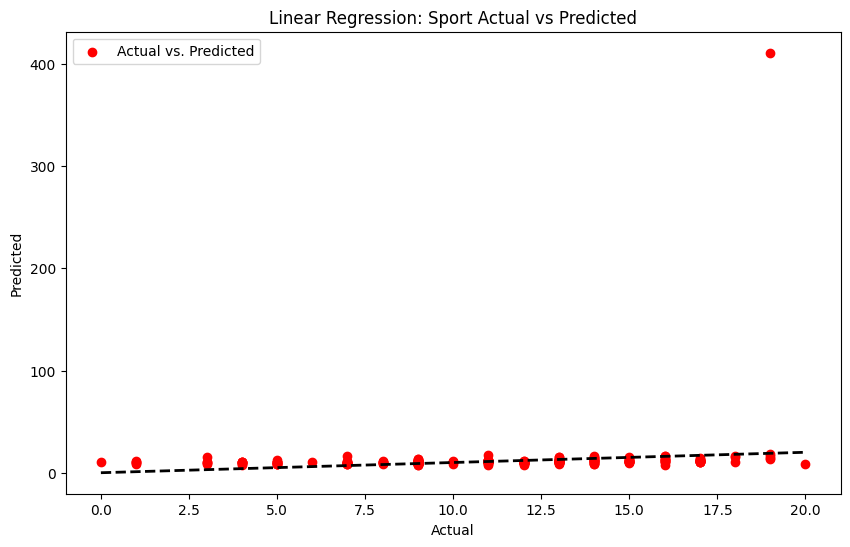

In [ ]:
# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")
    
with mlflow.start_run(run_name="Sport Grade Forecasting New Data - Linear Regression") as run:
    mlflow.set_tag("Description", "Linear Regression model to predict sport grades.")
    

    # step 1: Data Preparation for Linear Regression Sport Grade Forecasting
    X = data_filtered_sport_new[independent_vars_sport_new]
    y_sport = data_filtered_sport_new['max_sport_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # step 3: Model Selection
    # choose the machine learning algorithm
    model = LinearRegression()

    # step 4: Model Training
    model.fit(X_train_scaled, y_train)

    # step 5: Model Evaluation
    y_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)
    
    # evaluate the model using evaluation metrics on test data
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # evaluate on training data
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    # log metrics to mlflow
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    # log metrics to mlflow
    mlflow.log_metric("mse_train", mse_train)
    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("r2_train", r2_train)
    mlflow.log_metric("mse_test", mse)
    mlflow.log_metric("mae_test", mae)
    mlflow.log_metric("r2_test", r2)

    print(f"Training Data - Linear Regression Mean Squared Error: {mse_train}")
    print(f"Training Data - Linear Regression Mean Absolute Error: {mae_train}")
    print(f"Training Data - Linear Regression R-squared: {r2_train}")

    print(f"Testing Data - Linear Regression Mean Squared Error: {mse}")
    print(f"Testing Data - Linear Regression Mean Absolute Error: {mae}")
    print(f"Testing Data - Linear Regression R-squared: {r2}")
    
    # log model
    mlflow.sklearn.log_model(model, "LinearRegressionModelSport")

    # step 6: Model Fine-tuning (if necessary)

    # step 7: Model Deployment

    # example prediction
    new_data_scaled_sport = scaler.transform(user_data_sport)
    predicted_grade = model.predict(new_data_scaled_sport)
    predicted_grade = convert_numeric_to_f_grade(float(predicted_grade[0]))
    print(f"Predicted Max Sport Grade: {predicted_grade}")

    # plotting for Linear Regression
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='r', label='Actual vs. Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.legend()
    plt.title('Linear Regression: Sport Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()


No active run.
Best parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 233}
Best score:  0.22227713280682093
Feature: strength_to_weight_pullup, Score: 0.24105
Feature: strength_to_weight_maxhang, Score: 0.09402
Feature: strength_to_weight_weightpull, Score: 0.12140
Feature: exp, Score: 0.33768
Feature: continuous, Score: 0.09824
Feature: repeaters1, Score: 0.10761
Training Data - Random Forest Mean Squared Error: 7.563166499975316
Training Data - Random Forest Mean Absolute Error: 2.0843939819308
Training Data - Random Forest R-squared: 0.5694542182789457
Testing Data - Random Forest Mean Squared Error: 11.827643279798183
Testing Data - Random Forest Mean Absolute Error: 2.6319097448592177
Testing Data - Random Forest R-squared: 0.30607019635203414
Random Forest Predicted Predicted Max Sport Grade: 7a+


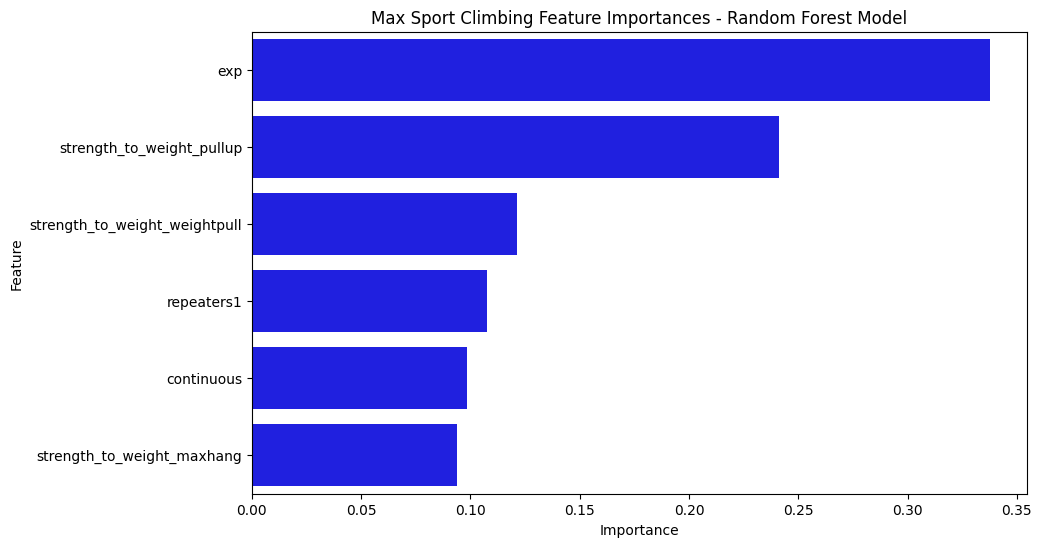

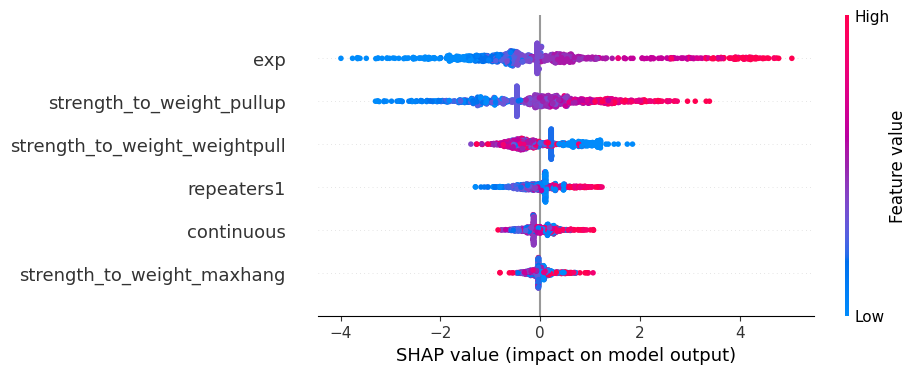

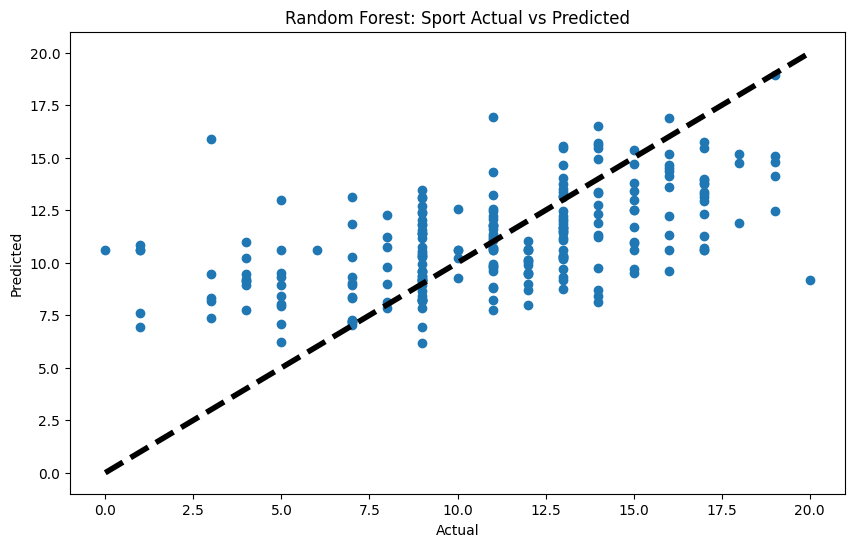

In [ ]:
# Import RandomizedSearchCV and randint
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Sport Grade Forecasting New Data - Random Forest") as run:
    mlflow.set_tag("Description", "Random Forest model to predict sport grades.")
    
    # step 1: Data Preparation for RFR Sport Grade Forecasting
    X = data_filtered_sport_new[independent_vars_sport_new]
    y_sport = data_filtered_sport_new['max_sport_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # step 3: Model Selection

    # define the parameter grid
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': [None, 6, 8, 10],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5)
    }
    

    # initialize the Random Forest model
    model_rf = RandomForestRegressor(random_state=42)

    # initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(model_rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

    # step 4: Model Training
    random_search.fit(X_train_scaled, y_train)

    # make the best model the new random forest model
    model_rf = random_search.best_estimator_

    # get the best parameters and best score
    print("Best parameters: ", random_search.best_params_)
    print("Best score: ", random_search.best_score_)

    # log best parameters from Randomized Search
    best_params = random_search.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)
        
        
    # print the feature importance
    importance = model_rf.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i],j))

    # step 5: Model Evaluation
    y_pred_rf = model_rf.predict(X_test_scaled)
    y_train_pred_rf = model_rf.predict(X_train_scaled)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    # evaluate the model on training data using evaluation metrics
    mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
    mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf)
    r2_rf_train = r2_score(y_train, y_train_pred_rf)

    # log metrics to mlflow
    mlflow.log_metric("mse", mse_rf)
    mlflow.log_metric("mae", mae_rf)
    mlflow.log_metric("r2", r2_rf)
    mlflow.log_metric("mse_train", mse_rf_train)
    mlflow.log_metric("mae_train", mae_rf_train)
    mlflow.log_metric("r2_train", r2_rf_train)
    mlflow.log_metric("mse_test", mse_rf)
    mlflow.log_metric("mae_test", mae_rf)
    mlflow.log_metric("r2_test", r2_rf)
    # Log feature importances
    for feature, importance in zip(X.columns, model_rf.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
        
    # log model
    mlflow.sklearn.log_model(model_rf, "RandomForestModelSport")
    
    print(f"Training Data - Random Forest Mean Squared Error: {mse_rf_train}")
    print(f"Training Data - Random Forest Mean Absolute Error: {mae_rf_train}")
    print(f"Training Data - Random Forest R-squared: {r2_rf_train}")

    print(f"Testing Data - Random Forest Mean Squared Error: {mse_rf}")
    print(f"Testing Data - Random Forest Mean Absolute Error: {mae_rf}")
    print(f"Testing Data - Random Forest R-squared: {r2_rf}")

    
    # Predict with new data
    new_data_scaled_sport = scaler.transform(user_data_sport)
    predicted_grade_rf = model_rf.predict(new_data_scaled_sport)
    predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_rf[0]))
    print(f"Random Forest Predicted Predicted Max Sport Grade: {predicted_grade}")


    # create a dataframe for visualization
    importances = model_rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Max Sport Climbing Feature Importances - Random Forest Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # plot feature importance using SHAP values
    explainer = shap.Explainer(model_rf,feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    # plot scatter plot of actuals vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_rf)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest: Sport Actual vs Predicted')
    plt.show()

    
# directory to save pkl files
save_dir = '/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/pkl_files'
    
# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the best model as a pkl file to the specified directory
with open(os.path.join(save_dir, 'best_model_rf_sport_newdata.pkl'), 'wb') as f:
    pickle.dump(random_search_rf.best_estimator_, f)

# Save the scaler as a pkl file to the specified directory
with open(os.path.join(save_dir, 'scaler_rf_sport_newdata.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

No active run.
Best parameters:  {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 64}
Best score:  0.23897458680869715
Feature: strength_to_weight_pullup, Score: 0.26875
Feature: strength_to_weight_maxhang, Score: 0.05500
Feature: strength_to_weight_weightpull, Score: 0.10160
Feature: exp, Score: 0.38772
Feature: continuous, Score: 0.06524
Feature: repeaters1, Score: 0.12169
Training Data - Gradient Boosting Mean Squared Error: 9.883718297847084
Training Data - Gradient Boosting Mean Absolute Error: 2.4650896750164515
Training Data - Gradient Boosting R-squared: 0.43735296309143135
Testing Data - Gradient Boosting Mean Squared Error: 12.175805064399922
Testing Data - Gradient Boosting Mean Absolute Error: 2.681249296067099
Testing Data - Gradient Boosting R-squared: 0.2856434863886834
Testing Data - Gradient Boosting with Early Stopping Mean Squared Error: 12.506615129605088
Testing Data - Gradient Boosting with Early Stopping Mean Absolute Error: 2.7382

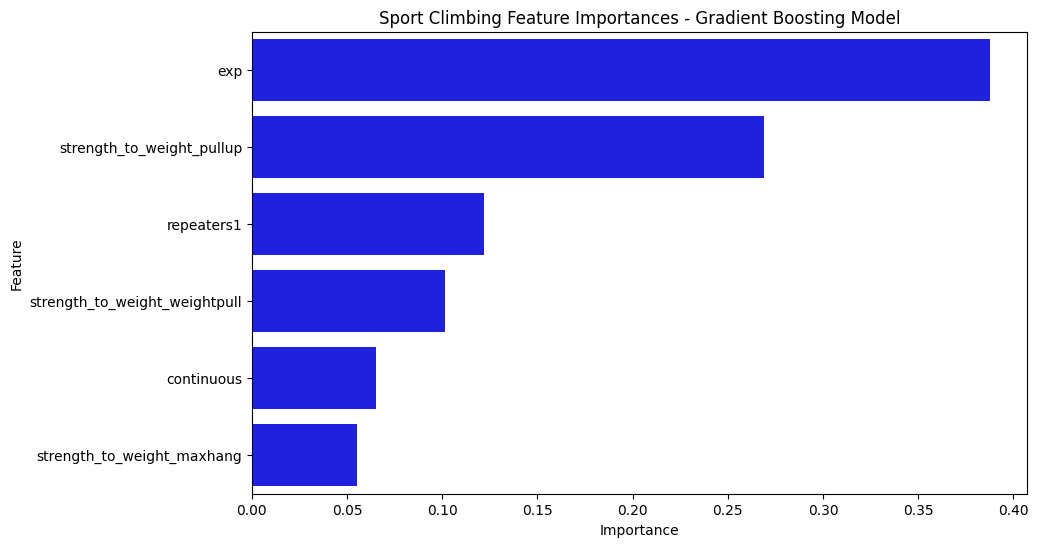

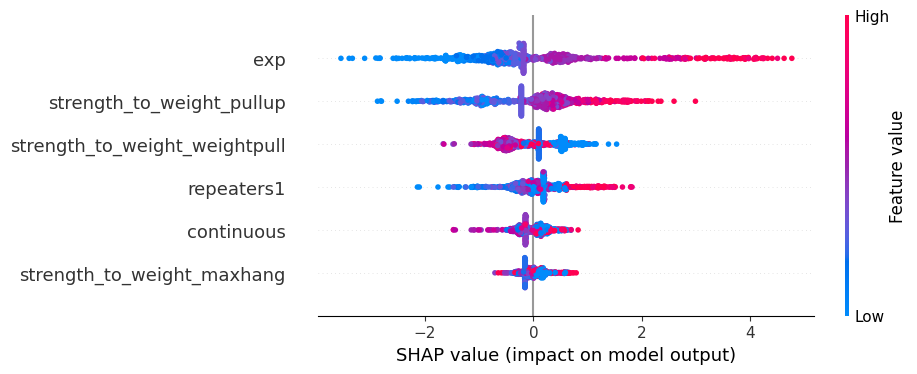

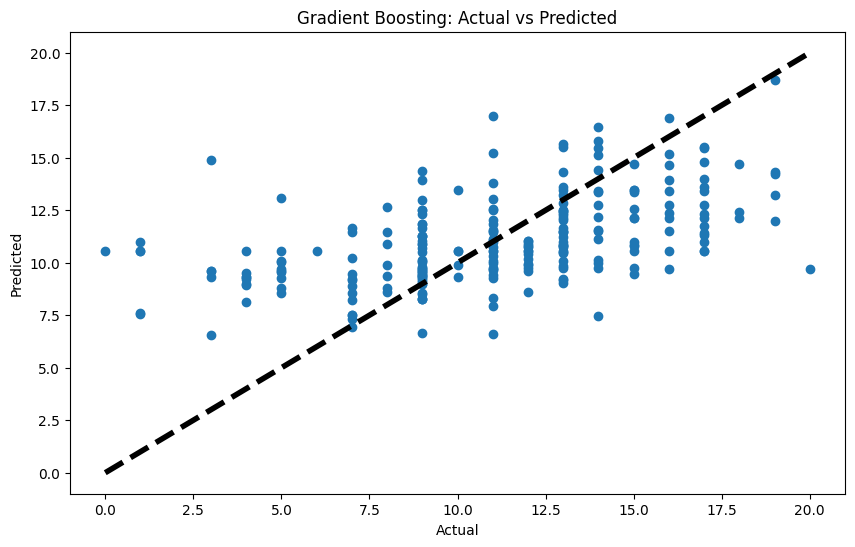

K-Fold Cross-Validation R-squared scores: [0.25520275 0.27797777 0.29653881 0.1921781  0.15692682]
Mean K-Fold Cross-Validation R-squared score: 0.23576485011669837


In [ ]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Sport Grade Forecasting New Data - Gradient Boosting") as run:
    mlflow.set_tag("Description", "Gradient Boosting model to predict sport grades.")
    
    # step 1: Data Preparation for Sport Grade Forecasting
    X = data_filtered_sport_new[independent_vars_sport_new]
    y_sport = data_filtered_sport_new['max_sport_numeric']

    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

    # step 2: Feature Engineering
    # perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # step 3: Model Selection with Randomized Search
    model_gb = GradientBoostingRegressor(random_state=42)
    # Modify parameter distributions for RandomizedSearchCV
    param_dist = {
        'n_estimators': randint(50, 200),  # Reduce the number of trees
        'max_depth': [3, 4, 5, 6],  # Restrict tree depth
        'min_samples_split': randint(5, 20),  # Increase minimum samples required to split
        'min_samples_leaf': randint(2, 10)  # Increase minimum samples required at leaf node
    }

    
    # Initialize RandomizedSearchCV
    random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

    # step 4: Model Training
    random_search_gb.fit(X_train_scaled, y_train)

    # log best parameters from Randomized Search
    best_params = random_search_gb.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    # print the best parameters and the best score
    print("Best parameters: ", random_search_gb.best_params_)
    print("Best score: ", random_search_gb.best_score_)

    # make the best model the new Gradient Boosting model
    model_gb = random_search_gb.best_estimator_

    # print the feature importance
    importance = model_gb.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i], j))

    # get feature importances for visualization
    importances = model_gb.feature_importances_

    # create a dataframe for visualization
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # step 5: Model Evaluation
    # make predictions on the testing dataset
    y_pred_gb = model_gb.predict(X_test_scaled)
    # make predictions on the training dataset
    y_train_pred_gb = model_gb.predict(X_train_scaled)

    # evaluate the model on test data using evaluation metrics
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)

    # evaluate the model on training data using evaluation metrics
    mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
    mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
    r2_gb_train = r2_score(y_train, y_train_pred_gb)

    # log metrics to mlflow
    mlflow.log_metric("mse", mse_gb)
    mlflow.log_metric("mae", mae_gb)
    mlflow.log_metric("r2", r2_gb)
    mlflow.log_metric("mse_train", mse_gb_train)
    mlflow.log_metric("mae_train", mae_gb_train)
    mlflow.log_metric("r2_train", r2_gb_train)
    mlflow.log_metric("mse_test", mse_gb)
    mlflow.log_metric("mae_test", mae_gb)
    mlflow.log_metric("r2_test", r2_gb)
    # Log feature importances
    for feature, importance in zip(X.columns, model_gb.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
    # log model
    mlflow.sklearn.log_model(random_search_gb.best_estimator_, "GradientBoostingModelSport")

        
    print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
    print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
    print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

    print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
    print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
    print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")
    
    
    from sklearn.ensemble import GradientBoostingRegressor

    # Initialize the model with early stopping
    model_gb = GradientBoostingRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        min_samples_split=6,
        min_samples_leaf=4,
        random_state=42,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
    model_gb.fit(X_train_scaled, y_train)

    # Make predictions and evaluate the model
    y_pred_gb = model_gb.predict(X_test_scaled)
    mse_gb = mean_squared_error(y_test, y_pred_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)

    print(f"Testing Data - Gradient Boosting with Early Stopping Mean Squared Error: {mse_gb}")
    print(f"Testing Data - Gradient Boosting with Early Stopping Mean Absolute Error: {mae_gb}")
    print(f"Testing Data - Gradient Boosting with Early Stopping R-squared: {r2_gb}")



    # predict with new data
    new_data_scaled_sport = scaler.transform(user_data_sport)
    predicted_grade = model_gb.predict(new_data_scaled_sport)
    predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_gb[0]))
    print(f"Gradient Boosted Predicted Predicted Max Sport Grade: {predicted_grade}")


    # Create a bar plot for feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Sport Climbing Feature Importances - Gradient Boosting Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # plot feature importance using SHAP values
    explainer = shap.Explainer(model_gb,feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    # scatter plot for actuals vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_gb)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting: Actual vs Predicted')
    plt.show()
    
    from sklearn.model_selection import KFold, cross_val_score

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model_gb = GradientBoostingRegressor(**random_search_gb.best_params_, random_state=42)
    cross_val_scores = cross_val_score(model_gb, X_train_scaled, y_train, cv=kf, scoring='r2')
    print(f"K-Fold Cross-Validation R-squared scores: {cross_val_scores}")
    print(f"Mean K-Fold Cross-Validation R-squared score: {cross_val_scores.mean()}")


# directory to save pkl files
save_dir = '/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/pkl_files'
    
# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the best model as a pkl file to the specified directory
with open(os.path.join(save_dir, 'best_model_gb_sport_newdata.pkl'), 'wb') as f:
    pickle.dump(random_search_rf.best_estimator_, f)

# Save the scaler as a pkl file to the specified directory
with open(os.path.join(save_dir, 'scaler_gb_sport_newdata.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

No active run.
Best parameters:  {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 64}
Best score:  0.23897458680869715
Feature: strength_to_weight_pullup, Score: 0.26875
Feature: strength_to_weight_maxhang, Score: 0.05500
Feature: strength_to_weight_weightpull, Score: 0.10160
Feature: exp, Score: 0.38772
Feature: continuous, Score: 0.06524
Feature: repeaters1, Score: 0.12169
Training Data - Gradient Boosting Mean Squared Error: 9.883718297847084
Training Data - Gradient Boosting Mean Absolute Error: 2.4650896750164515
Training Data - Gradient Boosting R-squared: 0.43735296309143135
Testing Data - Gradient Boosting Mean Squared Error: 12.175805064399922
Testing Data - Gradient Boosting Mean Absolute Error: 2.681249296067099
Testing Data - Gradient Boosting R-squared: 0.2856434863886834
K-Fold Cross-Validation R-squared scores: [0.25520275 0.27797777 0.29653881 0.1921781  0.15692682]
Mean K-Fold Cross-Validation R-squared score: 0.23576485011669837


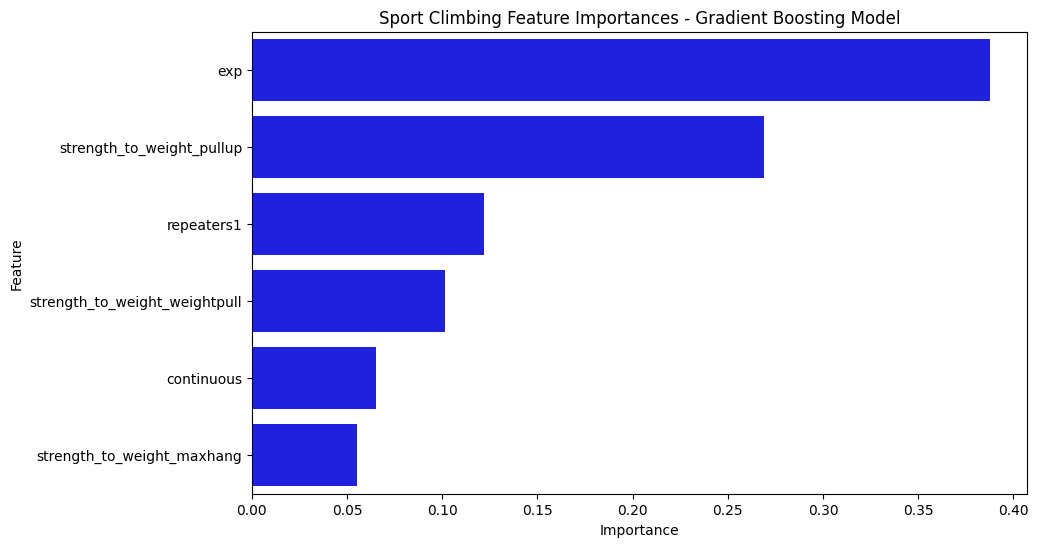

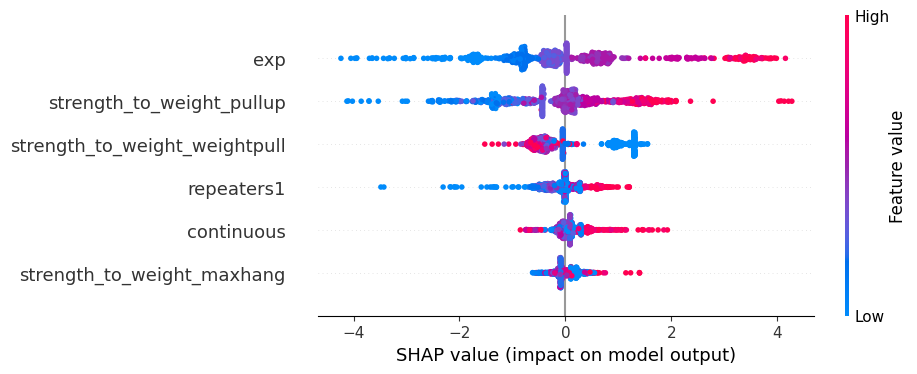

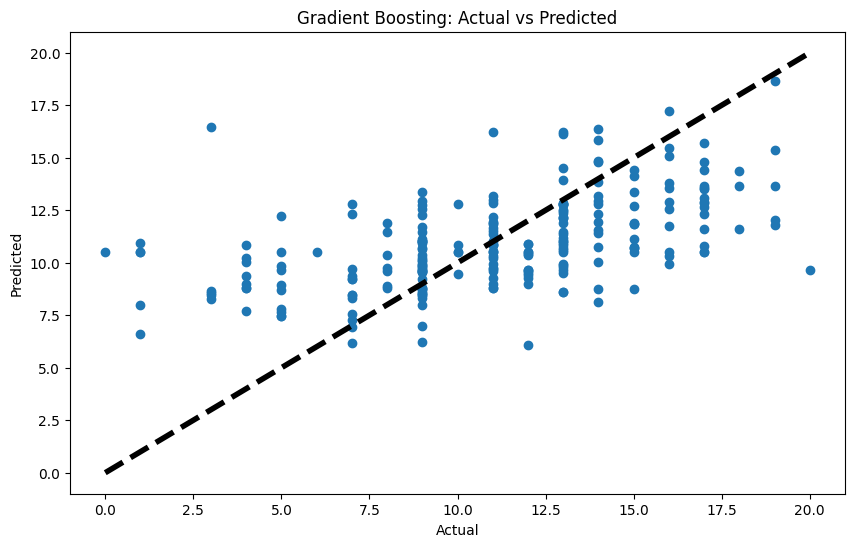

OSError: [Errno 30] Read-only file system: '/path'

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from scipy.stats import randint
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import pandas as pd
import numpy as np
import os
import pickle
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Sport Grade Forecasting New Data - Gradient Boosting") as run:
    mlflow.set_tag("Description", "Gradient Boosting model to predict sport grades.")
    
    # Data Preparation for Sport Grade Forecasting
    X = data_filtered_sport_new[independent_vars_sport_new]
    y_sport = data_filtered_sport_new['max_sport_numeric']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

    # Feature Engineering
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # Model Selection with Randomized Search
    model_gb = GradientBoostingRegressor(random_state=42)
    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': randint(5, 20),
        'min_samples_leaf': randint(2, 10)
    }

    random_search_gb = RandomizedSearchCV(model_gb, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)
    random_search_gb.fit(X_train_scaled, y_train)

    # Log best parameters from Randomized Search
    best_params = random_search_gb.best_params_
    for param, value in best_params.items():
        mlflow.log_param(param, value)

    print("Best parameters: ", random_search_gb.best_params_)
    print("Best score: ", random_search_gb.best_score_)

    model_gb = random_search_gb.best_estimator_

    # Feature Importance
    importance = model_gb.feature_importances_
    for i, j in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (X.columns[i], j))

    importances = model_gb.feature_importances_
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Model Evaluation
    y_pred_gb = model_gb.predict(X_test_scaled)
    y_train_pred_gb = model_gb.predict(X_train_scaled)

    mse_gb = mean_squared_error(y_test, y_pred_gb)
    mae_gb = mean_absolute_error(y_test, y_pred_gb)
    r2_gb = r2_score(y_test, y_pred_gb)

    mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
    mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
    r2_gb_train = r2_score(y_train, y_train_pred_gb)

    mlflow.log_metric("mse", mse_gb)
    mlflow.log_metric("mae", mae_gb)
    mlflow.log_metric("r2", r2_gb)
    mlflow.log_metric("mse_train", mse_gb_train)
    mlflow.log_metric("mae_train", mae_gb_train)
    mlflow.log_metric("r2_train", r2_gb_train)
    mlflow.log_metric("mse_test", mse_gb)
    mlflow.log_metric("mae_test", mae_gb)
    mlflow.log_metric("r2_test", r2_gb)

    for feature, importance in zip(X.columns, model_gb.feature_importances_):
        mlflow.log_param(f"feature_importance_{feature}", importance)
    
    mlflow.sklearn.log_model(random_search_gb.best_estimator_, "GradientBoostingModelSport")

    print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
    print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
    print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

    print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
    print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
    print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")

    # Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cross_val_scores = cross_val_score(model_gb, X_train_scaled, y_train, cv=kf, scoring='r2')
    print(f"K-Fold Cross-Validation R-squared scores: {cross_val_scores}")
    print(f"Mean K-Fold Cross-Validation R-squared score: {cross_val_scores.mean()}")

    # Visualizations
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    plt.title('Sport Climbing Feature Importances - Gradient Boosting Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    explainer = shap.Explainer(model_gb, feature_names=X.columns)
    shap_values = explainer(X_train_scaled)
    shap.plots.beeswarm(shap_values)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_gb)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting: Actual vs Predicted')
    plt.show()

    # Save models and scaler
    save_dir = '/path/to/your/directory'
    os.makedirs(save_dir, exist_ok=True)

    with open(os.path.join(save_dir, 'best_model_gb_sport_newdata.pkl'), 'wb') as f:
        pickle.dump(random_search_gb.best_estimator_, f)

    with open(os.path.join(save_dir, 'scaler_gb_sport_newdata.pkl'), 'wb') as f:
        pickle.dump(scaler, f)

    # Additional Ensemble Approach
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
    voting_regressor = VotingRegressor([('gb', model_gb), ('rf', model_rf)])
    voting_regressor.fit(X_train_scaled, y_train)
    
    y_pred_voting = voting_regressor.predict(X_test_scaled)
    mse_voting = mean_squared_error(y_test, y_pred_voting)
    mae_voting = mean_absolute_error(y_test, y_pred_voting)
    r2_voting = r2_score(y_test, y_pred_voting)

    print(f"Voting Regressor - Mean Squared Error: {mse_voting}")
    print(f"Voting Regressor - Mean Absolute Error: {mae_voting}")
    print(f"Voting Regressor - R-squared: {r2_voting}")


In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    print("Active run exists.")
    mlflow.end_run()
else:
    print("No active run.")

with mlflow.start_run(run_name="Sport Grade Forecasting New Data - XGBoost") as run:
    mlflow.set_tag("Description", "XGBoost model to predict sport grades.")

    # Step 1: Data Preparation for Sport Grade Forecasting - XGBoost Model
    X = data_filtered_sport_new[independent_vars_sport_new]
    y_sport = data_filtered_sport_new['max_sport_numeric']

    # Check for NaN or infinite values in y_sport
    if y_sport.isnull().sum() > 0 or not np.isfinite(y_sport).all():
        # Handle missing or invalid values in y_sport
        y_sport = y_sport.fillna(y_sport.mean())  # Example: Replace NaN with mean value

    # Check the range and distribution of y_sport
    print(y_sport.describe())
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

    # Define the preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.columns),  # StandardScaler for numeric columns
            ('poly', PolynomialFeatures(degree=2, interaction_only=True), X.columns)  # PolynomialFeatures for numeric columns
        ])

    # Create a Pipeline with preprocessing and the StackingRegressor
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('stack', StackingRegressor(
            estimators=[('xgb', XGBRegressor(random_state=42))],
            final_estimator=RidgeCV()
        ))
    ])

    # Parameter grid for hyperparameter tuning
    param_grid_xgb = {
        'stack__xgb__n_estimators': [100, 200, 300],
        'stack__xgb__learning_rate': [0.01, 0.1, 0.2],
        'stack__xgb__max_depth': [3, 4, 5],
        'stack__xgb__min_child_weight': [1, 2, 3],
        'stack__xgb__subsample': [0.8, 0.9, 1.0],
        'stack__xgb__colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Grid search for the best parameters
    grid_search_xgb = GridSearchCV(estimator=pipeline, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
    grid_search_xgb.fit(X_train, y_train)

    # Best parameters and score
    print(f"Grid search best score: {grid_search_xgb.best_score_}")
    print(f"Grid search best params: {grid_search_xgb.best_params_}")

    # Best pipeline model
    model_pipeline = grid_search_xgb.best_estimator_

    # Predictions
    y_pred_stack = model_pipeline.predict(X_test)
    y_train_pred_stack = model_pipeline.predict(X_train)

    # Calculate the maximum predicted grade for the Stacking model
    max_pred_stack = max(y_pred_stack)

    print(f"Maximum predicted grade by Stacking model: {max_pred_stack}")

    # Performance metrics
    mse_stack = mean_squared_error(y_test, y_pred_stack)
    mae_stack = mean_absolute_error(y_test, y_pred_stack)
    r2_stack = r2_score(y_test, y_pred_stack)

    mse_stack_train = mean_squared_error(y_train, y_train_pred_stack)
    mae_stack_train = mean_absolute_error(y_train, y_train_pred_stack)
    r2_stack_train = r2_score(y_train, y_train_pred_stack)

    print(f"Training Data - Stacking Mean Squared Error: {mse_stack_train}")
    print(f"Training Data - Stacking Mean Absolute Error: {mae_stack_train}")
    print(f"Training Data - Stacking R-squared: {r2_stack_train}")

    print(f"Testing Data - Stacking Mean Squared Error: {mse_stack}")
    print(f"Testing Data - Stacking Mean Absolute Error: {mae_stack}")
    print(f"Testing Data - Stacking R-squared: {r2_stack}")

    # Log hyperparameters, metrics, and model
    mlflow.log_params(grid_search_xgb.best_params_)
    mlflow.log_metric("mse", mse_stack)
    mlflow.log_metric("mae", mae_stack)
    mlflow.log_metric("r2", r2_stack)
    mlflow.log_metric("mse_train", mse_stack_train)
    mlflow.log_metric("mae_train", mae_stack_train)
    mlflow.log_metric("r2_train", r2_stack_train)

    mlflow.sklearn.log_model(model_pipeline, "StackingModelSport")

    # # Visualizations
    # # Feature importance can be derived from the best XGBoost model
    # best_xgb = grid_search_xgb.best_estimator_.named_steps['stack'].estimators_[0]
    # importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': best_xgb.feature_importances_})
    # importance_df = importance_df.sort_values(by='Importance', ascending=False)
    # plt.figure(figsize=(10, 6))
    # sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
    # plt.title('Max Sport Feature Importances - XGBoost Model')
    # plt.xlabel('Importance')
    # plt.ylabel('Feature')
    # plt.show()

    # # Actual vs Predicted plot
    # plt.figure(figsize=(10, 6))
    # plt.scatter(y_test, y_pred_stack)
    # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    # plt.xlabel('Actual')
    # plt.ylabel('Predicted')
    # plt.title('Stacking Model: Sport Actual vs Predicted')
    # plt.show()

    # Save the entire pipeline including preprocessing steps
    save_dir = '/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/pkl_files'
    os.makedirs(save_dir, exist_ok=True)

    with open(os.path.join(save_dir, 'best_model_xgboost_sport_newdata.pkl'), 'wb') as f:
        pickle.dump(model_pipeline, f)


No active run.
count    1180.000000
mean       10.998305
std         4.180604
min         0.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        21.000000
Name: max_sport_numeric, dtype: float64
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END stack__xgb__colsample_bytree=0.8, stack__xgb__learning_rate=0.01, stack__xgb__max_depth=3, stack__xgb__min_child_weight=1, stack__xgb__n_estimators=100, stack__xgb__subsample=0.8; total time=   0.4s
[CV] END stack__xgb__colsample_bytree=0.8, stack__xgb__learning_rate=0.01, stack__xgb__max_depth=3, stack__xgb__min_child_weight=1, stack__xgb__n_estimators=100, stack__xgb__subsample=0.8; total time=   0.4s
[CV] END stack__xgb__colsample_bytree=0.8, stack__xgb__learning_rate=0.01, stack__xgb__max_depth=3, stack__xgb__min_child_weight=1, stack__xgb__n_estimators=100, stack__xgb__subsample=0.8; total time=   0.4s
[CV] END stack__xgb__colsample_bytree=0.8, stack__xgb__learning_rate=0.01, stack__xgb__ma

In [ ]:
import numpy
import pandas
import matplotlib
import seaborn
import scipy
import sklearn
import statsmodels
import pymongo
import shap
import mlflow
import pickle
import streamlit
import requests
import secrets
import os
import imblearn
import xgboost
import inotify

print("NumPy version:", numpy.__version__)
print("Pandas version:", pandas.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", seaborn.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-Learn version:", sklearn.__version__)
print("Statsmodels version:", statsmodels.__version__)
print("SHAP version:", shap.__version__)
print("MLflow version:", mlflow.__version__)
print("Streamlit version:", streamlit.__version__)
print("Requests version:", requests.__version__)
print("Pymongo version:", pymongo.__version__)
print("Imbalanced-Learn version:", imblearn.__version__)
print("XGBoost version:", xgboost.__version__)

# # generate a requirements.txt using only the packages we need
# with open('requirements.txt', 'w') as f:
#     f.write('numpy=={}\n'.format(numpy.__version__))
#     f.write('pandas=={}\n'.format(pandas.__version__))
#     f.write('matplotlib=={}\n'.format(matplotlib.__version__))
#     f.write('seaborn=={}\n'.format(seaborn.__version__))
#     f.write('scipy=={}\n'.format(scipy.__version__))
#     f.write('scikit-learn=={}\n'.format(sklearn.__version__))
#     f.write('statsmodels=={}\n'.format(statsmodels.__version__))
#     f.write('shap=={}\n'.format(shap.__version__))
#     f.write('mlflow=={}\n'.format(mlflow.__version__))
#     f.write('streamlit=={}\n'.format(streamlit.__version__))
#     f.write('requests=={}\n'.format(requests.__version__))
#     f.write('pymongo=={}\n'.format(pymongo.__version__))
#     f.write('imbalanced-learn=={}'.format(imblearn.__version__))
#     f.write('pymongo[srv]=={}'.format(pymongo.__version__))
#     f.write('xgboost=={}'.format(xgboost.__version__))
#     f.write('inotify=={}'.format(inotify.__version__))



NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.7.2
Seaborn version: 0.12.2
SciPy version: 1.11.3
Scikit-Learn version: 1.3.1
Statsmodels version: 0.14.0
SHAP version: 0.43.0
MLflow version: 2.6.0
Streamlit version: 1.27.2
Requests version: 2.31.0
Pymongo version: 3.12.0
Imbalanced-Learn version: 0.12.3
XGBoost version: 2.1.0
